In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xlrd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.optimize as spop
# кульбак лейбнер
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
# Импорт openpyxl
import openpyxl
from openpyxl import load_workbook
import random
from scipy.special import rel_entr
import torch
from torch.nn.functional import softmax
from torch.nn.functional import kl_div
import torch.optim as optim
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from scipy.stats import kendalltau

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### Переключение между обучающей и валидационной

In [3]:
path_main = r'C:\Users\mikhe\Documents'
path_reports = [r'\РЕЙТИНГ_МЕТОДИКА3_010122_010723.xlsx']

In [4]:
# Забираем колонки только с значениями
x = list(np.linspace(1,143,72))
x.insert(0,0)
x.pop()
x = list(map(int,x))

# Читаем каждую книгу объединяем все листы в один датафрейм
combined = pd.DataFrame()
# Цикл по файлам
for xl_file in path_reports:
    # Загружаем файл Excel
    xl_file_path = path_main + xl_file
    wb = load_workbook(xl_file_path)
    # Цикл по листам
    for sheet_name in wb.sheetnames:
        if sheet_name not in ['Лист1', 'D0001', 'D0002']:
            # Получаем дату отчета из ячейки B2
            ws = wb[sheet_name]
            report_date = ws.cell(row=2, column=2).value
            
#             if isinstance(report_date, datetime):
#             report_date = report_date.strftime('%d.%m.%Y')
            report_date = datetime.strptime(report_date, '"%d.%m.%Y"')
                
            df = pd.read_excel(xl_file_path, sheet_name=sheet_name, skiprows=7, usecols=x)
            df = df.T
            df.columns = df.iloc[0]
            df = df[1:]
            df = df[(df['Наличие рейтинга АКРА'] == 1) | (df['Наличие рейтинга НРА (агентство)'] == 1) | 
                    (df['Наличие рейтинга НКР'] == 1) | (df['Наличие рейтинга Эксперт РА'] == 1)]
            df = df[(df['Структура собственности'] != 0)]
            df = df[(df['Кредиты ЮЛ'] != 0) & (df['Средства клиентов, не являющихся КО'] != 0) & 
                    (df['БИЗНЕС-ПРОФИЛЬ'] > 0)]
            df['report_date'] = report_date
            df = df[['1.1. Отношение кредитов к депозитам (LDR)', '1.2. Доля средств населения', '1.3. Надежность банка',
                     '1.4. Норматив мгновенной ликвидности', '1.5. Норматив текущей ликвидности', 
                     '2.1. Достаточность собственных средств', '2.2. Достаточность основного капитала',
                     '2.3. Устойчивость капитала', '2.4. Доля основного капитала в общем капитале', 
                     '3.1. ROE', '3.2. ROA', '4.1. Коэффициент процентных доходов', 
                     '4.2. Коэффициент процентных расходов', '4.3. Доля операционных расходов в доходах',
                     '5.1. Прирост кредитов', '5.2. Уровень просроченной задолженности', 
                     '5.3. Отношение NPL к Капиталу  (1.2)', '5.4. Коэффициент резервирования', 
                     '5.5. Стоимость риска', 'Доля рынка', 'Стабильность доли рынка',
                     'Отклонение темпов роста', 'Диверсификация дохода', 'География присутствия', 
                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 
                     'Деловая репутация', 'Связанность операций с бизнесом', 'Отчетность МСФО', 'Рейтинги НРА', 
                     'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 'ПОДДЕРЖКА АКЦИОНЕРОВ', 
                     'ПОДДЕРЖКА ГОСУДАРСТВА', 'Универс рейтинг по вшнешнему', 'report_date']]
            combined = pd.concat([combined, df])

# Переименовываем столбец
combined = combined.rename(columns={'Универс рейтинг по вшнешнему': 'External_rating'})

# Заполняем пропущенные значения
combined.fillna(value=0, inplace=True)

# Удаляем дубликаты
resultDataSet = combined.drop_duplicates()

# Заменяем значения 0.0001 и -0.0001 на 0
resultDataSet.replace(0.0001, 0, inplace=True)
resultDataSet.replace(-0.0001, 0, inplace=True)

# Создаем новый столбец 'ПОДДЕРЖКА МАКСИМУМ' с максимальным значением из 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = np.maximum(resultDataSet['ПОДДЕРЖКА АКЦИОНЕРОВ'], resultDataSet['ПОДДЕРЖКА ГОСУДАРСТВА'])
# Удаляем столбцы 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet.drop(['ПОДДЕРЖКА АКЦИОНЕРОВ', 'ПОДДЕРЖКА ГОСУДАРСТВА'], axis=1, inplace=True)

# Выводим уникальные значения в столбце 'External_rating'
print(set(resultDataSet['External_rating']))

{7, 8, 9, 10, 11, 12, 13, 14}


C:\Users\mikhe\AppData\Local\Temp\ipykernel_15684\2618003070.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resultDataSet.replace(0.0001, 0, inplace=True)


In [5]:
combined

Наименование показателя             1.1. Отношение кредитов к депозитам (LDR)  \
"Азиатско-Тихоокеанский Банк" (ПАО)                                 73.071787   
"Банк "МБА-МОСКВА" ООО                                              39.186875   
Азия-Инвест Банк (АО)                                               21.371008   
АКБ "Абсолют Банк" (ПАО)                                            75.960517   
АКБ "Держава" ПАО                                                   51.810933   
...                                                                       ...   
ПАО Банк "ФК Открытие"                                              84.526063   
ПАО Банк ЗЕНИТ                                                      71.063139   
ПАО КБ "Центр-инвест"                                               95.078566   
ПАО РОСБАНК                                                         70.281924   
ПАО Сбербанк                                                        101.77974   

Наименование показателя             1.2. Доля средств населения  \
"Азиатско-Тихоокеанский Банк" (ПАО)                   54.263972   
"Банк "МБА-МОСКВА" ООО                                 13.77545   
Азия-Инвест Банк (АО)                                  0.224621   
АКБ "Абсолют Банк" (ПАО)                              50.109096   
АКБ "Держава" ПАО                                      7.098363   
...                                                         ...   
ПАО Банк "ФК Открытие"                                39.765958   
ПАО Банк ЗЕНИТ                                        36.981045   
ПАО КБ "Центр-инвест"                                 76.730476   
ПАО РОСБАНК                                           21.087599   
ПАО Сбербанк                                          42.583468   

Наименование показателя             1.3. Надежность банка  \
"Азиатско-Тихоокеанский Банк" (ПАО)            100.596731   
"Банк "МБА-МОСКВА" ООО                         127.308044   
Азия-Инвест Банк (АО)                           84.555873   
АКБ "Абсолют Банк" (ПАО)                        97.042698   
АКБ "Держава" ПАО                              176.957224   
...                                                   ...   
ПАО Банк "ФК Открытие"                          65.782255   
ПАО Банк ЗЕНИТ                                  70.809391   
ПАО КБ "Центр-инвест"                          105.870254   
ПАО РОСБАНК                                     117.87166   
ПАО Сбербанк                                    109.83054   

Наименование показателя             1.4. Норматив мгновенной ликвидности  \
"Азиатско-Тихоокеанский Банк" (ПАО)                               70.669   
"Банк "МБА-МОСКВА" ООО                                             32.91   
Азия-Инвест Банк (АО)                                             44.105   
АКБ "Абсолют Банк" (ПАО)                                          45.112   
АКБ "Держава" ПАО                                                 80.919   
...                                                                  ...   
ПАО Банк "ФК Открытие"                                           100.298   
ПАО Банк ЗЕНИТ                                                     70.89   
ПАО КБ "Центр-инвест"                                            128.567   
ПАО РОСБАНК                                                            0   
ПАО Сбербанк                                                      77.422   

Наименование показателя             1.5. Норматив текущей ликвидности  \
"Азиатско-Тихоокеанский Банк" (ПАО)                            89.429   
"Банк "МБА-МОСКВА" ООО                                         77.383   
Азия-Инвест Банк (АО)                                            85.6   
АКБ "Абсолют Банк" (ПАО)                                       62.325   
АКБ "Держава" ПАО                                             148.269   
...                                                               ...   
ПАО Банк "ФК Открытие"                                        124

In [6]:
main_rD = resultDataSet.copy(deep=True)

In [7]:
path_main = r'C:\Users\mikhe\Documents\Валидационная выборка'
path_reports = [r'\РЕЙТИНГ_МЕТОДИКА__ДО03.xlsx']

In [8]:
# Забираем колонки только с значениями
x = list(np.linspace(1,143,72))
x.insert(0,0)
x.pop()
x = list(map(int,x))

# Читаем каждую книгу объединяем все листы в один датафрейм
combined = pd.DataFrame()
# Цикл по файлам
for xl_file in path_reports:
    # Загружаем файл Excel
    xl_file_path = path_main + xl_file
    wb = load_workbook(xl_file_path)
    # Цикл по листам
    for sheet_name in wb.sheetnames:
        if sheet_name not in ['Лист1', 'D0001', 'D0002']:
            # Получаем дату отчета из ячейки B2
            ws = wb[sheet_name]
            report_date = ws.cell(row=2, column=2).value
            
#             if isinstance(report_date, datetime):
#             report_date = report_date.strftime('%d.%m.%Y')
            report_date = datetime.strptime(report_date, '"%d.%m.%Y"')
                
            df = pd.read_excel(xl_file_path, sheet_name=sheet_name, skiprows=7, usecols=x)
            df = df.T
            df.columns = df.iloc[0]
            df = df[1:]
            df = df[(df['Наличие рейтинга АКРА'] == 1) | (df['Наличие рейтинга НРА (агентство)'] == 1) | 
                    (df['Наличие рейтинга НКР'] == 1) | (df['Наличие рейтинга Эксперт РА'] == 1)]
            df = df[(df['Структура собственности'] != 0)]
            df = df[(df['Кредиты ЮЛ'] != 0) & (df['Средства клиентов, не являющихся КО'] != 0) & 
                    (df['БИЗНЕС-ПРОФИЛЬ'] > 0)]
            df['report_date'] = report_date
            df = df[['1.1. Отношение кредитов к депозитам (LDR)', '1.2. Доля средств населения', '1.3. Надежность банка',
                     '1.4. Норматив мгновенной ликвидности', '1.5. Норматив текущей ликвидности', 
                     '2.1. Достаточность собственных средств', '2.2. Достаточность основного капитала',
                     '2.3. Устойчивость капитала', '2.4. Доля основного капитала в общем капитале', 
                     '3.1. ROE', '3.2. ROA', '4.1. Коэффициент процентных доходов', 
                     '4.2. Коэффициент процентных расходов', '4.3. Доля операционных расходов в доходах',
                     '5.1. Прирост кредитов', '5.2. Уровень просроченной задолженности', 
                     '5.3. Отношение NPL к Капиталу  (1.2)', '5.4. Коэффициент резервирования', 
                     '5.5. Стоимость риска', 'Доля рынка', 'Стабильность доли рынка',
                     'Отклонение темпов роста', 'Диверсификация дохода', 'География присутствия', 
                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 
                     'Деловая репутация', 'Связанность операций с бизнесом', 'Отчетность МСФО', 'Рейтинги НРА', 
                     'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 'ПОДДЕРЖКА АКЦИОНЕРОВ', 
                     'ПОДДЕРЖКА ГОСУДАРСТВА', 'Универс рейтинг по вшнешнему', 'report_date']]
            combined = pd.concat([combined, df])

# Переименовываем столбец
combined = combined.rename(columns={'Универс рейтинг по вшнешнему': 'External_rating'})

# Заполняем пропущенные значения
combined.fillna(value=0, inplace=True)

# Удаляем дубликаты
resultDataSet = combined.drop_duplicates()

# Заменяем значения 0.0001 и -0.0001 на 0
resultDataSet.replace(0.0001, 0, inplace=True)
resultDataSet.replace(-0.0001, 0, inplace=True)

# Создаем новый столбец 'ПОДДЕРЖКА МАКСИМУМ' с максимальным значением из 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = np.maximum(resultDataSet['ПОДДЕРЖКА АКЦИОНЕРОВ'], resultDataSet['ПОДДЕРЖКА ГОСУДАРСТВА'])
# Удаляем столбцы 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet.drop(['ПОДДЕРЖКА АКЦИОНЕРОВ', 'ПОДДЕРЖКА ГОСУДАРСТВА'], axis=1, inplace=True)

# Выводим уникальные значения в столбце 'External_rating'
print(set(resultDataSet['External_rating']))

{7, 8, 9, 10, 11, 12, 13, 14}


C:\Users\mikhe\AppData\Local\Temp\ipykernel_9848\2618003070.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resultDataSet.replace(0.0001, 0, inplace=True)


In [9]:
test_rD = resultDataSet.copy(deep=True)

In [10]:
test_rD.sort_values(by='report_date')

Наименование показателя              1.1. Отношение кредитов к депозитам (LDR)  \
ПАО СКБ Приморья "Примсоцбанк"                                       78.551598   
АО АКБ "НОВИКОМБАНК"                                                 85.866432   
АО "ТАТСОЦБАНК"                                                      66.067484   
АО "Солид Банк"                                                      63.719912   
АО "Россельхозбанк"                                                  89.929599   
...                                                                        ...   
АО РОСЭКСИМБАНК                                                     167.676047   
АО КБ "ЮНИСТРИМ"                                                      1.762087   
АО КБ "Солидарность"                                                 53.060820   
ООО "Экспобанк"                                                      96.272964   
"Азиатско-Тихоокеанский Банк" (ПАО)                                  70.283587   

Наименование показателя              1.2. Доля средств населения  \
ПАО СКБ Приморья "Примсоцбанк"                         49.964797   
АО АКБ "НОВИКОМБАНК"                                   10.524638   
АО "ТАТСОЦБАНК"                                        43.381213   
АО "Солид Банк"                                        36.052700   
АО "Россельхозбанк"                                    41.374598   
...                                                          ...   
АО РОСЭКСИМБАНК                                         0.000000   
АО КБ "ЮНИСТРИМ"                                        1.374503   
АО КБ "Солидарность"                                   63.824755   
ООО "Экспобанк"                                        37.563501   
"Азиатско-Тихоокеанский Банк" (ПАО)                    46.246689   

Наименование показателя              1.3. Надежность банка  \
ПАО СКБ Приморья "Примсоцбанк"                  134.682138   
АО АКБ "НОВИКОМБАНК"                             64.544147   
АО "ТАТСОЦБАНК"                                 230.244731   
АО "Солид Банк"                                 121.119084   
АО "Россельхозбанк"                              77.169131   
...                                                    ...   
АО РОСЭКСИМБАНК                                 141.843756   
АО КБ "ЮНИСТРИМ"                                194.436058   
АО КБ "Солидарность"                            202.799294   
ООО "Экспобанк"                                  60.268979   
"Азиатско-Тихоокеанский Банк" (ПАО)             100.832806   

Наименование показателя              1.4. Норматив мгновенной ликвидности  \
ПАО СКБ Приморья "Примсоцбанк"                                     87.177   
АО АКБ "НОВИКОМБАНК"                                               63.824   
АО "ТАТСОЦБАНК"                                                    91.405   
АО "Солид Банк"                                                    47.976   
АО "Россельхозбанк"                                               102.305   
...                                                                   ...   
АО РОСЭКСИМБАНК                                                    48.261   
АО КБ "ЮНИСТРИМ"                                                   60.226   
АО КБ "Солидарность"                                               91.807   
ООО "Экспобанк"                                                    33.023   
"Азиатско-Тихоокеанский Банк" (ПАО)                                64.696   

Наименование показателя              1.5. Норматив текущей ликвидности  \
ПАО СКБ Приморья "Примсоцбанк"                                  99.796   
АО АКБ "НОВИКОМБАНК"                                            90.313   
АО "ТАТСОЦБАНК"                                                155.607   
АО "Солид Банк"                                                 73.057   
АО "Россельхозбанк"                                             73.886   
...                                                                ...   
АО РОСЭКСИ

In [11]:
main_rD['flag'] = 'main'
test_rD['flag'] = 'test'
gen_rD = pd.concat([main_rD, test_rD])

In [12]:
# finance_columns = ['1.1. Отношение кредитов к депозитам (LDR)',
#        '1.2. Доля средств населения', '1.3. Надежность банка',
#        '1.4. Норматив мгновенной ликвидности',
#        '1.5. Норматив текущей ликвидности',
#        '2.1. Достаточность собственных средств',
#        '2.2. Достаточность основного капитала', '2.3. Устойчивость капитала',
#        '2.4. Доля основного капитала в общем капитале', '3.1. ROE', '3.2. ROA',
#        '4.1. Коэффициент процентных доходов',
#        '4.2. Коэффициент процентных расходов',
#        '4.3. Доля операционных расходов в доходах', '5.1. Прирост кредитов',
#        '5.2. Уровень просроченной задолженности',
#        '5.3. Отношение NPL к Капиталу  (1.2)',
#        '5.4. Коэффициент резервирования', '5.5. Стоимость риска']

# business_columns = ['География присутствия', 'Деловая репутация',
#        'Диверсификация дохода', 'Доля государства', 'Доля рынка',
#        'Качество управления', 'Количество рейтингов НРА (баллы)',
#        'Отклонение темпов роста', 'Отчетность МСФО',
#        'ПОДДЕРЖКА АКЦИОНЕРОВ', 'ПОДДЕРЖКА ГОСУДАРСТВА',
#        'Прогноз по рейтингам НРА', 'Рейтинги МРА', 'Рейтинги НРА',
#        'Связанность операций с бизнесом', 'Стабильность доли рынка',
#        'Структура собственности', 'Частные акционеры']

# for rating in range(7,15):
#     for f_ind, f_column in enumerate(finance_columns):
#         print("Рейтинг - " + str(rating))
#         print(f_column)
#         gen_rD[gen_rD['External_rating'] == rating].groupby('flag')[f_column].plot(kind='kde')
#         plt.legend()
#         plt.show()

In [13]:
# # Перемешиваем строки
# resultDataSet = gen_rD.sample(frac=1, random_state=69)
# # Определение количества строк для первых 80 процентов
# num_rows = int(len(resultDataSet) * 0.8)
# resultDataSet.iloc[:num_rows, resultDataSet.columns.get_loc('flag')] = 'main'
# resultDataSet.iloc[num_rows:, resultDataSet.columns.get_loc('flag')] = 'test'

In [14]:
resultDataSet = gen_rD.copy(deep=True)

In [15]:
resultDataSet

Наименование показателя              1.1. Отношение кредитов к депозитам (LDR)  \
"Азиатско-Тихоокеанский Банк" (ПАО)                                  73.071787   
"Банк "МБА-МОСКВА" ООО                                               39.186875   
Азия-Инвест Банк (АО)                                                21.371008   
АКБ "Абсолют Банк" (ПАО)                                             75.960517   
АКБ "Держава" ПАО                                                    51.810933   
...                                                                        ...   
ПАО Банк "ФК Открытие"                                               90.032547   
ПАО Банк ЗЕНИТ                                                       82.371626   
ПАО РОСБАНК                                                          73.440132   
ПАО Сбербанк                                                         96.985958   
ПАО СКБ Приморья "Примсоцбанк"                                       78.551598   

Наименование показателя              1.2. Доля средств населения  \
"Азиатско-Тихоокеанский Банк" (ПАО)                    54.263972   
"Банк "МБА-МОСКВА" ООО                                 13.775450   
Азия-Инвест Банк (АО)                                   0.224621   
АКБ "Абсолют Банк" (ПАО)                               50.109096   
АКБ "Держава" ПАО                                       7.098363   
...                                                          ...   
ПАО Банк "ФК Открытие"                                 40.021122   
ПАО Банк ЗЕНИТ                                         36.131807   
ПАО РОСБАНК                                            24.415113   
ПАО Сбербанк                                           49.563035   
ПАО СКБ Приморья "Примсоцбанк"                         49.964797   

Наименование показателя              1.3. Надежность банка  \
"Азиатско-Тихоокеанский Банк" (ПАО)             100.596731   
"Банк "МБА-МОСКВА" ООО                          127.308044   
Азия-Инвест Банк (АО)                            84.555873   
АКБ "Абсолют Банк" (ПАО)                         97.042698   
АКБ "Держава" ПАО                               176.957224   
...                                                    ...   
ПАО Банк "ФК Открытие"                           29.098412   
ПАО Банк ЗЕНИТ                                   54.636247   
ПАО РОСБАНК                                     102.936092   
ПАО Сбербанк                                     35.350668   
ПАО СКБ Приморья "Примсоцбанк"                  134.682138   

Наименование показателя              1.4. Норматив мгновенной ликвидности  \
"Азиатско-Тихоокеанский Банк" (ПАО)                                70.669   
"Банк "МБА-МОСКВА" ООО                                             32.910   
Азия-Инвест Банк (АО)                                              44.105   
АКБ "Абсолют Банк" (ПАО)                                           45.112   
АКБ "Держава" ПАО                                                  80.919   
...                                                                   ...   
ПАО Банк "ФК Открытие"                                             42.573   
ПАО Банк ЗЕНИТ                                                     55.508   
ПАО РОСБАНК                                                        40.852   
ПАО Сбербанк                                                       38.309   
ПАО СКБ Приморья "Примсоцбанк"                                     87.177   

Наименование показателя              1.5. Норматив текущей ликвидности  \
"Азиатско-Тихоокеанский Банк" (ПАО)                             89.429   
"Банк "МБА-МОСКВА" ООО                                          77.383   
Азия-Инвест Банк (АО)                                           85.600   
АКБ "Абсолют Банк" (ПАО)                                        62.325   
АКБ "Держава" ПАО                                              148.269   
...                                                                ...   
ПАО Банк "

In [16]:
# resultDataSet.to_csv('credit_score_df.csv')

# Сейчас будем разделять столбцы

In [17]:
# нам необходимо прописать какие в принципе могут быть категории у каждой колонки

resultDataSet['Доля рынка'] = pd.Categorical(resultDataSet['Доля рынка'], categories=[0, 0.5, 1, 2, 3, 4, 5])
resultDataSet['Стабильность доли рынка'] = pd.Categorical(resultDataSet['Стабильность доли рынка'], categories=[0, 0.5, 1, 1.2, 1.5, 1.8, 2])
resultDataSet['Отклонение темпов роста'] = pd.Categorical(resultDataSet['Отклонение темпов роста'], categories=[0,0.5,1,1.5,2,2.5,3])
resultDataSet['Диверсификация дохода'] = pd.Categorical(resultDataSet['Диверсификация дохода'], categories=[0,0.6,1.2,1.8,2.4,3])
resultDataSet['География присутствия'] = pd.Categorical(resultDataSet['География присутствия'], categories=[0,1,2,3,4])
resultDataSet['Структура собственности'] = pd.Categorical(resultDataSet['Структура собственности'], categories=[-1,1,2])
resultDataSet['Доля государства'] = pd.Categorical(resultDataSet['Доля государства'], categories=[0,1,2,3,4,5])
resultDataSet['Частные акционеры'] = pd.Categorical(resultDataSet['Частные акционеры'], categories=[0,1,2,3])
resultDataSet['Качество управления'] = pd.Categorical(resultDataSet['Качество управления'], categories=[-3,-1.5,0,1.5,3])
resultDataSet['Деловая репутация'] = pd.Categorical(resultDataSet['Деловая репутация'], categories=[-1,0,1,2])
resultDataSet['Связанность операций с бизнесом'] = pd.Categorical(resultDataSet['Связанность операций с бизнесом'], categories=[0,1,2])
resultDataSet['Отчетность МСФО'] = pd.Categorical(resultDataSet['Отчетность МСФО'], categories=[0,1,2,3,4])
resultDataSet['Рейтинги НРА'] = pd.Categorical(resultDataSet['Рейтинги НРА'], categories=[0,2.5,4,5])
resultDataSet['Количество рейтингов НРА (баллы)'] = pd.Categorical(resultDataSet['Количество рейтингов НРА (баллы)'], categories=[1,1.2,2])
resultDataSet['Прогноз по рейтингам НРА'] = pd.Categorical(resultDataSet['Прогноз по рейтингам НРА'], categories=[0,1.2,2])
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = pd.Categorical(resultDataSet['ПОДДЕРЖКА МАКСИМУМ'], categories=[0,8,10,16,20])

df_category = pd.get_dummies(resultDataSet, columns=['Доля рынка', 'Стабильность доли рынка', 'Отклонение темпов роста',
                                                     'Диверсификация дохода', 'География присутствия',
                                                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 'Деловая репутация', 'Связанность операций с бизнесом', 
                                                     'Отчетность МСФО', 
                                                     'Рейтинги НРА', 'Количество рейтингов НРА (баллы)', "Прогноз по рейтингам НРА", 
                                                     'ПОДДЕРЖКА МАКСИМУМ'], dtype=int)

## Разделяем на категории

In [18]:
# функция перевода числового признака в категориальный
def category_bins(data, column, bins, prefix):
    data[column] = pd.cut(data[column], bins=bins)
    dummy_var = pd.get_dummies(data, columns=[column], prefix=prefix, dtype=int)
    return dummy_var

#### Теперь нам надо каждый числовой столбец прогнать через функцию. ВАЖНО!!! при Каппе Коэна биннить не нужно (пропук этого блока)

In [20]:
## ФОНДИРОВАНИЕ И ЛИКВИДНОСТЬ (МАКС 11 Б.)

# 1.1 LDR
bins_LDR = [-np.inf, 75, 90, 105, 120, np.inf]
df_category = category_bins(df_category, '1.1. Отношение кредитов к депозитам (LDR)', bins_LDR, 'LDR')

# 1.2 Доля средств населения в обязательствах
bins_Population = [-np.inf, 10, 20, 30, 40, np.inf]
df_category = category_bins(df_category, '1.2. Доля средств населения', bins_Population, 'Population')

# 1.3 Надежность банка
bins_Safety = [-np.inf, 80, 100, 105, 110, np.inf] 
df_category = category_bins(df_category, '1.3. Надежность банка', bins_Safety, 'Safety')

# 1.4 Норматив мгновенной ликвидности (Н2)
bins_InstantLiquidity = [-np.inf, 20, 25, 35, 50, np.inf] 
df_category = category_bins(df_category, '1.4. Норматив мгновенной ликвидности', bins_InstantLiquidity, 'InstantLiquidity')

# 1.5 Норматив текущей ликвидности (Н3)
bins_CurrentLiquidity = [-np.inf, 55, 60, 75, 100, np.inf] 
df_category = category_bins(df_category, '1.5. Норматив текущей ликвидности', bins_CurrentLiquidity, 'CurrentLiquidity')

## ДОСТАТОЧНОСТЬ КАПИТАЛА (МАКС 15 Б.)

# 2.1 Коэффициент достаточности собственных средств (капитала) банка (Total capital ratio)
bins_TCR = [-np.inf, 10.5, 12, 14, 16, np.inf] 
df_category = category_bins(df_category, '2.1. Достаточность собственных средств', bins_TCR, 'TCR(Кэф дост СС)')

# 2.2 Коэффициент достаточности основного капитала
bins_CAP = [-np.inf, 8, 9, 11, 14, np.inf] 
df_category = category_bins(df_category, '2.2. Достаточность основного капитала', bins_CAP, 'CAP(Кэф дост OK)')

# 2.3 Коэффициент устойчивости капитала (CS)
bins_CS = [-np.inf, -45, -25, 25, 45, np.inf] 
df_category = category_bins(df_category, '2.3. Устойчивость капитала', bins_CS, 'CS(Уст капитала)')

# 2.4 Доля основного капитала в общем капитале
bins_PartCap = [-np.inf, 60, 70, 80, 90, np.inf] 
df_category = category_bins(df_category, '2.4. Доля основного капитала в общем капитале', bins_PartCap, 'Доля осн кап')

## РЕНТАБЕЛЬНОСТЬ (МАКС 4 Б.)

# 3.1 ROE
bins_ROE = [-np.inf, 0, 5, 10, 15, np.inf] 
df_category = category_bins(df_category, '3.1. ROE', bins_ROE, 'ROE')

# 3.2 ROA
bins_ROA = [-np.inf, 0, 0.3, 1, 3, np.inf] 
df_category = category_bins(df_category, '3.2. ROA', bins_ROA, 'ROA')

## ОПЕР ЭФФЕКТИВНОСТЬ (МАКС 8 Б.)

# 4.1 Коэффициент процентных доходов (K_I)
bins_KI = [-np.inf, 4, 6, 8, 10, np.inf] 
df_category = category_bins(df_category, '4.1. Коэффициент процентных доходов', bins_KI, 'Кэф проц доходов')

# 4.2 Коэффициент процентных расходов (K_E)
bins_KE = [-np.inf, 2, 4, 6, 8, np.inf] 
df_category = category_bins(df_category, '4.2. Коэффициент процентных расходов', bins_KE, 'Кэф проц расходов')

# 4.3 Доля операционных расходов в доходах (CTI)
bins_CTI = [-np.inf, 50, 60, 75, np.inf] 
df_category = category_bins(df_category, '4.3. Доля операционных расходов в доходах', bins_CTI, 'Доля операционных расходов')

## КАЧЕСТВО АКТИВОВ (МАКС 12 Б.)

# 5.1 Прирост совокупных кредитов (∆_L)
bins_DeltaL = [-np.inf, 0, 1, 2, 3, np.inf] 
df_category = category_bins(df_category, '5.1. Прирост кредитов', bins_DeltaL, 'Прирост кредитов')
 
# 5.2 Уровень просроченной задолженности (NPL_L)
bins_NPLL = [-np.inf, 3, 5, 7, 10, np.inf] 
df_category = category_bins(df_category, '5.2. Уровень просроченной задолженности', bins_NPLL, 'Уровень проср задолж')

# 5.3 Отношение проблемной задолженности к основному капиталу (NPL_C)
bins_NPLC = [-np.inf, 10, 20, 30, 50, np.inf]
df_category = category_bins(df_category, '5.3. Отношение NPL к Капиталу  (1.2)', bins_NPLC, 'Отношение NPL к Капиталу')

# 5.4 Коэффициент резервирования (K_R)
bins_KR = [-np.inf, 3, 5, 7, 10, np.inf]
df_category = category_bins(df_category, '5.4. Коэффициент резервирования', bins_KR, 'Кэф резервирования')

# 5.5 Стоимость риска (CoR)
bins_CoR = [-np.inf, 1.5, 3, 5, 7, np.inf]
df_category = category_bins(df_category, '5.5. Стоимость риска', bins_CoR, 'Стоимость риска')

In [19]:
# Переводим external rating в бальный рейтинг
replacement_dict = {
    7: 40,
    8: 50,
    9: 56,
    10: 64,
    11: 74,
    12: 85,
    13: 92,
    14: 97
}
df_category['External_rating'] = df_category['External_rating'].replace(replacement_dict)
df_cat_drop = df_category.drop("External_rating", axis = 1) 
df_cat_drop = df_cat_drop.drop("report_date", axis = 1) 
df_cat_drop = df_cat_drop.drop("flag", axis=1)

In [20]:
intervals = [(-np.inf, 45), (45, 53), (53, 60), (60, 68), (68, 80), (80, 90), (90, 95), (95, np.inf)]

# функция перевода бального рейта в категории
def score_cat(x):
    x_category = np.empty(len(x))
    x_category = x_category.reshape(-1, 1)
    for index, row in enumerate(x):
        for i, interval in enumerate(intervals, start = 1):
            if interval[0] <= row <= interval[1]:
                # к номеру интервала прибаляется 6
                x_category[index] = i + 6
                break
    return x_category

In [21]:
# переводим в numpy df_cat_drop, External_rating
df_numpy = df_cat_drop.values
external_numpy = df_category['External_rating'].values.reshape(-1, 1)
date_numpy = df_category['report_date'].values.reshape(-1, 1)

In [22]:
# for col in df_cat_drop.columns:
#     print(col)

In [23]:
# веса(кэфы), бизнес первые 5 строк, 6 строка поддержка, 5 последние строк финансовые
w =    [0,0.5,1,2,3,4,5, 0,0.5,1,1.2,1.5,1.8,2, 0,0.5,1,1.5,2,2.5,3, # стабильность бизнеса
        0,0.6,1.2,1.8,2.4,3,  0,1,2,3,4, # диверсификация
        -1,1,2, 0,1,2,3,4,5, 0,1,2,3, -3,-1.5,0,1.5,3, -1,0,1,2, 0,1,2,# корпоративное управление и репа
        0,1,2,3,4, # отчетность МСФО
        0,2.5,4,5, 1,1.2,2, 0,1.2,2,# рейтинги
        0,8,10,16,20, # макс поддержка (15 б)
        # фин (45 б)
        1,2,1,0,-1, -1,0,2,0,-1, -1,0,1,2,4, -0.5,0,0.5,1,1.5, -0.5,0,0.5,1,1.5, 
       -1,0,1,2,4, -1,0,1,2,4, -2,-1,1,2,4, -1.5,0,0.75,1.5,3,
       -1,0,1,1.5,2, -1,0,1,1.5,2,
       -1,0,1,1.7,2.5, 2.5,1.7,1,0,-1, 3,1.5,0,-1.5,
       -0.5,0,0.5,1,2, 3,1.5,1,0,-1, 2,1,0,-0.5,-1, 3,2,1,0,-1, 2,1.3,0.6,0,-1.3]
w = np.asarray(w)

In [24]:
# 8 классов 
class_external = np.array([40,50,56,64,74,85,92,97])
class_external = class_external.reshape(-1, 1)

In [25]:
# # Обучающие с 04 по 07, Тестовые с 08 по 11
# df_category_train = df_category[(df_category['report_date'] >= '2023-04-01') & (df_category['report_date'] <= '2023-07-01')]
# external_train = df_category_train['External_rating'].values.reshape(-1, 1)
# df_category_test = df_category[(df_category['report_date'] >= '2023-08-01') & (df_category['report_date'] <= '2023-11-01')]
# external_test = df_category_test['External_rating'].values.reshape(-1, 1)

In [26]:
# Обучающие с 03.22 по 07.23, Тестовые с 08.23
df_category_train = df_category[(df_category['report_date'] >= '2022-03-01') & (df_category['report_date'] <= '2023-07-01')]
df_category_train = df_category_train.sort_values(by='report_date')
external_train = df_category_train['External_rating'].values.reshape(-1, 1)

df_category_test = df_category[(df_category['report_date'] >= '2023-08-01')]
df_category_test = df_category_test.sort_values(by='report_date')
external_test = df_category_test['External_rating'].values.reshape(-1, 1)

In [27]:
df_category_sorted = df_category.sort_values(by='report_date')

In [28]:
df_cat_drop_train = df_category_train.drop("External_rating", axis = 1) 
df_cat_drop_train = df_cat_drop_train.drop("report_date", axis = 1) 
df_cat_drop_train = df_cat_drop_train.drop("flag", axis=1)

df_cat_drop_test = df_category_test.drop("External_rating", axis = 1) 
df_cat_drop_test = df_cat_drop_test.drop("report_date", axis = 1) 
df_cat_drop_test = df_cat_drop_test.drop("flag", axis=1)

In [29]:
df_train = df_cat_drop_train.values
df_test = df_cat_drop_test.values

In [30]:
# # делим на трейн и тест
# df_train, df_test, external_train, external_test, df_category_train, df_category_test = train_test_split(df_numpy, external_numpy, df_category, test_size=0.2, random_state=42)

In [32]:
df_cat_drop.columns

Index(['1.1. Отношение кредитов к депозитам (LDR)',
       '1.2. Доля средств населения', '1.3. Надежность банка',
       '1.4. Норматив мгновенной ликвидности',
       '1.5. Норматив текущей ликвидности',
       '2.1. Достаточность собственных средств',
       '2.2. Достаточность основного капитала', '2.3. Устойчивость капитала',
       '2.4. Доля основного капитала в общем капитале', '3.1. ROE', '3.2. ROA',
       '4.1. Коэффициент процентных доходов',
       '4.2. Коэффициент процентных расходов',
       '4.3. Доля операционных расходов в доходах', '5.1. Прирост кредитов',
       '5.2. Уровень просроченной задолженности',
       '5.3. Отношение NPL к Капиталу  (1.2)',
       '5.4. Коэффициент резервирования', '5.5. Стоимость риска',
       'Доля рынка_0.0', 'Доля рынка_0.5', 'Доля рынка_1.0', 'Доля рынка_2.0',
       'Доля рынка_3.0', 'Доля рынка_4.0', 'Доля рынка_5.0',
       'Стабильность доли рынка_0.0', 'Стабильность доли рынка_0.5',
       'Стабильность доли рынка_1.0', 'Стабил

### Теперь у нас есть матрица признаков (df_numpy), веса (w), целевая функция (external_numpy)

# Функция минимизации Кульбак Лейбнер

In [26]:
# Функция для minimize 
def funcn(ww):
    ww = ww.reshape(-1, 1)
    y_pred = np.dot(df_train, ww)
    kl = np.empty(0)
    for i in range(len(y_pred)):
        ##РАССЧЕТ КУЛЬБАКА
        diff_square = (class_external-y_pred[i]) ** 2
        dsum = diff_square.sum()
        f_loss = 1 - (diff_square/dsum)

        # создаем массив нулей
        class_zeros = np.zeros(len(class_external))

        # делаем столбец
        class_zeros = class_zeros.reshape(-1, 1)

        # кидаем 1 к какому относится
        class_zeros[np.where(class_external == external_train[i])] = 1

        # Кульбака Лейбнера
        kli = kl_div(class_zeros, f_loss).sum()
        kl = np.append(kl, kli)
        
        ##ШТРАФНАЯ ФУНКЦИЯ
        
    kl_sum = kl.sum()
    return kl_sum

In [90]:
# Функция ограничения
def h(ww):
    # Ограничение бизнес признаков <= 47
    wl = -(ww[:72].sum() - 47)
    # Ограничение макс поддержки признаков <= 15
    wc = -(ww[72:77].sum() - 15)
    # Ограничение финанс признаков <= 50
    wp = -(ww[77:].sum() - 50)
    
    # Ограничение (доля рынка-отклонение темпов роста) 10 баллов
    wb1 = -(ww[:21].sum() - 10)
    # Ограничение (диверсификация-география) 7 баллов 
    wb2 = -(ww[21:32].sum() - 7)
    # Ограничение (структура собств-связанность оп с кр бизнесом) 17 баллов
    wb3 = -(ww[32:57].sum() - 17)
    # Ограничение (отчетность МСФО) 4 балла
    wb4 = -(ww[57:62].sum() - 4)
    # Ограничение (рейтинги) 9 баллов
    wb5 = -(ww[62:72].sum() - 9)
    
    # Ограничение (LDR-CurrentLiquidity) 11 баллов
    wf1 = -(ww[77:102].sum() - 11)
    # Ограничение (TCR-Доля осн кап) 15 баллов
    wf2 = -(ww[102:122].sum() - 15)
    # Ограничение (ROE-ROA) 4 балла
    wf3 = -(ww[122:132].sum() - 4)
    # Ограничение (Кэф проц доходов-Доля операционных расходов) 8 баллов
    wf4 = -(ww[132:146].sum() - 8)
    # Ограничение ('Прирост кредитов-Стоимость риска) 12 баллов
    wf5 = -(ww[146:].sum() - 12)
    
    return wl, wc, wp, wb1, wb2, wb3, wb4, wb5, wf1, wf2, wf3, wf4, wf5

In [93]:
# функция миниммизации выдает балл
cons = ({'type': 'ineq', 'fun': h})
# bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
resg = spop.minimize(funcn, w)

In [94]:
weight = resg.x.reshape(-1, 1)
np.savetxt('weights_without_cons.csv', weight)

1.1. Отношение кредитов к депозитам (LDR)


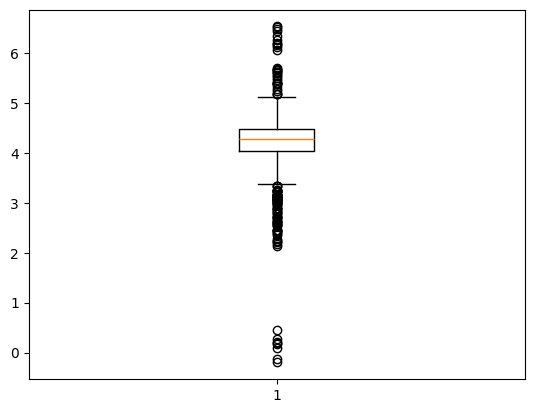

1.2. Доля средств населения


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


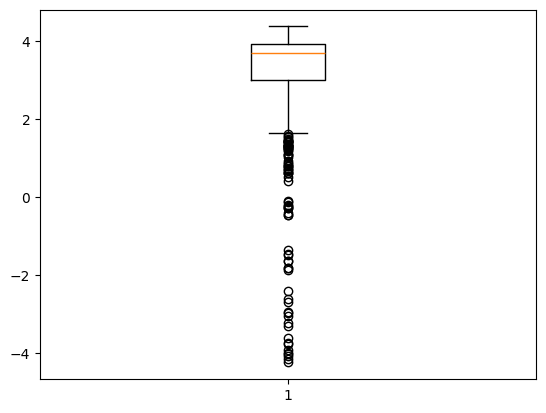

1.3. Надежность банка


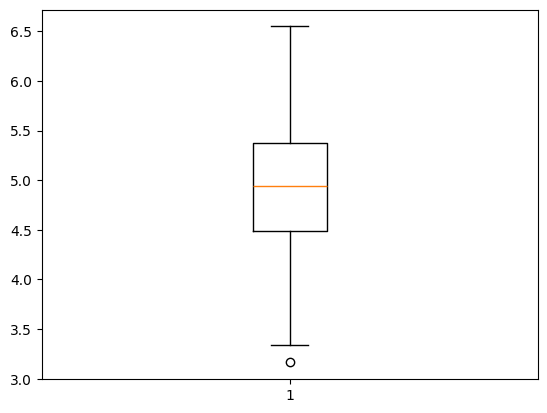

1.4. Норматив мгновенной ликвидности


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


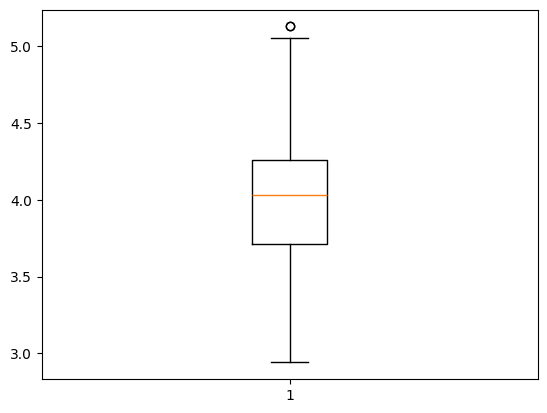

1.5. Норматив текущей ликвидности


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


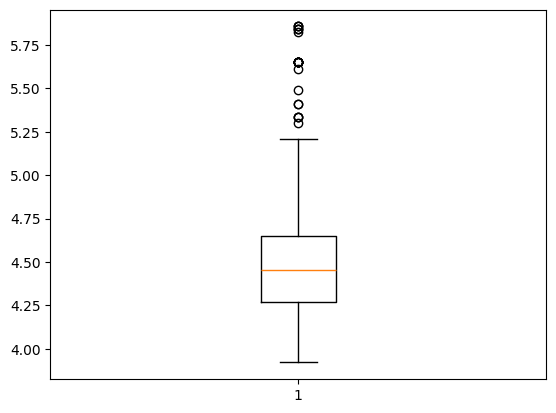

2.1. Достаточность собственных средств


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


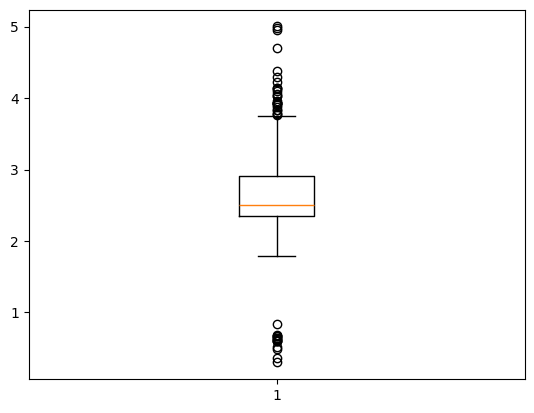

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


2.2. Достаточность основного капитала


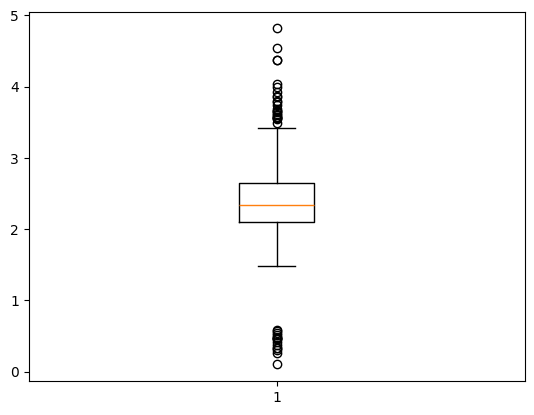

2.3. Устойчивость капитала


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: invalid value encountered in log
  plt.boxplot(np.log(data_col))


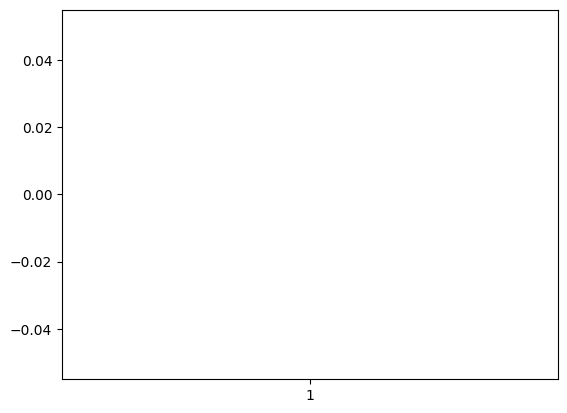

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


2.4. Доля основного капитала в общем капитале


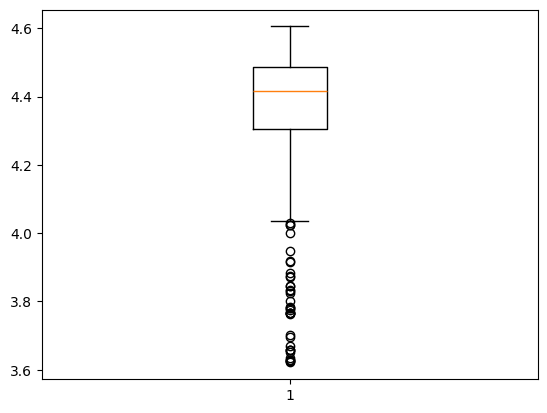

3.1. ROE


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: invalid value encountered in log
  plt.boxplot(np.log(data_col))


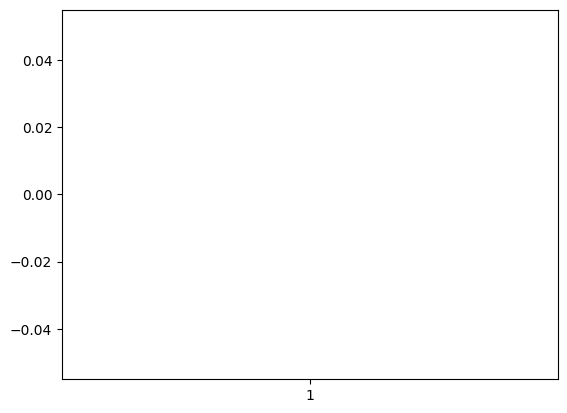

3.2. ROA


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: invalid value encountered in log
  plt.boxplot(np.log(data_col))


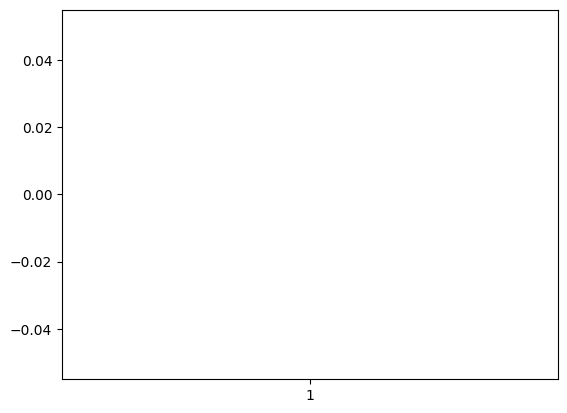

4.1. Коэффициент процентных доходов


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


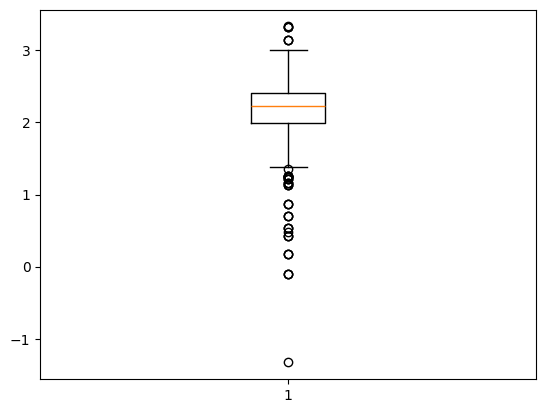

4.2. Коэффициент процентных расходов


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


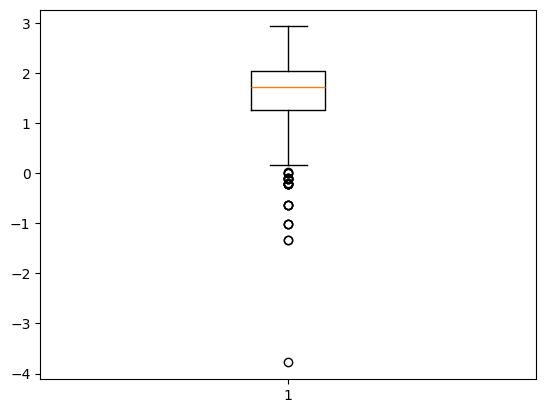

4.3. Доля операционных расходов в доходах


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


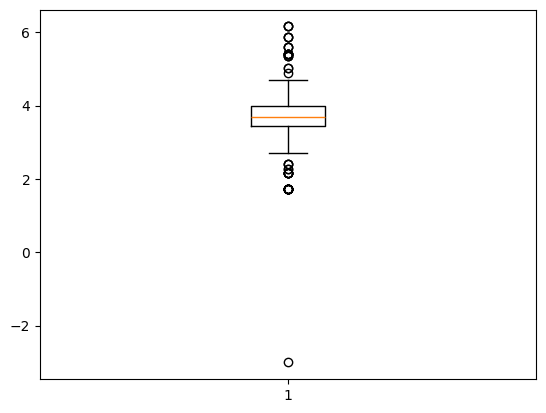

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: invalid value encountered in log
  plt.boxplot(np.log(data_col))


5.1. Прирост кредитов


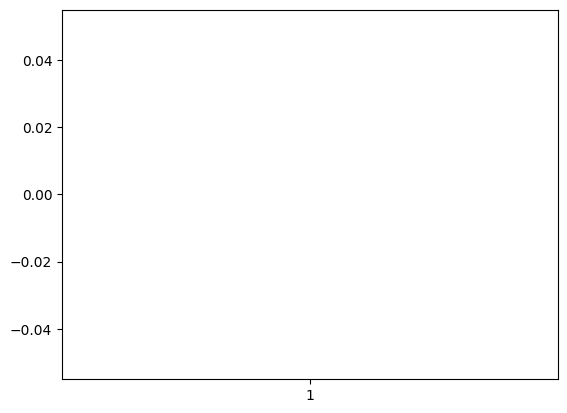

5.2. Уровень просроченной задолженности


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


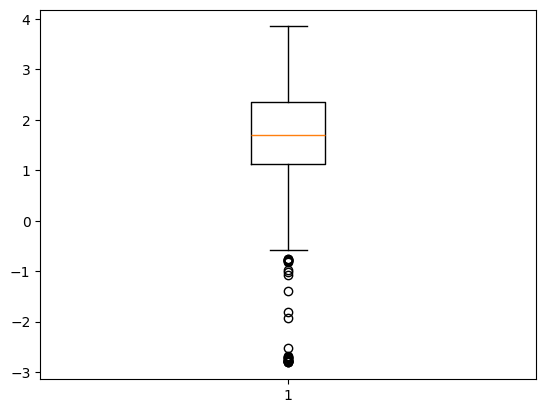

5.3. Отношение NPL к Капиталу  (1.2)


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


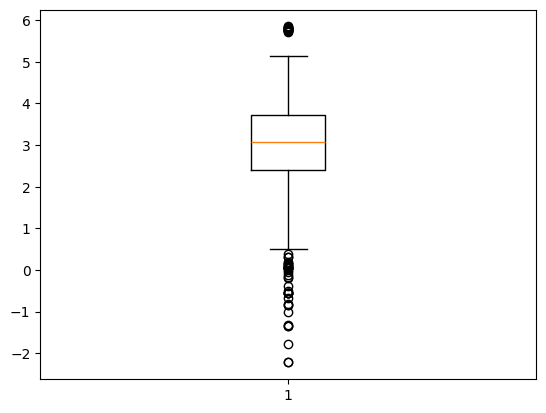

5.4. Коэффициент резервирования


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


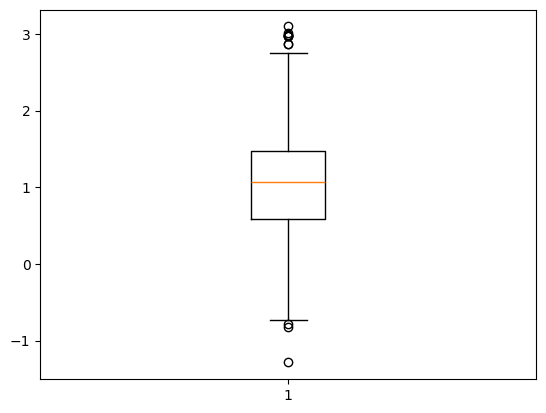

5.5. Стоимость риска


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: invalid value encountered in log
  plt.boxplot(np.log(data_col))


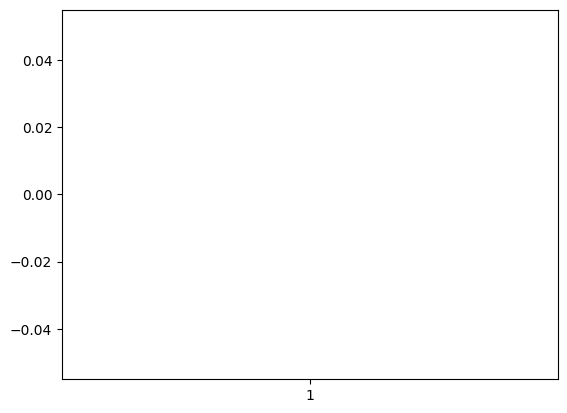

Доля рынка_0.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


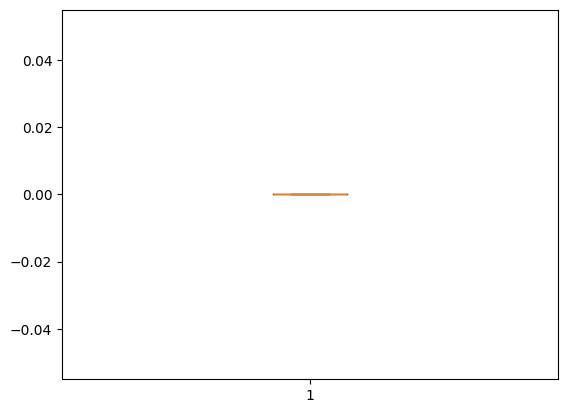

Доля рынка_0.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


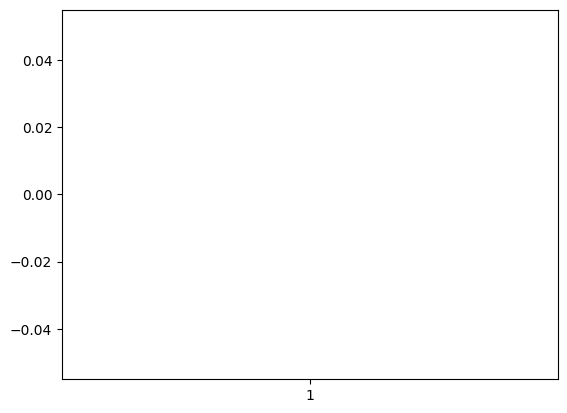

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Доля рынка_1.0


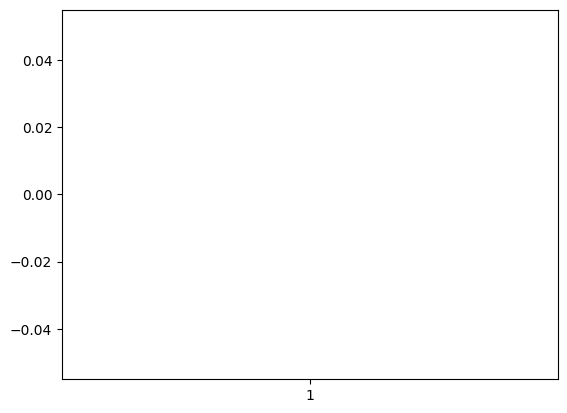

Доля рынка_2.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


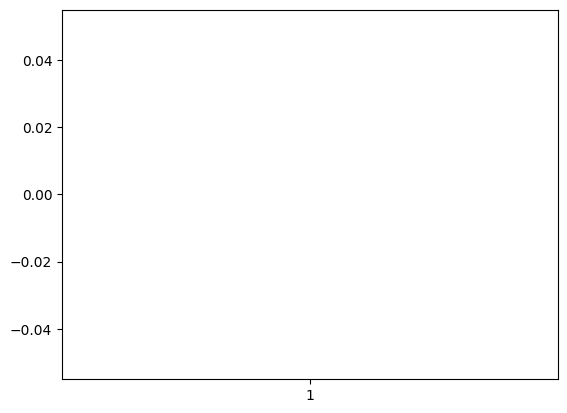

Доля рынка_3.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


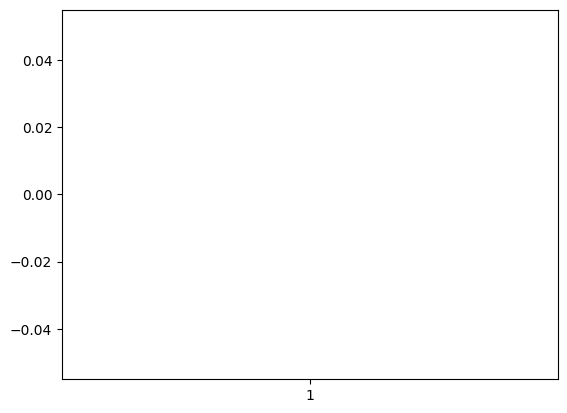

Доля рынка_4.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


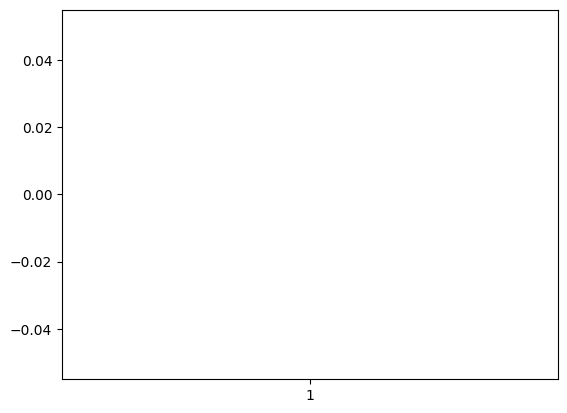

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Доля рынка_5.0


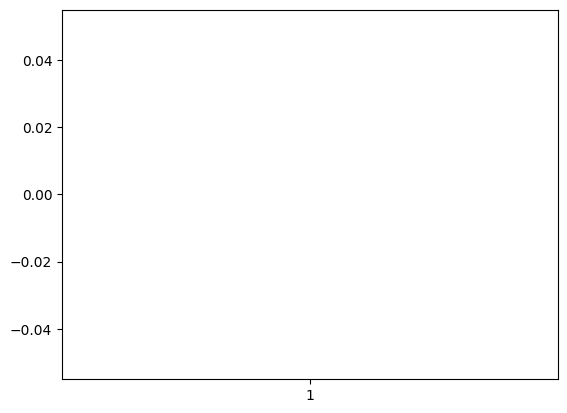

Стабильность доли рынка_0.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


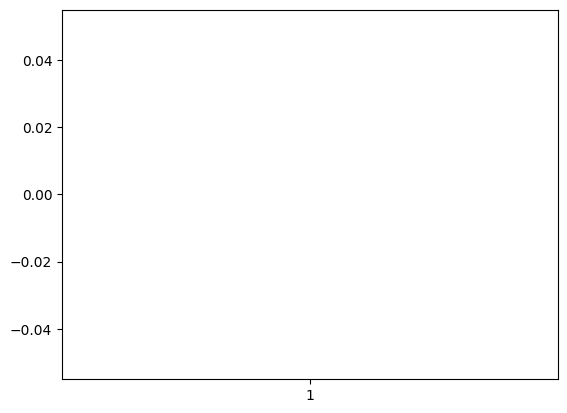

Стабильность доли рынка_0.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


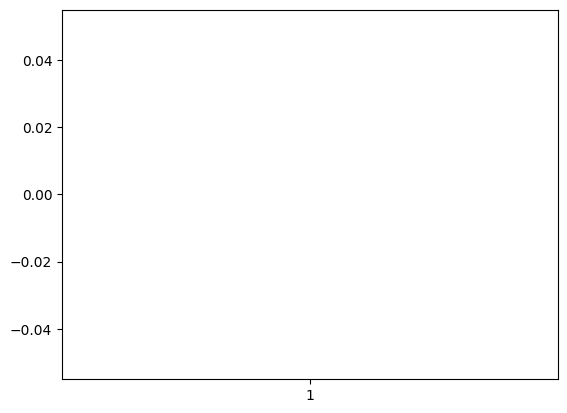

Стабильность доли рынка_1.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


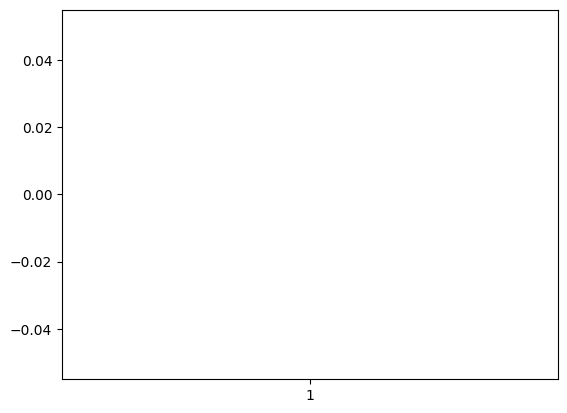

Стабильность доли рынка_1.2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


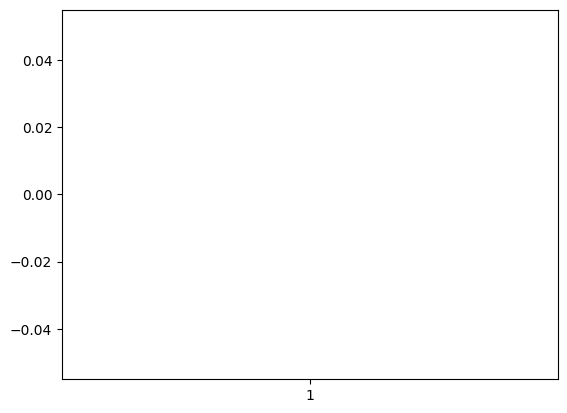

Стабильность доли рынка_1.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


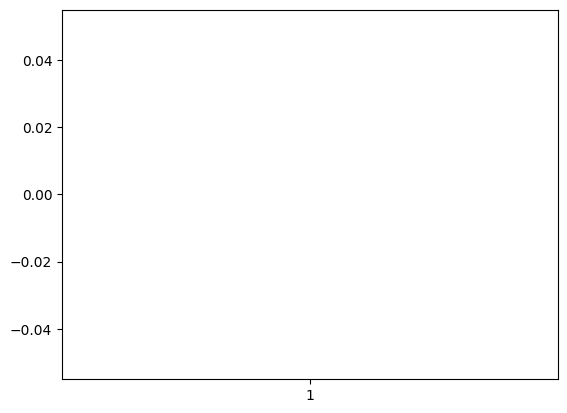

Стабильность доли рынка_1.8


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


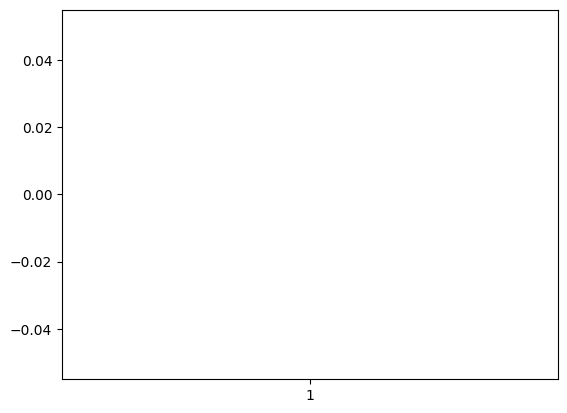

Стабильность доли рынка_2.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


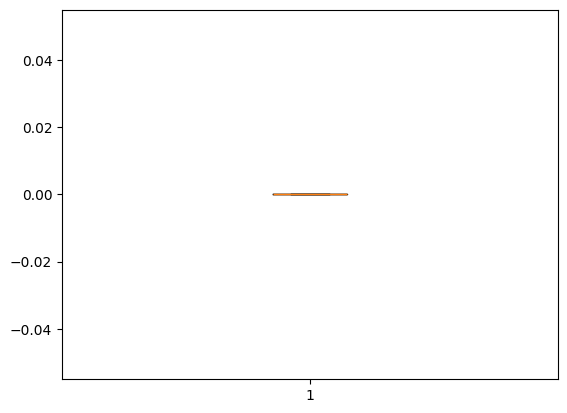

Отклонение темпов роста_0.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


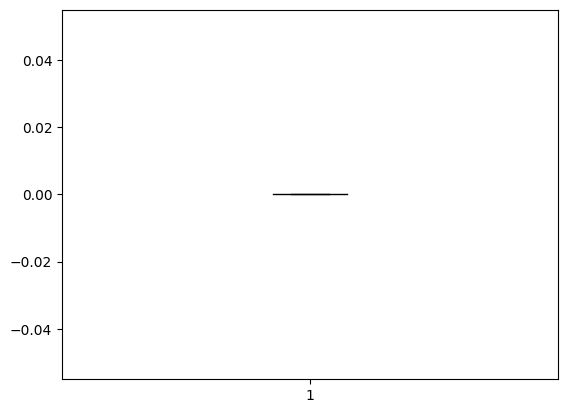

Отклонение темпов роста_0.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


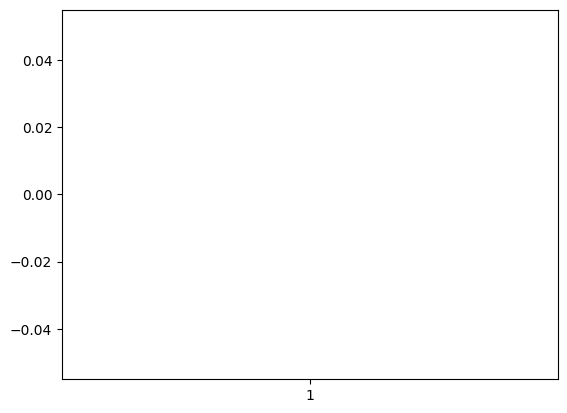

Отклонение темпов роста_1.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


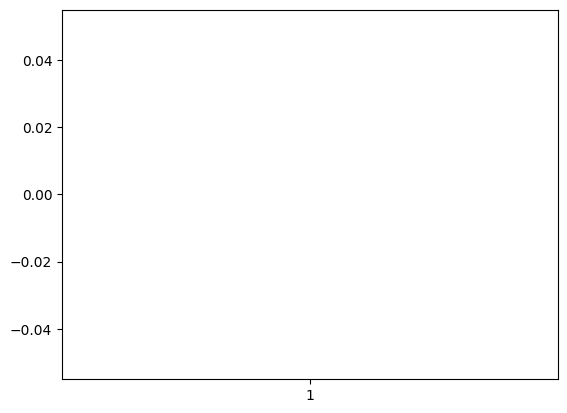

Отклонение темпов роста_1.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


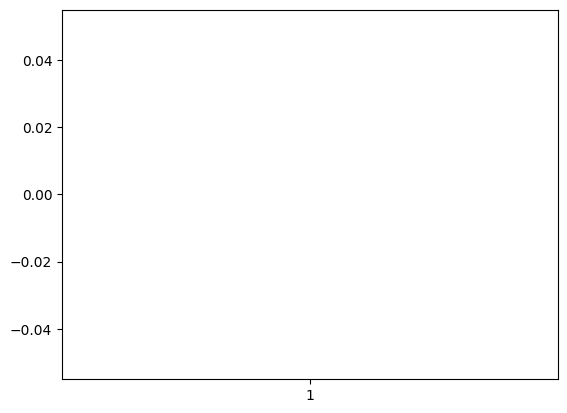

Отклонение темпов роста_2.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


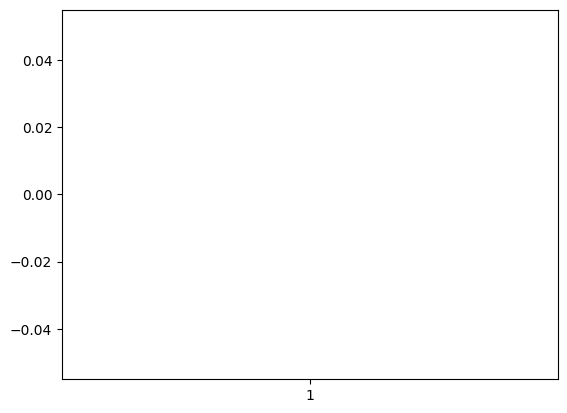

Отклонение темпов роста_2.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


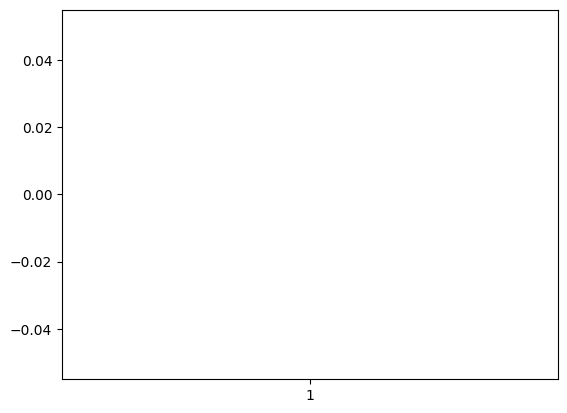

Отклонение темпов роста_3.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


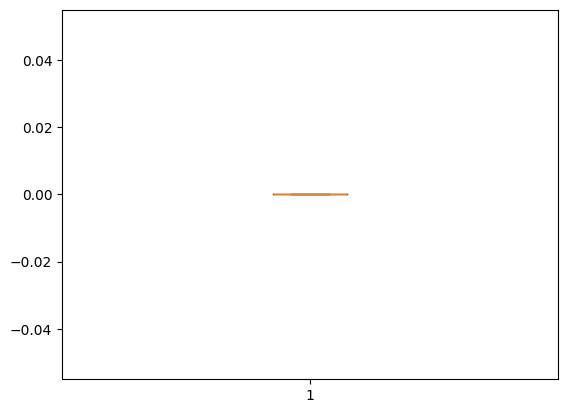

Диверсификация дохода_0.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


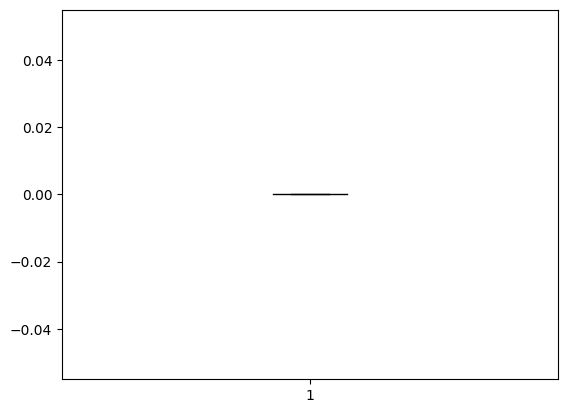

Диверсификация дохода_0.6


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


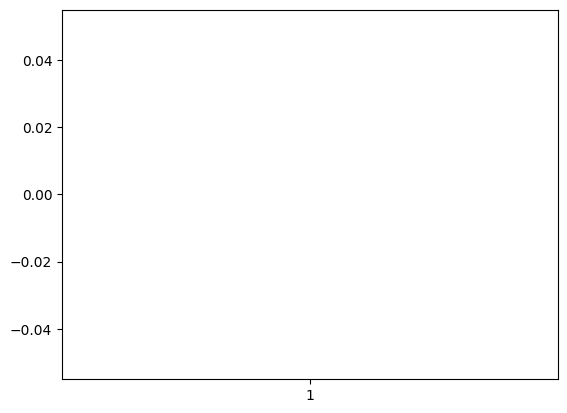

Диверсификация дохода_1.2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


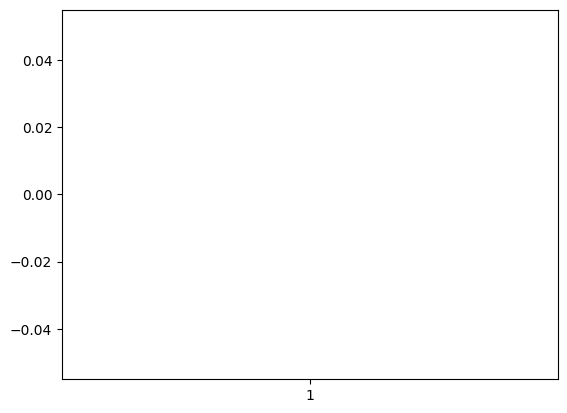

Диверсификация дохода_1.8


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


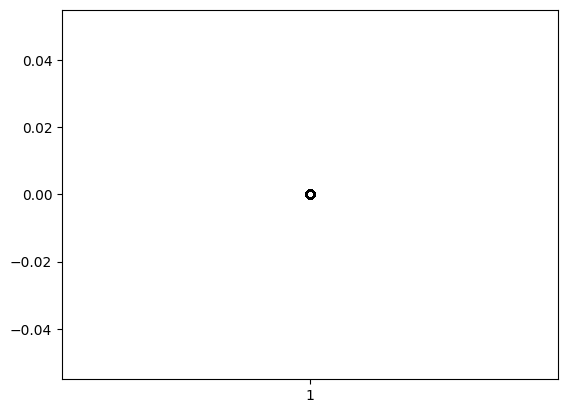

Диверсификация дохода_2.4


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


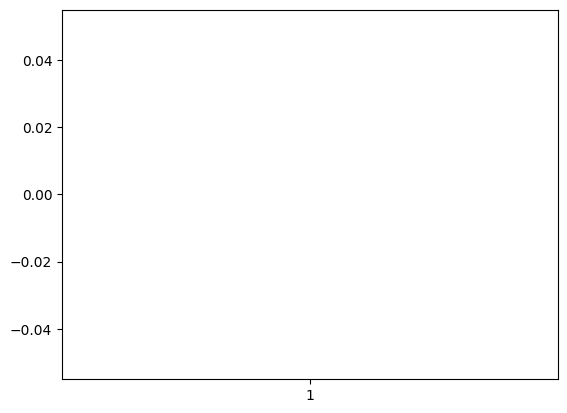

Диверсификация дохода_3.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


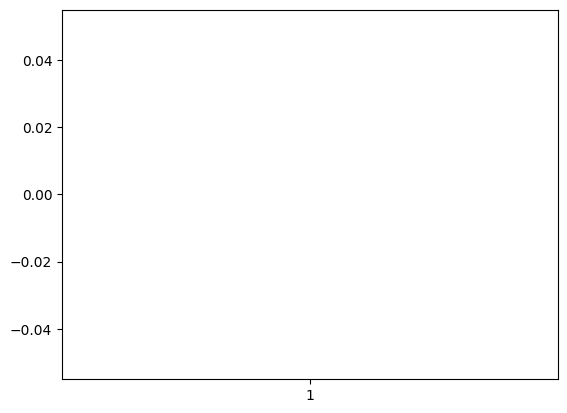

География присутствия_0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


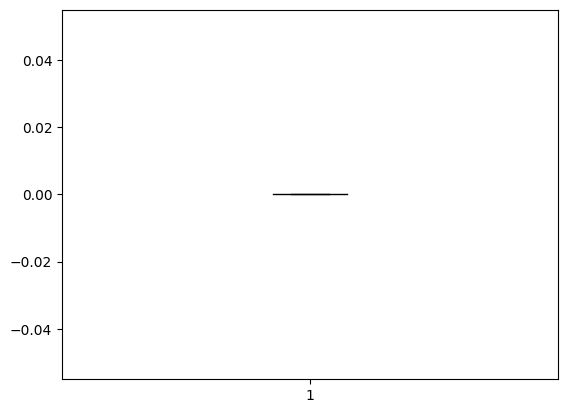

География присутствия_1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


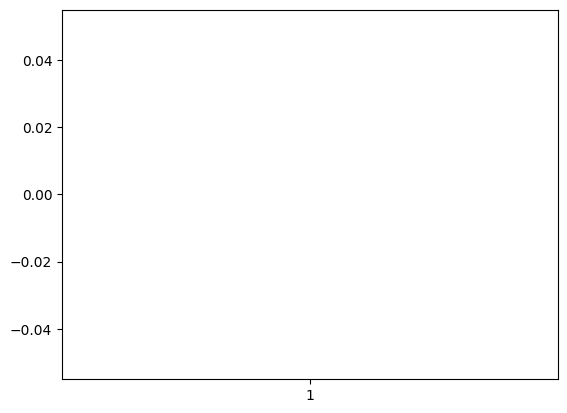

География присутствия_2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


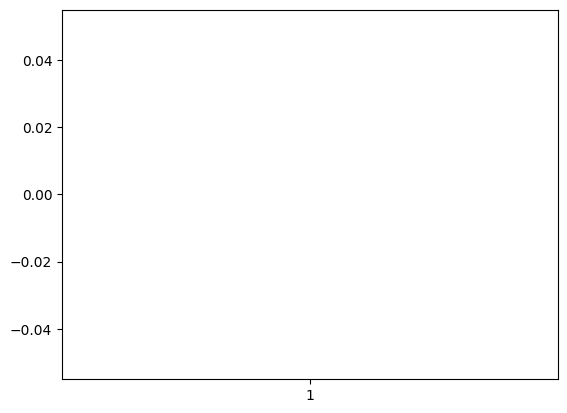

География присутствия_3


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


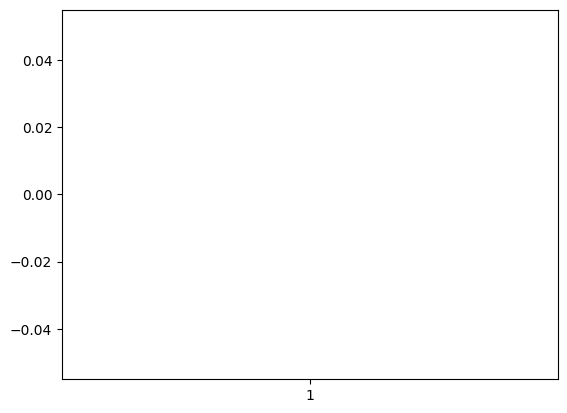

География присутствия_4


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


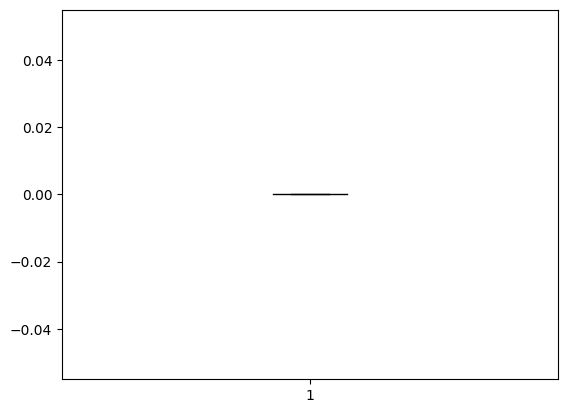

Структура собственности_-1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


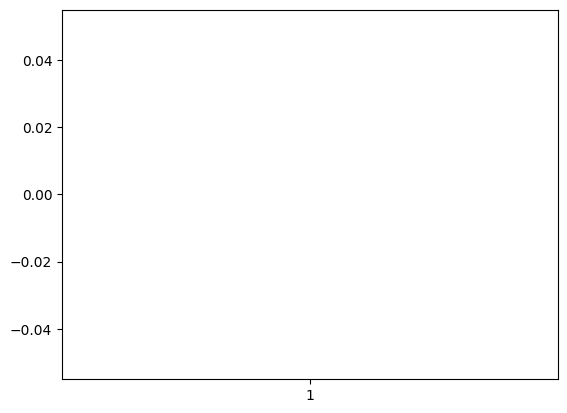

Структура собственности_1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


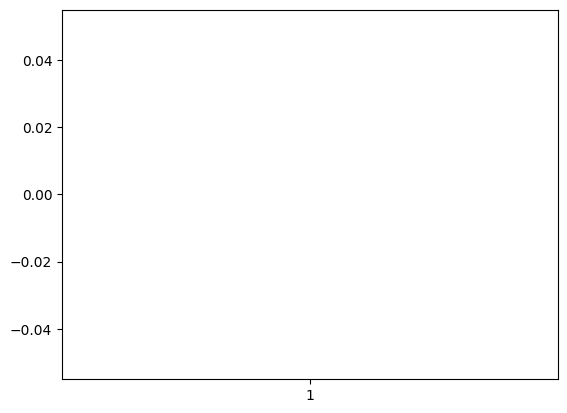

Структура собственности_2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))


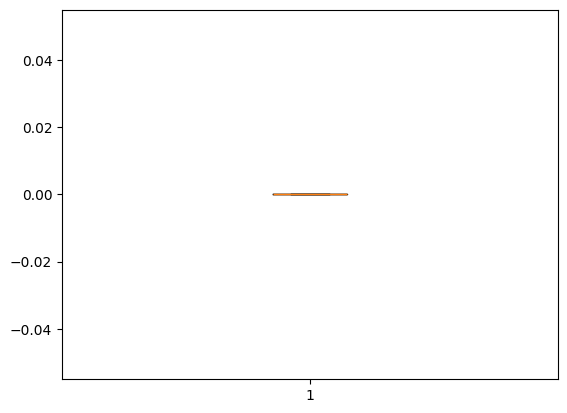

Доля государства_0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


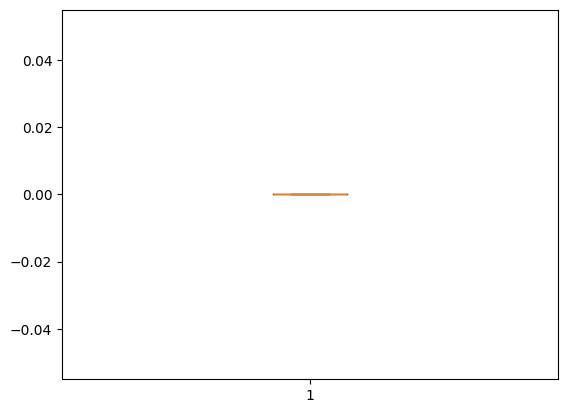

Доля государства_1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


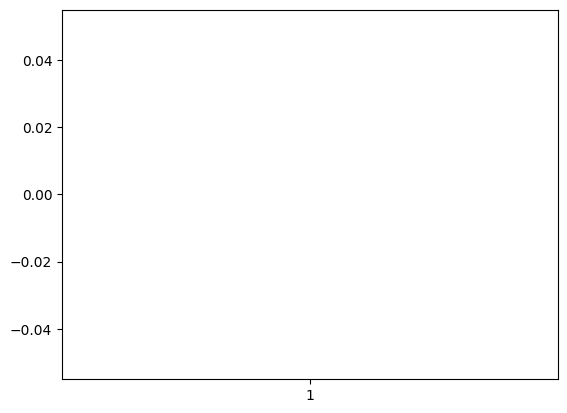

Доля государства_2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


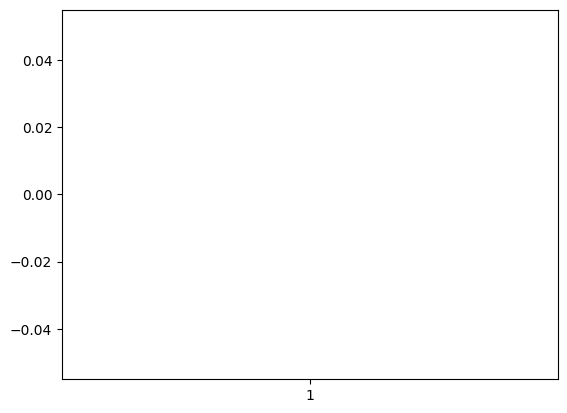

Доля государства_3


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


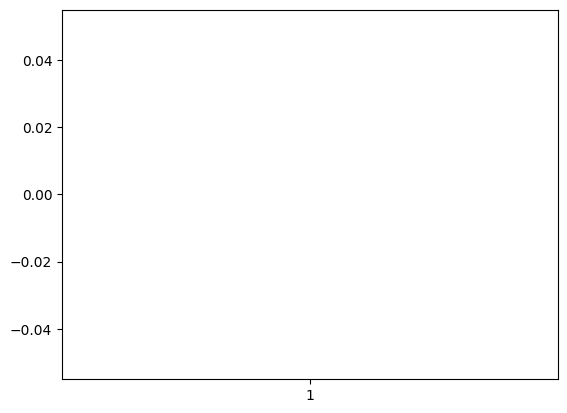

Доля государства_4


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


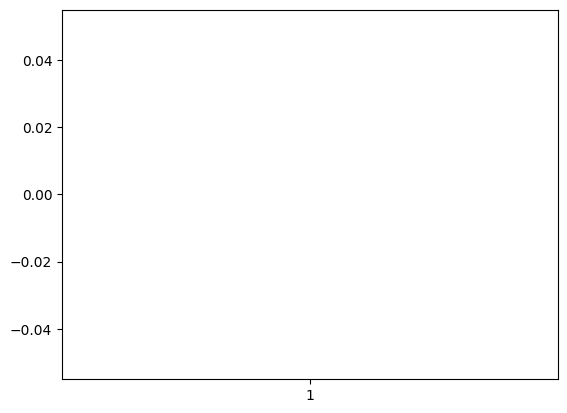

Доля государства_5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


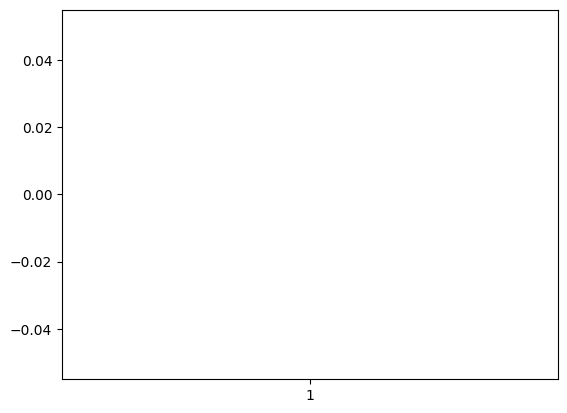

Частные акционеры_0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


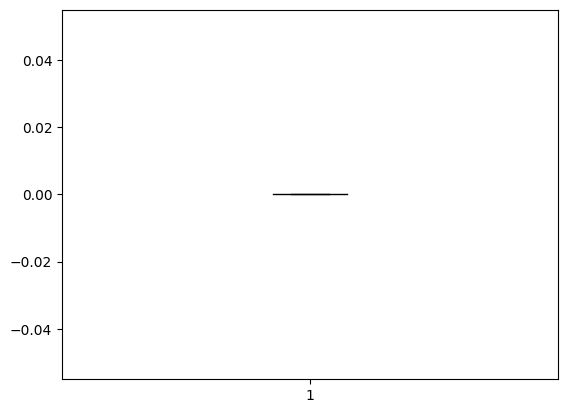

Частные акционеры_1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


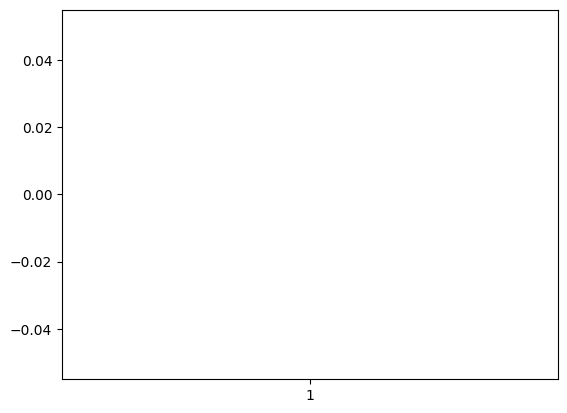

Частные акционеры_2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


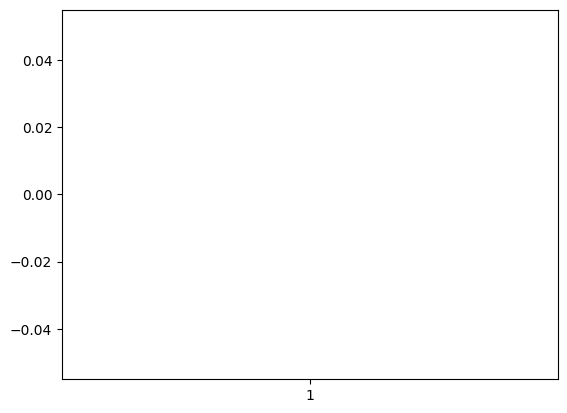

Частные акционеры_3


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


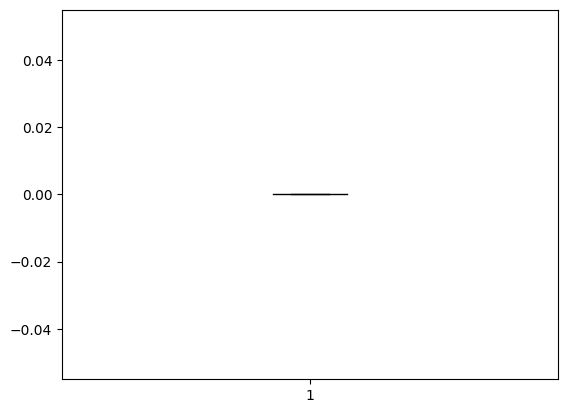

Качество управления_-3.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


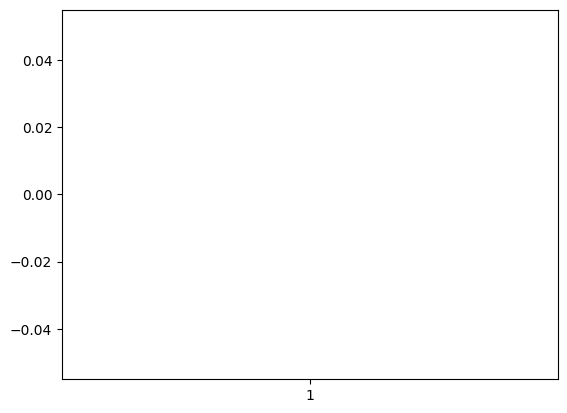

Качество управления_-1.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


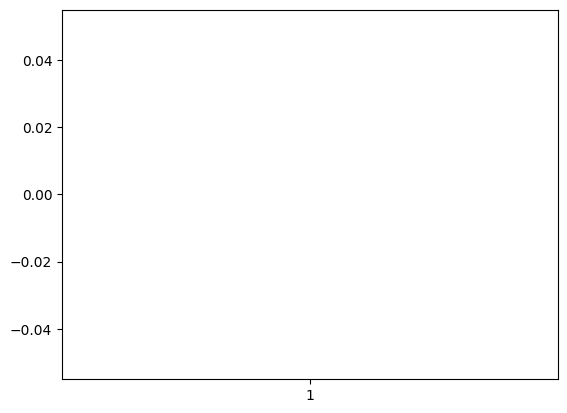

Качество управления_0.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


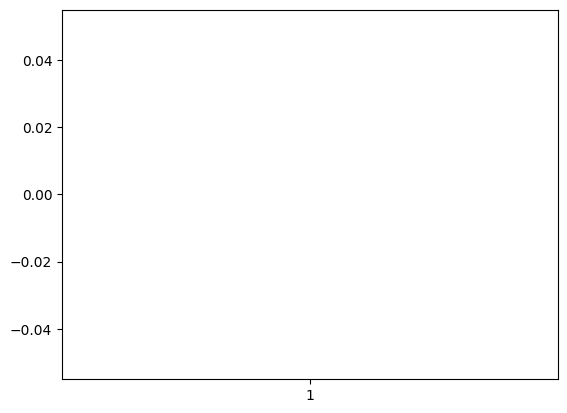

Качество управления_1.5


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


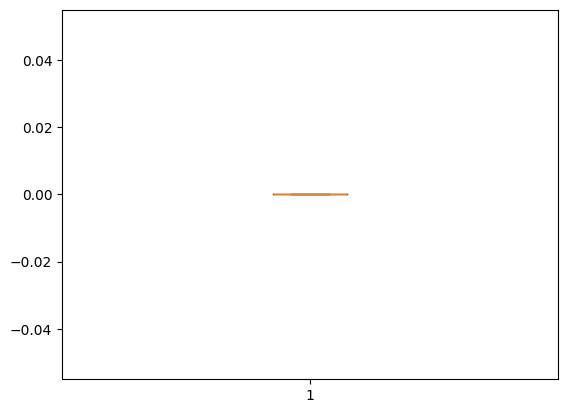

Качество управления_3.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


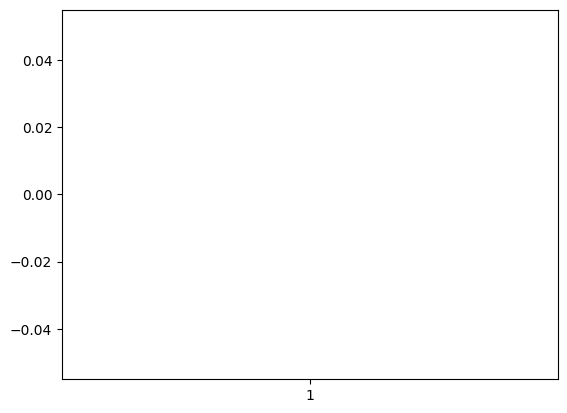

Деловая репутация_-1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


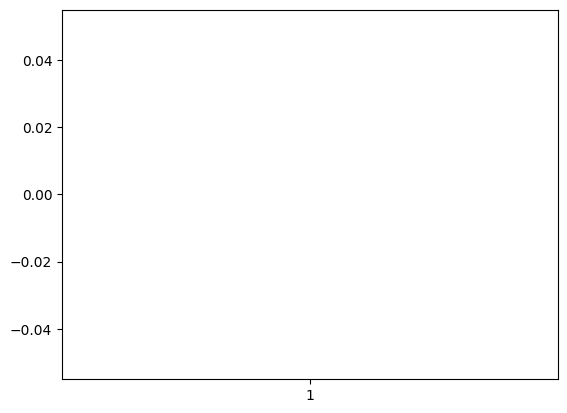

Деловая репутация_0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


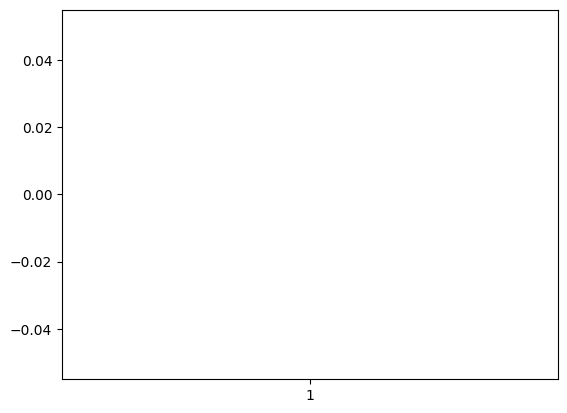

Деловая репутация_1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


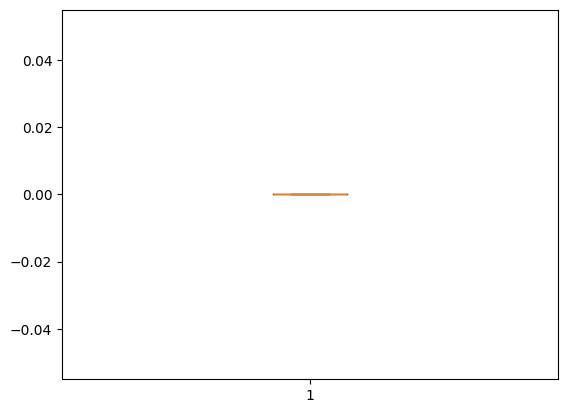

Деловая репутация_2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


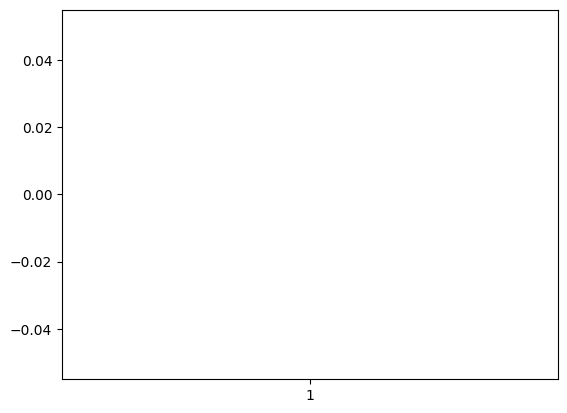

Связанность операций с бизнесом_0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


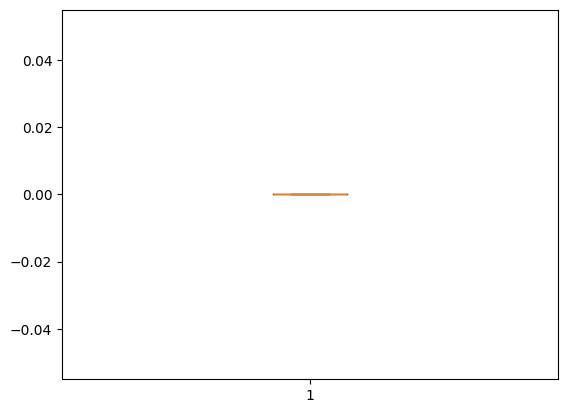

Связанность операций с бизнесом_1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


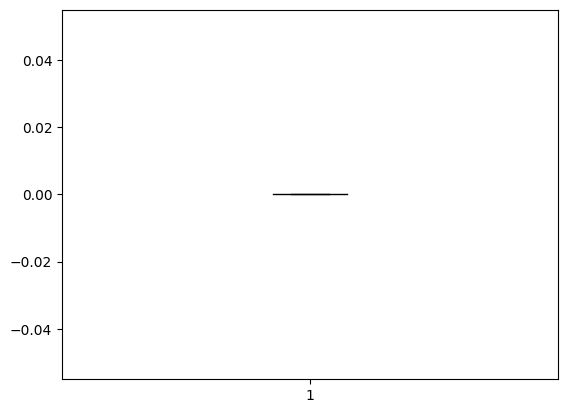

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Связанность операций с бизнесом_2


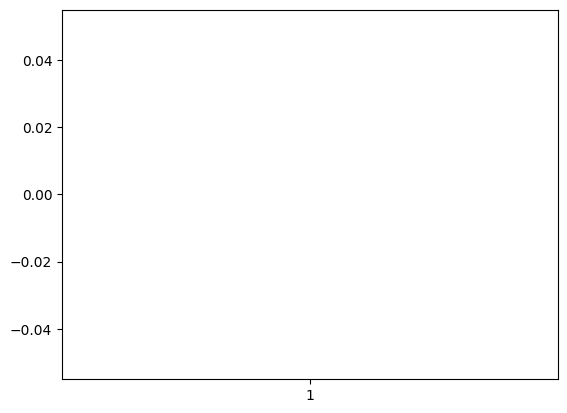

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Отчетность МСФО_0


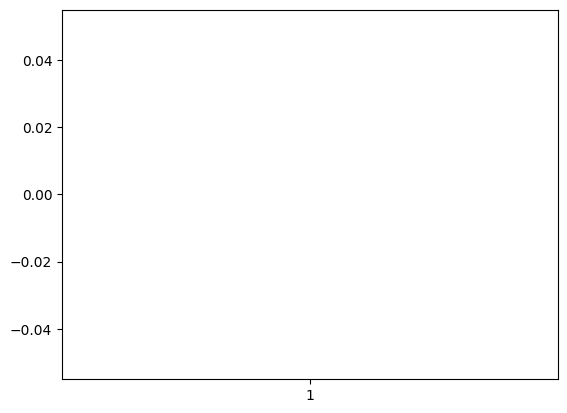

Отчетность МСФО_1


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


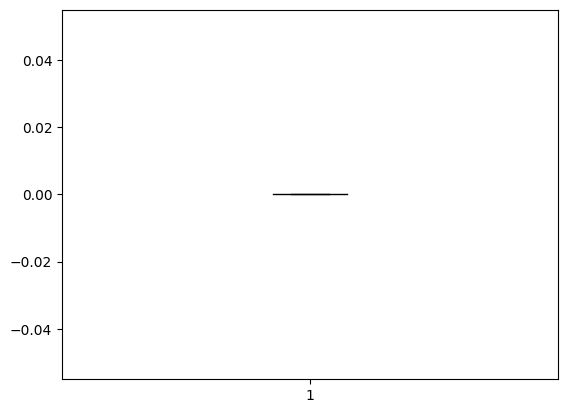

Отчетность МСФО_2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


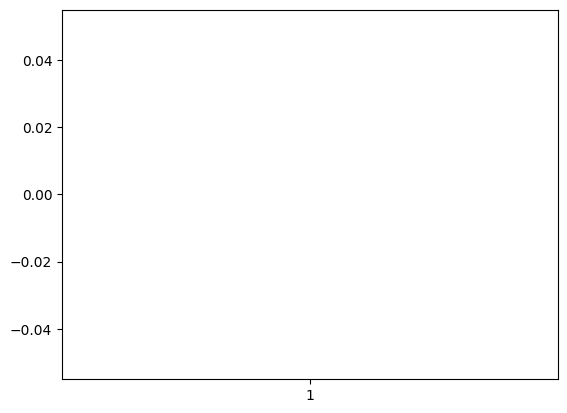

Отчетность МСФО_3


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


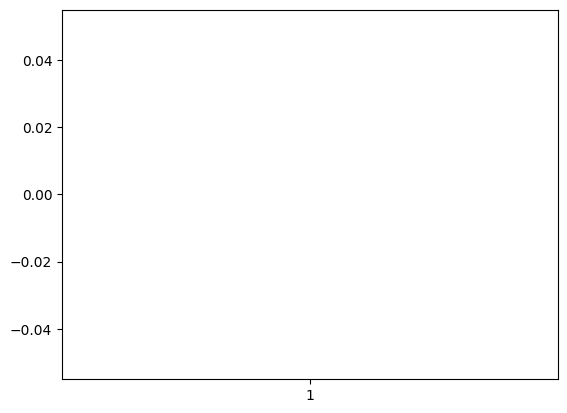

Отчетность МСФО_4


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


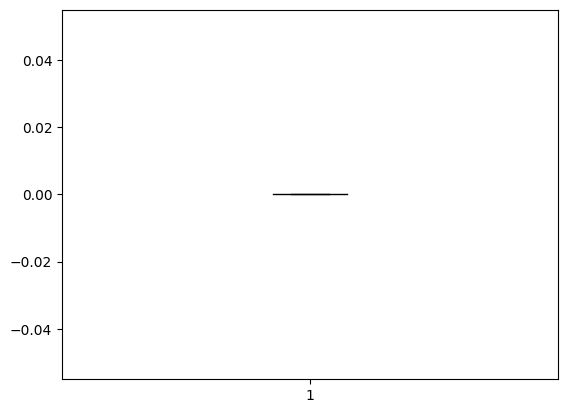

Рейтинги НРА_0.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


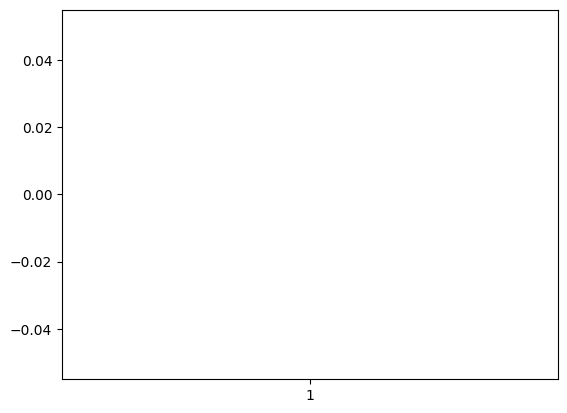

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Рейтинги НРА_2.5


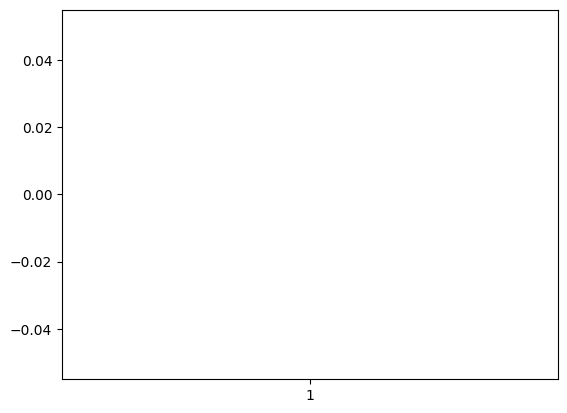

Рейтинги НРА_4.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


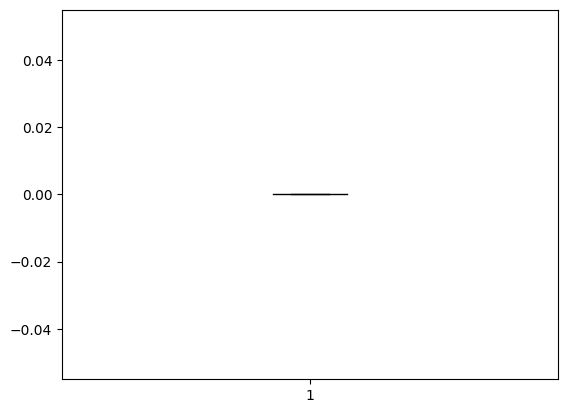

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Рейтинги НРА_5.0


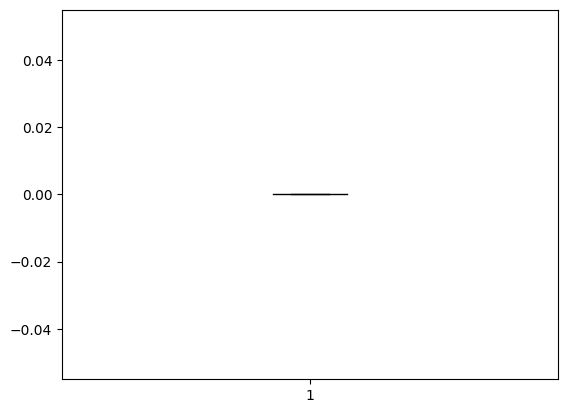

Количество рейтингов НРА (баллы)_1.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


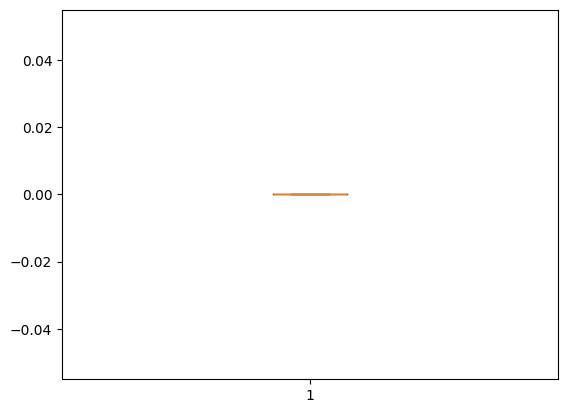

Количество рейтингов НРА (баллы)_1.2


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


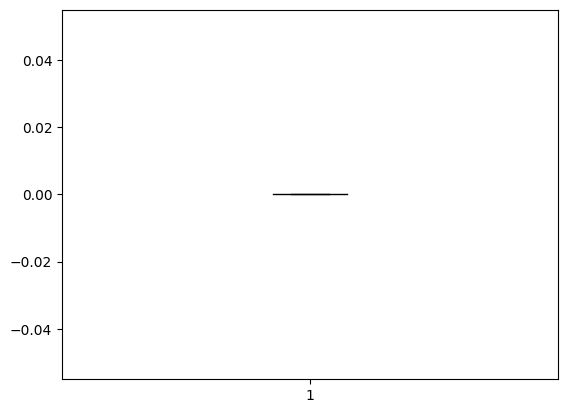

Количество рейтингов НРА (баллы)_2.0


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


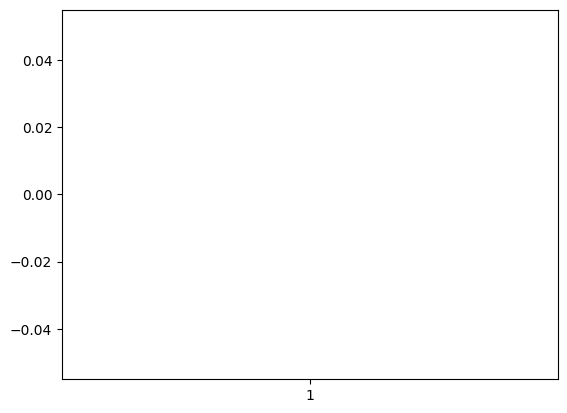

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Прогноз по рейтингам НРА_0.0


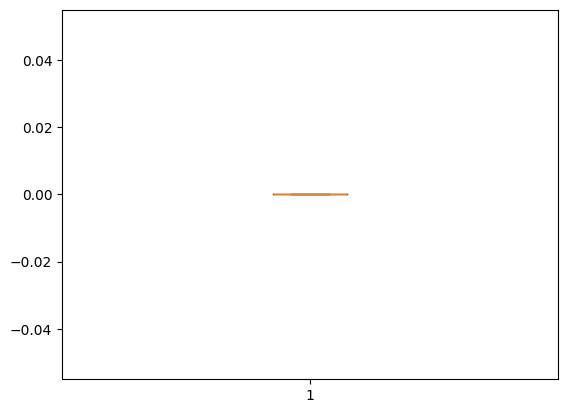

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Прогноз по рейтингам НРА_1.2


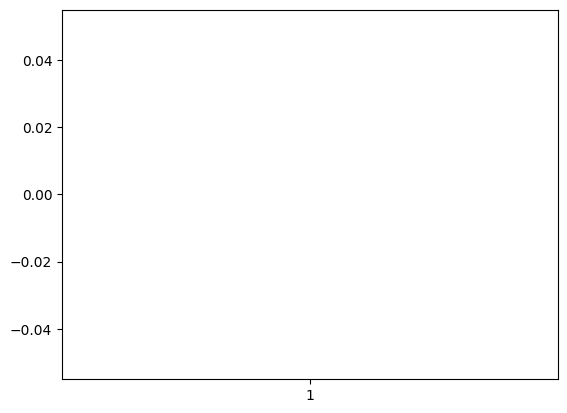

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Прогноз по рейтингам НРА_2.0


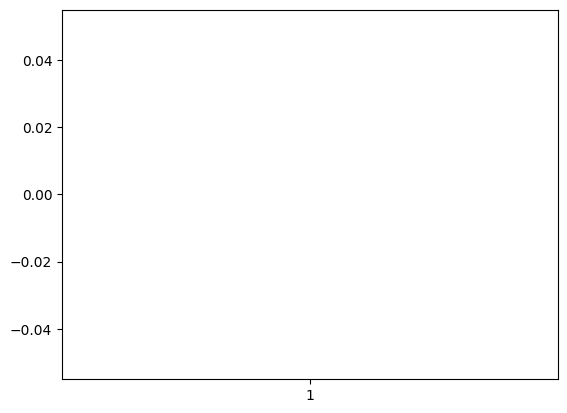

C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


ПОДДЕРЖКА МАКСИМУМ_0


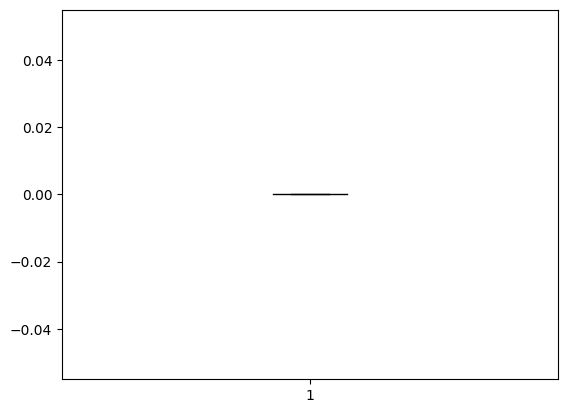

ПОДДЕРЖКА МАКСИМУМ_8


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


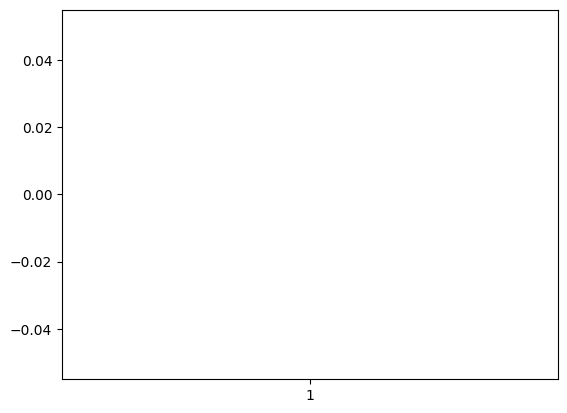

ПОДДЕРЖКА МАКСИМУМ_10


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


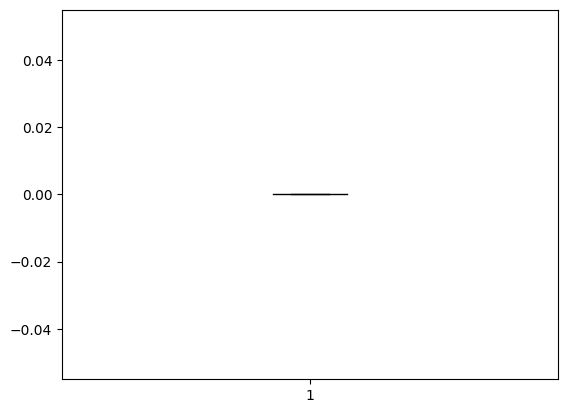

ПОДДЕРЖКА МАКСИМУМ_16


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


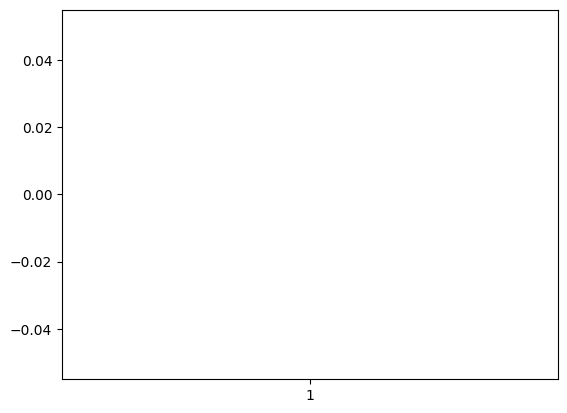

ПОДДЕРЖКА МАКСИМУМ_20


C:\Users\mikhe\AppData\Local\Temp\ipykernel_12772\1934687377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.boxplot(np.log(data_col))
C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


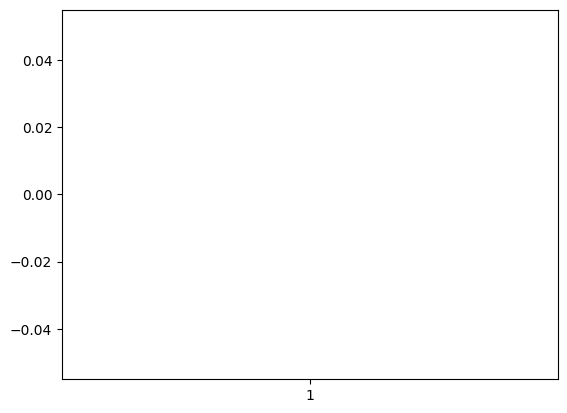

In [53]:
for col in df_cat_drop_train.columns:
    data_col = df_cat_drop_train[col].values
    print(col)
    plt.boxplot(np.log(data_col))
    plt.show()

# Каппа Коэна

In [33]:
# веса(кэфы), бизнес первые 5 строк, 6 строка поддержка, 5 последние строк финансовые
w =    [0,0.5,1,2,3,4,5, 0,0.5,1,1.2,1.5,1.8,2, 0,0.5,1,1.5,2,2.5,3, # стабильность бизнеса
        0,0.6,1.2,1.8,2.4,3,  0,1,2,3,4, # диверсификация
        -1,1,2, 0,1,2,3,4,5, 0,1,2,3, -3,-1.5,0,1.5,3, -1,0,1,2, 0,1,2,# корпоративное управление и репа
        0,1,2,3,4, # отчетность МСФО
        0,2.5,4,5, 1,1.2,2, 0,1.2,2,# рейтинги
        0,8,10,16,20, # макс поддержка (15 б)
        # фин (45 б)
        ]
w_fin = np.random.random(size=19)
w = np.asarray(w)
w = np.append(w_fin, w)

In [34]:
# Функция для minimize 
def funcn(ww):
    ww = ww.reshape(-1, 1)
    # Делаем предикт
    y_pred = np.dot(df_train, ww)
    # Соотносим к классам
    y_pred = score_cat(y_pred)
    # Каппа Коэна. Значение равное 1 говорит о полном согласии, 0 - о согласии на уровне рандомайзера, -1 об отрицательном результате
    k_cohen = cohen_kappa_score(y_train, y_pred)
    # Умножим на -1 для минимизации нашей функции
    # k_cohen = -k_cohen
    return 1/(k_cohen + 0.00000001)

In [35]:
# bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
y_train = score_cat(external_train)
resg = spop.minimize(funcn, w)
print(resg.fun)

100000000.0


In [36]:
# Сохраняем
weight_kohen = resg.x.reshape(-1, 1)
np.savetxt('weights_kohen.csv', weight_kohen)

In [37]:
# Делаем предикт
y_pred = np.dot(df_train, weight_kohen)
# Соотносим к классам
y_pred = score_cat(y_pred)

accuracy = accuracy_score(y_train, y_pred)
print(accuracy)

0.085995085995086


In [38]:
y_test = score_cat(external_test)
# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Создание кастомной метрики на основе каппы Коэна
kappa_scorer = make_scorer(cohen_kappa_score)

# Оценка модели с использованием кросс валидации
scores = cross_val_score(clf, df_train, y_train, cv=5, scoring=kappa_scorer)
print(f"Результаты кросс валидации: {scores}")
print(f"Среднее: {scores.mean()}")

# Обучение модели и предсказание
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

# Оценка модели на тестовой выборке
kappa_score = cohen_kappa_score(y_test, y_pred)
print(f"На тестовом: {kappa_score}")

Результаты кросс валидации: [0.87035482 0.87811744 0.9353032  0.95700721 0.80489763]
Среднее: 0.8891360602705909
На тестовом: 0.8300095817794536


In [39]:
# Функция для расчета коэффициента Кендалла
def kendall_tau(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

# Создание кастомной метрики на основе коэффициента Кендалла
kendall_scorer = make_scorer(kendall_tau)

# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Оценка модели с использованием кросс-валидации
scores = cross_val_score(clf, df_train, y_train, cv=5, scoring=kendall_scorer)
print(f"Результаты кросс-валидации: {scores}")
print(f"Среднее: {scores.mean()}")

# Обучение модели и предсказание
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

# Оценка модели на тестовой выборке с использованием коэффициента Кендалла
kendall_score = kendall_tau(y_test, y_pred)
print(f"На тестовом: {kendall_score}")

Результаты кросс-валидации: [0.95115701 0.95329666 0.98199526 0.98725136 0.92738982]
Среднее: 0.9602180221042534
На тестовом: 0.9493659644721308


In [40]:
# Получение значимости признаков
feature_importances = clf.feature_importances_

# Создание датафрейма для удобного отображения
feature_importances_df = pd.DataFrame({
    'Feature': df_cat_drop_train.columns,
    'Importance': feature_importances
})

# Сортировка признаков по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Вывод значимых признаков
print(feature_importances_df)

                        Feature  Importance
84             Рейтинги НРА_5.0    0.131051
1   1.2. Доля средств населения    0.112997
83             Рейтинги НРА_4.0    0.083278
60          Частные акционеры_0    0.082073
63          Частные акционеры_3    0.045031
..                          ...         ...
38  Отклонение темпов роста_2.5    0.000000
37  Отклонение темпов роста_2.0    0.000000
36  Отклонение темпов роста_1.5    0.000000
35  Отклонение темпов роста_1.0    0.000000
95        ПОДДЕРЖКА МАКСИМУМ_20    0.000000

[96 rows x 2 columns]


## Только финансы

In [41]:
df_train = df_cat_drop_train[df_cat_drop_train.columns[:19]].values
df_test = df_cat_drop_test[df_cat_drop_test.columns[:19]].values

# Функция для расчета коэффициента Кендалла
def kendall_tau(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

# Создание кастомной метрики на основе коэффициента Кендалла
kendall_scorer = make_scorer(kendall_tau)

# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Оценка модели с использованием кросс-валидации
scores = cross_val_score(clf, df_train, y_train, cv=5, scoring=kendall_scorer)
print(f"Результаты кросс-валидации: {scores}")
print(f"Среднее: {scores.mean()}")

# Обучение модели и предсказание
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

# Оценка модели на тестовой выборке с использованием коэффициента Кендалла
kendall_score = kendall_tau(y_test, y_pred)
print(f"На тестовом: {kendall_score}")

Результаты кросс-валидации: [0.74896681 0.79962558 0.9479718  0.76791576 0.69592108]
Среднее: 0.7920802058440558
На тестовом: 0.5042623856940228


In [42]:
# Получение значимости признаков
feature_importances = clf.feature_importances_

# Создание датафрейма для удобного отображения
feature_importances_df = pd.DataFrame({
    'Feature': df_cat_drop_train.columns[:19],
    'Importance': feature_importances
})

# Сортировка признаков по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Вывод значимых признаков
print(feature_importances_df)

                                          Feature  Importance
11            4.1. Коэффициент процентных доходов    0.139134
15        5.2. Уровень просроченной задолженности    0.136316
1                     1.2. Доля средств населения    0.127536
17                5.4. Коэффициент резервирования    0.113516
16           5.3. Отношение NPL к Капиталу  (1.2)    0.110107
14                          5.1. Прирост кредитов    0.072110
0       1.1. Отношение кредитов к депозитам (LDR)    0.068259
7                      2.3. Устойчивость капитала    0.041043
5          2.1. Достаточность собственных средств    0.035510
8   2.4. Доля основного капитала в общем капитале    0.035391
4               1.5. Норматив текущей ликвидности    0.034476
3            1.4. Норматив мгновенной ликвидности    0.030324
18                           5.5. Стоимость риска    0.023773
9                                        3.1. ROE    0.011686
10                                       3.2. ROA    0.006043
13      

### Проверяем незначимые параметры

In [ ]:
2.2. Достаточность основного капитала

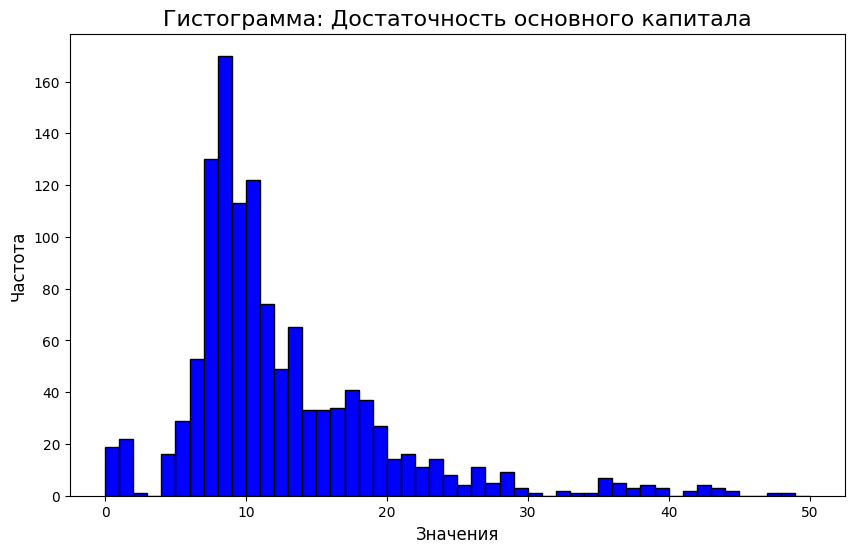

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(df_cat_drop['2.2. Достаточность основного капитала'], bins=50, range=(0, 50), color='blue', edgecolor='black')


# Добавление заголовка и меток осей
plt.title('Гистограмма: Достаточность основного капитала', fontsize=16)
plt.xlabel('Значения', fontsize=12)
plt.ylabel('Частота', fontsize=12)

# Показ графика
plt.show()

In [55]:
df_category['External_rating'].corr(df_category['2.2. Достаточность основного капитала'])

-0.19586915171564562

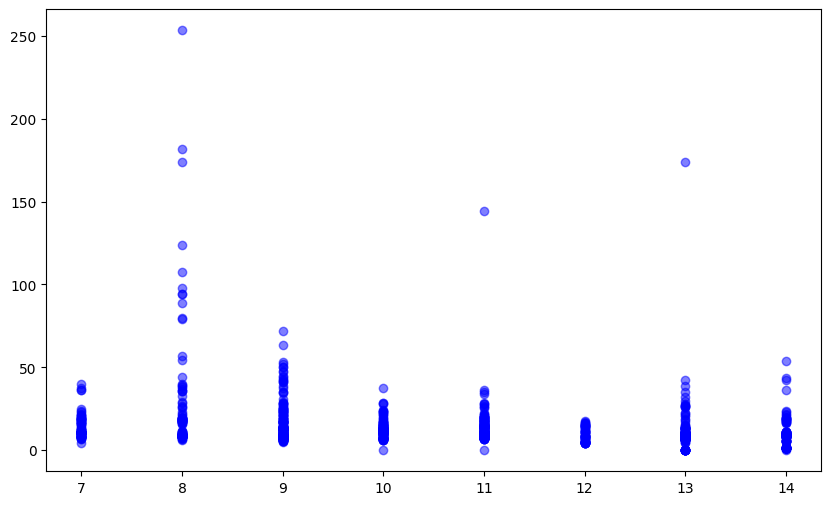

In [58]:
# Построение графика рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(score_cat(df_category['External_rating']), df_category['2.2. Достаточность основного капитала'], color='blue', alpha=0.5)


# Показать график
plt.show()

Вывод: тенденций не найдено, можно исключать "2.2. Достаточность основного капитала"

In [78]:
feature_importances_df[:30]

Feature  Importance
84                           Рейтинги НРА_5.0    0.131051
1                 1.2. Доля средств населения    0.112997
83                           Рейтинги НРА_4.0    0.083278
60                        Частные акционеры_0    0.082073
63                        Частные акционеры_3    0.045031
5      2.1. Достаточность собственных средств    0.044094
22                             Доля рынка_2.0    0.040480
59                         Доля государства_5    0.039559
66                    Качество управления_0.0    0.035540
14                      5.1. Прирост кредитов    0.034898
16       5.3. Отношение NPL к Капиталу  (1.2)    0.033204
53                  Структура собственности_2    0.030672
50                    География присутствия_4    0.029394
77                          Отчетность МСФО_1    0.026622
62                        Частные акционеры_2    0.025109
70                        Деловая репутация_0    0.024648
58                         Доля государства_4    0.023452
40                  Диверсификация дохода_0.0    0.022980
48                    География присутствия_2    0.018399
20                             Доля рынка_0.5    0.017431
6       2.2. Достаточность основного капитала    0.016674
79                          Отчетность МСФО_3    0.013973
15    5.2. Уровень просроченной задолженности    0.011098
13  4.3. Доля операционных расходов в доходах    0.008839
76                          Отчетность МСФО_0    0.008803
54                         Доля государства_0    0.008551
78                          Отчетность МСФО_2    0.007512
44                  Диверсификация дохода_2.4    0.005276
11        4.1. Коэффициент процентных доходов    0.004864
4           1.5. Норматив текущей ликвидности    0.004657

## Через другие методы

In [41]:
from sklearn.inspection import permutation_importance

# Обучаем модель
# clf.fit(df_train, y_train)

# Оценка важности признаков методом перестановок
result = permutation_importance(clf, df_train, y_train, n_repeats=10, random_state=42, scoring=kendall_scorer)

# Создание датафрейма для удобного отображения
permutation_importance_df = pd.DataFrame({
    'Feature': df_cat_drop_train.columns,
    'Importance': result.importances_mean
})

# Сортировка признаков по важности
permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=False)

# Вывод значимых признаков
print(permutation_importance_df)

                        Feature  Importance
84             Рейтинги НРА_5.0    0.565212
83             Рейтинги НРА_4.0    0.141984
60          Частные акционеры_0    0.086333
1   1.2. Доля средств населения    0.080507
63          Частные акционеры_3    0.063017
..                          ...         ...
38  Отклонение темпов роста_2.5    0.000000
37  Отклонение темпов роста_2.0    0.000000
36  Отклонение темпов роста_1.5    0.000000
35  Отклонение темпов роста_1.0    0.000000
95        ПОДДЕРЖКА МАКСИМУМ_20    0.000000

[96 rows x 2 columns]


In [63]:
df_cat_drop.columns

Index(['1.1. Отношение кредитов к депозитам (LDR)',
       '1.2. Доля средств населения', '1.3. Надежность банка',
       '1.4. Норматив мгновенной ликвидности',
       '1.5. Норматив текущей ликвидности',
       '2.1. Достаточность собственных средств',
       '2.2. Достаточность основного капитала', '2.3. Устойчивость капитала',
       '2.4. Доля основного капитала в общем капитале', '3.1. ROE', '3.2. ROA',
       '4.1. Коэффициент процентных доходов',
       '4.2. Коэффициент процентных расходов',
       '4.3. Доля операционных расходов в доходах', '5.1. Прирост кредитов',
       '5.2. Уровень просроченной задолженности',
       '5.3. Отношение NPL к Капиталу  (1.2)',
       '5.4. Коэффициент резервирования', '5.5. Стоимость риска',
       'Доля рынка_0.0', 'Доля рынка_0.5', 'Доля рынка_1.0', 'Доля рынка_2.0',
       'Доля рынка_3.0', 'Доля рынка_4.0', 'Доля рынка_5.0',
       'Стабильность доли рынка_0.0', 'Стабильность доли рынка_0.5',
       'Стабильность доли рынка_1.0', 'Стабил

In [73]:
from sklearn.metrics import accuracy_score
# Функция для расчета коэффициента Кендалла
def kendall_tau(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

# Создание кастомной метрики на основе коэффициента Кендалла
kendall_scorer = make_scorer(kendall_tau)

# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Обучение модели и предсказание
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

# Оценка модели на тестовой выборке с использованием коэффициента Кендалла
baseline_score = kendall_tau(y_test, y_pred)
base_col_name = ''
final_columns = []

for col in df_cat_drop.columns:
    # Исключаем признак и обучаем модель снова
    # Находим все столбцы, которые содержат ту же часть названия до первого подчеркивания или пробела
    if base_col_name != col.split('_')[0]:
        base_col_name = col.split('_')[0]
        feature_to_drop = [c for c in df_cat_drop.columns if c.startswith(base_col_name)]
        
        df_train_dropped = df_cat_drop_train.drop(columns=feature_to_drop)
        df_test_dropped = df_cat_drop_test.drop(columns=feature_to_drop)
        
        clf.fit(df_train_dropped, y_train)
        y_pred_dropped = clf.predict(df_test_dropped)
        new_score = kendall_tau(y_test, y_pred_dropped)
        
        # Оценка влияния признака
        impact = baseline_score - new_score
        if impact > 0:
            final_columns.extend(feature_to_drop)
        print(f"Влияние признака {base_col_name} на модель: {impact}")

Влияние признака 1.1. Отношение кредитов к депозитам (LDR) на модель: -0.003828286457871033
Влияние признака 1.2. Доля средств населения на модель: 0.0032414675846293983
Влияние признака 1.3. Надежность банка на модель: -0.001963002111864176
Влияние признака 1.4. Норматив мгновенной ликвидности на модель: 0.004713570483260265
Влияние признака 1.5. Норматив текущей ликвидности на модель: 0.006285819866766906
Влияние признака 2.1. Достаточность собственных средств на модель: 0.01119223567742833
Влияние признака 2.2. Достаточность основного капитала на модель: -0.009513170620002565
Влияние признака 2.3. Устойчивость капитала на модель: -0.005102096457125338
Влияние признака 2.4. Доля основного капитала в общем капитале на модель: -0.004454546968114426
Влияние признака 3.1. ROE на модель: -0.004454546968114426
Влияние признака 3.2. ROA на модель: -0.004454546968114426
Влияние признака 4.1. Коэффициент процентных доходов на модель: -0.004454546968114426
Влияние признака 4.2. Коэффициент про

In [74]:
final_columns

['1.2. Доля средств населения',
 '1.4. Норматив мгновенной ликвидности',
 '1.5. Норматив текущей ликвидности',
 '2.1. Достаточность собственных средств',
 '4.3. Доля операционных расходов в доходах',
 '5.2. Уровень просроченной задолженности',
 'Стабильность доли рынка_0.0',
 'Стабильность доли рынка_0.5',
 'Стабильность доли рынка_1.0',
 'Стабильность доли рынка_1.2',
 'Стабильность доли рынка_1.5',
 'Стабильность доли рынка_1.8',
 'Стабильность доли рынка_2.0',
 'Отклонение темпов роста_0.0',
 'Отклонение темпов роста_0.5',
 'Отклонение темпов роста_1.0',
 'Отклонение темпов роста_1.5',
 'Отклонение темпов роста_2.0',
 'Отклонение темпов роста_2.5',
 'Отклонение темпов роста_3.0',
 'География присутствия_0',
 'География присутствия_1',
 'География присутствия_2',
 'География присутствия_3',
 'География присутствия_4',
 'Структура собственности_-1',
 'Структура собственности_1',
 'Структура собственности_2',
 'Частные акционеры_0',
 'Частные акционеры_1',
 'Частные акционеры_2',
 'Час

## Нашли более значимые столбцы, оставим только c значимостью больше 0.01

In [54]:
important_cols = feature_importances_df['Feature'].iloc[:23].values

In [55]:
important_cols

array(['Рейтинги НРА_5.0', '1.2. Доля средств населения',
       'Рейтинги НРА_4.0', 'Частные акционеры_0', 'Частные акционеры_3',
       '2.1. Достаточность собственных средств', 'Доля рынка_2.0',
       'Доля государства_5', 'Качество управления_0.0',
       '5.1. Прирост кредитов', '5.3. Отношение NPL к Капиталу  (1.2)',
       'Структура собственности_2', 'География присутствия_4',
       'Отчетность МСФО_1', 'Частные акционеры_2', 'Деловая репутация_0',
       'Доля государства_4', 'Диверсификация дохода_0.0',
       'География присутствия_2', 'Доля рынка_0.5',
       '2.2. Достаточность основного капитала', 'Отчетность МСФО_3',
       '5.2. Уровень просроченной задолженности'], dtype=object)

In [56]:
# Пройтись по всем значимым столбцам
final_columns = []
for col in important_cols:
    # Находим все столбцы, которые содержат ту же часть названия до первого подчеркивания или пробела
    base_col_name = col.split('_')[0]
    matching_columns = [c for c in df_cat_drop.columns if c.startswith(base_col_name)]
    final_columns.extend(matching_columns)

In [68]:
# Удаление дубликатов в случае повторения столбцов
final_columns = list(set(final_columns))

In [69]:
# Отфильтруем датасет, оставив только итоговые столбцы
df_important_train = df_cat_drop_train[sorted(final_columns)]
df_important_test = df_cat_drop_test[sorted(final_columns)]
df_train_important = df_important_train.values
df_test_important = df_important_test.values

In [70]:
# Функция для расчета коэффициента Кендалла
def kendall_tau(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

# Создание кастомной метрики на основе коэффициента Кендалла
kendall_scorer = make_scorer(kendall_tau)

# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Оценка модели с использованием кросс-валидации
scores = cross_val_score(clf, df_train_important, y_train, cv=5, scoring=kendall_scorer)
print(f"Результаты кросс-валидации: {scores}")
print(f"Среднее: {scores.mean()}")

# Обучение модели и предсказание
clf.fit(df_train_important, y_train)
y_pred = clf.predict(df_test_important)

# Оценка модели на тестовой выборке с использованием коэффициента Кендалла
kendall_score = kendall_tau(y_test.flatten(), y_pred)
print(f"На тестовом: {kendall_score}")

# Рассчет квадратов разницы между предсказаниями и фактическими значениями
squared_diffs = (y_test.flatten() - y_pred) ** 2

# Рассчет среднеквадратичного отклонения (RMSE)
rmse = np.sqrt(np.mean(squared_diffs))

print('RMSE:', rmse.item())

Результаты кросс-валидации: [0.93075574 0.96608903 0.94771182 0.9821209  0.94253424]
Среднее: 0.9538423459354389
На тестовом: 0.9316536728579556
RMSE: 0.5645660219915364


# Читаем данные Татьяны

In [ ]:
path_main = r'C:\Users\mikhe\Documents'
path_reports = [r'\РЕЙТИНГ_МЕТОДИКА3_010122_010723.xlsx']

In [ ]:
# Забираем колонки только с значениями
x = list(np.linspace(1,143,72))
x.insert(0,0)
x.pop()
x = list(map(int,x))

# Читаем каждую книгу объединяем все листы в один датафрейм
combined = pd.DataFrame()
# Цикл по файлам
for xl_file in path_reports:
    # Загружаем файл Excel
    xl_file_path = path_main + xl_file
    wb = load_workbook(xl_file_path)
    # Цикл по листам
    for sheet_name in wb.sheetnames:
        if sheet_name not in ['Лист1', 'D0001', 'D0002']:
            # Получаем дату отчета из ячейки B2
            ws = wb[sheet_name]
            report_date = ws.cell(row=2, column=2).value
            
#             if isinstance(report_date, datetime):
#             report_date = report_date.strftime('%d.%m.%Y')
            report_date = datetime.strptime(report_date, '"%d.%m.%Y"')
                
            df = pd.read_excel(xl_file_path, sheet_name=sheet_name, skiprows=7, usecols=x)
            df = df.T
            df.columns = df.iloc[0]
            df = df[1:]
            df = df[(df['Наличие рейтинга АКРА'] == 1) | (df['Наличие рейтинга НРА (агентство)'] == 1) | 
                    (df['Наличие рейтинга НКР'] == 1) | (df['Наличие рейтинга Эксперт РА'] == 1)]
            df = df[(df['Структура собственности'] != 0)]
            df = df[(df['Кредиты ЮЛ'] != 0) & (df['Средства клиентов, не являющихся КО'] != 0) & 
                    (df['БИЗНЕС-ПРОФИЛЬ'] > 0)]
            df['report_date'] = report_date
            df = df[['1.1. Отношение кредитов к депозитам (LDR)', '1.2. Доля средств населения', '1.3. Надежность банка',
                     '1.4. Норматив мгновенной ликвидности', '1.5. Норматив текущей ликвидности', 
                     '2.1. Достаточность собственных средств', '2.2. Достаточность основного капитала',
                     '2.3. Устойчивость капитала', '2.4. Доля основного капитала в общем капитале', 
                     '3.1. ROE', '3.2. ROA', '4.1. Коэффициент процентных доходов', 
                     '4.2. Коэффициент процентных расходов', '4.3. Доля операционных расходов в доходах',
                     '5.1. Прирост кредитов', '5.2. Уровень просроченной задолженности', 
                     '5.3. Отношение NPL к Капиталу  (1.2)', '5.4. Коэффициент резервирования', 
                     '5.5. Стоимость риска', 'Доля рынка', 'Стабильность доли рынка',
                     'Отклонение темпов роста', 'Диверсификация дохода', 'География присутствия', 
                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 
                     'Деловая репутация', 'Связанность операций с бизнесом', 'Отчетность МСФО', 'Рейтинги НРА', 
                     'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 'ПОДДЕРЖКА АКЦИОНЕРОВ', 
                     'ПОДДЕРЖКА ГОСУДАРСТВА', 'Универс рейтинг по вшнешнему', 'report_date']]
            combined = pd.concat([combined, df])

# Переименовываем столбец
combined = combined.rename(columns={'Универс рейтинг по вшнешнему': 'External_rating'})

# Заполняем пропущенные значения
combined.fillna(value=0, inplace=True)

# Удаляем дубликаты
resultDataSet = combined.drop_duplicates()

# Заменяем значения 0.0001 и -0.0001 на 0
resultDataSet.replace(0.0001, 0, inplace=True)
resultDataSet.replace(-0.0001, 0, inplace=True)

# Создаем новый столбец 'ПОДДЕРЖКА МАКСИМУМ' с максимальным значением из 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = np.maximum(resultDataSet['ПОДДЕРЖКА АКЦИОНЕРОВ'], resultDataSet['ПОДДЕРЖКА ГОСУДАРСТВА'])
# Удаляем столбцы 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet.drop(['ПОДДЕРЖКА АКЦИОНЕРОВ', 'ПОДДЕРЖКА ГОСУДАРСТВА'], axis=1, inplace=True)

# Выводим уникальные значения в столбце 'External_rating'
print(set(resultDataSet['External_rating']))

# ТРИПЛЕТЫ

# Берем якорь рандомно

In [139]:
# Функция получение якорей для определенного рейтинга (х)
def anchor_dataframe(x):
    unique = df_category_train[df_category_train['External_rating'] == x].index.unique()
    filter_index = [index for index in unique if (df_category_train.loc[index, 'External_rating'] == x).all()]
    df = df_category_train.loc[filter_index]
    df = df.drop("External_rating", axis = 1) 
    df = df.drop("report_date", axis = 1)  
    df = df.drop("flag", axis=1)
    return df

In [140]:
# Функция получение позитивных для определенного рейтинга, исключая якорь
def positive_dataframe(x, anchor):
    df = df_category_train.loc[(df_category_train.index != anchor) & (df_category_train['External_rating'] == x)]
    df = df.drop("External_rating", axis = 1) 
    df = df.drop("report_date", axis = 1) 
    df = df.drop("flag", axis=1)
    return df

In [141]:
# # Функция получение негативных для определенного рейтинга. Берутся соседние рейтинги
# def negative_dataframe(x):
#     if x != 7 and x != 14:
#         df = df_category_train.loc[(df_category_train['External_rating'] == x - 1) | (df_category_train['External_rating'] == x + 1)]
#     elif x == 7:
#         df = df_category_train.loc[(df_category_train['External_rating'] == x + 1)]
#     elif x == 14:
#         df = df_category_train.loc[(df_category_train['External_rating'] == x - 1)]
#     else:
#         return 0
#     df = df.drop("External_rating", axis = 1) 
#     df = df.drop("report_date", axis = 1) 
#     df = df.drop("flag", axis=1)
#     return df

In [149]:
# Функция получение негативных для определенного рейтинга. Берутся все рейтинги
import warnings
def negative_dataframe(x):
    # Фильтруем датафрейм по заданному рейтингу
    selected_rating = df_category_train[df_category_train['External_rating'] == x]

    # Получаем список других рейтингов
    other_ratings = df_category_train['External_rating'].unique()
    other_ratings = other_ratings[other_ratings != x]

    # Создаем пустой датафрейм для хранения результатов
    results = pd.DataFrame(columns=df_category_train.columns)

    # Для каждого другого рейтинга выбираем 6 случайных примера
    for other_rating in other_ratings:
        examples = df_category_train[df_category_train['External_rating'] == other_rating]
        if len(examples) >= 6:
            examples = examples.sample(n=6, random_state=42)
        warnings.filterwarnings("ignore")
        results = pd.concat([results, examples])        
    results = results.drop("External_rating", axis = 1) 
    results = results.drop("report_date", axis = 1) 
    results = results.drop("flag", axis=1)
    results = results.astype(int)
    return results

In [179]:
# Заносим рандомные анчоры в датафрейм
df_anchor = anchor_dataframe(7).sample()
for i in range(8, 15):
    df_anchor = df_anchor.append(anchor_dataframe(i).sample())

    
triplets = []    
# Пробегаемся по анчорам
index_anchor = 7
for anchor_index, anchor_row in df_anchor.iterrows():
    # Достаем датафрейм позитив для анчора
    df_positive = positive_dataframe(index_anchor, anchor_index)
    # Достаем датафрейм негатив для анчора
    df_negative = negative_dataframe(index_anchor)
    # Пробегаемся по позитивам
    for positive_index, positive_row in df_positive.iterrows():
        # Для каждого позитива пробегаемся по негативу
        for negative_index, negative_row in df_negative.iterrows():
            anchor_np = anchor_row.values
            positive_np = positive_row.values
            negative_np = negative_row.values
            triplet = (anchor_np, positive_np, negative_np)
            triplets.append(triplet)
    index_anchor += 1

triplets = np.array(triplets)

AttributeError: 'DataFrame' object has no attribute 'append'

In [23]:
# w_csv = np.loadtxt('weights.csv')
df_anchors = triplets[:, 0]
df_positive = triplets[:, 1]
df_negative = triplets[:, 2]

# Функция для minimize 
def funcn(ww):
    alpha = 10
    ww = ww.reshape(-1, 1)
    y_pred_a = np.dot(df_anchors, ww)
    y_pred_p = np.dot(df_positive, ww)
    y_pred_n = np.dot(df_negative, ww)
    
    positive_dist = np.sum((y_pred_a - y_pred_p)**2, axis=1)
    negative_dist = np.sum((y_pred_a - y_pred_n)**2, axis=1)
    
    loss_1 = positive_dist - negative_dist + alpha
    loss = np.sum(np.maximum(loss_1, 0.0))
    return loss

In [22]:
# Функция ограничения
def h(ww):
    # Ограничение бизнес признаков <= 47
    wl = -(ww[:72].sum() - 47)
    # Ограничение макс поддержки признаков <= 15
    wc = -(ww[72:77].sum() - 15)
    # Ограничение финанс признаков <= 50
    wp = -(ww[77:].sum() - 50)
    
#     # Ограничение (доля рынка-отклонение темпов роста) 10 баллов
#     wb1 = -(ww[:21].sum() - 10)
#     # Ограничение (диверсификация-география) 7 баллов 
#     wb2 = -(ww[21:32].sum() - 7)
#     # Ограничение (структура собств-связанность оп с кр бизнесом) 17 баллов
#     wb3 = -(ww[32:57].sum() - 17)
#     # Ограничение (отчетность МСФО) 4 балла
#     wb4 = -(ww[57:62].sum() - 4)
#     # Ограничение (рейтинги) 9 баллов
#     wb5 = -(ww[62:72].sum() - 9)
    
#     # Ограничение (LDR-CurrentLiquidity) 11 баллов
#     wf1 = -(ww[77:102].sum() - 11)
#     # Ограничение (TCR-Доля осн кап) 15 баллов
#     wf2 = -(ww[102:122].sum() - 15)
#     # Ограничение (ROE-ROA) 4 балла
#     wf3 = -(ww[122:132].sum() - 4)
#     # Ограничение (Кэф проц доходов-Доля операционных расходов) 8 баллов
#     wf4 = -(ww[132:146].sum() - 8)
#     # Ограничение ('Прирост кредитов-Стоимость риска) 12 баллов
#     wf5 = -(ww[146:].sum() - 12)
    
    return wl, wc, wp 
# wb1, wb2, wb3, wb4, wb5, wf1, wf2, wf3, wf4, wf5

In [240]:
# функция миниммизации выдает балл
cons = ({'type': 'ineq', 'fun': h}) 
# w_kul = np.loadtxt('weights.csv')
# bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
resg = spop.minimize(funcn, w, constraints=cons, options={'disp': True})

KeyboardInterrupt: 

In [25]:
w_triplet_wcons = resg.x.reshape(-1, 1)
np.savetxt('weights_triplets_wcons.csv', w_triplet_wcons)

# Триплеты в двумерном (разделяем бизнес и финансы)

In [150]:
# Заносим рандомные анчоры в датафрейм
df_anchor = anchor_dataframe(7).sample()
for i in range(8, 15):
    new_row = anchor_dataframe(i).sample()
    df_anchor = pd.concat([df_anchor, new_row])

df_anchor_business = df_anchor[df_anchor.columns[:77]] 
df_anchor_finance = df_anchor[df_anchor.columns[77:]]
triplets_business = [] 
triplets_finance = [] 

# Пробегаемся по анчорам бизнес
index_anchor = 7
for anchor_index, anchor_row in df_anchor_business.iterrows():
    # Достаем датафрейм позитив для анчора
    df_positive = positive_dataframe(index_anchor, anchor_index)
    df_positive_business = df_positive[df_positive.columns[:77]]
    # Достаем датафрейм негатив для анчора
    df_negative = negative_dataframe(index_anchor)
    df_negative_business = df_negative[df_negative.columns[:77]]
    # Пробегаемся по позитивам
    for positive_index, positive_row in df_positive_business.iterrows():
        # Для каждого позитива пробегаемся по негативу
        for negative_index, negative_row in df_negative_business.iterrows():
            anchor_np = anchor_row.values
            positive_np = positive_row.values
            negative_np = negative_row.values
            triplet = (anchor_np, positive_np, negative_np)
            triplets_business.append(triplet)
    index_anchor += 1

# Пробегаемся по анчорам финанс
index_anchor = 7
for anchor_index, anchor_row in df_anchor_finance.iterrows():
    # Достаем датафрейм позитив для анчора
    df_positive = positive_dataframe(index_anchor, anchor_index)
    df_positive_finance = df_positive[df_positive.columns[77:]]
    # Достаем датафрейм негатив для анчора
    df_negative = negative_dataframe(index_anchor)
    df_negative_finance = df_negative[df_negative.columns[77:]]
    # Пробегаемся по позитивам
    for positive_index, positive_row in df_positive_finance.iterrows():
        # Для каждого позитива пробегаемся по негативу
        for negative_index, negative_row in df_negative_finance.iterrows():
            anchor_np = anchor_row.values
            positive_np = positive_row.values
            negative_np = negative_row.values
            triplet = (anchor_np, positive_np, negative_np)
            triplets_finance.append(triplet)
    index_anchor += 1
    
triplets_business = np.array(triplets_business)
triplets_finance = np.array(triplets_finance)

### На намапае

In [239]:
# w_csv = np.loadtxt('weights.csv')
df_anchors_business = triplets_business[:, 0]
df_positive_business = triplets_business[:, 1]
df_negative_business = triplets_business[:, 2]

df_anchors_finance = triplets_finance[:, 0]
df_positive_finance = triplets_finance[:, 1]
df_negative_finance = triplets_finance[:, 2]

# Функция для minimize 
def funcn(ww):
    alpha = 100
    # веса
    ww = ww.reshape(-1, 1)
    ww_business = ww[:77]
    ww_finance = ww[77:]
    
    # бизнес предикт
    y_pred_a_business = np.dot(df_anchors_business, ww_business)
    y_pred_p_business = np.dot(df_positive_business, ww_business)
    y_pred_n_business = np.dot(df_negative_business, ww_business)
    
    # финанс предикт
    y_pred_a_finance = np.dot(df_anchors_finance, ww_finance)
    y_pred_p_finance = np.dot(df_positive_finance, ww_finance)
    y_pred_n_finance = np.dot(df_negative_finance, ww_finance)
    
    positive_dist = np.sqrt((y_pred_a_business - y_pred_p_business)**2 + (y_pred_a_finance - y_pred_p_finance)**2)
    negative_dist = np.sqrt((y_pred_a_business - y_pred_n_business)**2 + (y_pred_a_finance - y_pred_n_finance)**2)
    
    loss_1 = positive_dist - negative_dist + alpha
    loss = np.sum(np.maximum(loss_1, 0))
    return loss

### На тензорах pytorch

In [189]:
# w_csv = np.loadtxt('weights.csv')
df_anchors_business = torch.FloatTensor(triplets_business[:, 0])
df_positive_business = torch.FloatTensor(triplets_business[:, 1])
df_negative_business = torch.FloatTensor(triplets_business[:, 2])

df_anchors_finance = torch.FloatTensor(triplets_finance[:, 0])
df_positive_finance = torch.FloatTensor(triplets_finance[:, 1])
df_negative_finance = torch.FloatTensor(triplets_finance[:, 2])

# Функция для minimize 
def funcn(ww):
    alpha = 10
    # веса
    ww = torch.FloatTensor(ww)
    ww = ww.reshape(-1, 1)
    ww_business = ww[:77]
    ww_finance = ww[77:]
    
    # бизнес предикт
    y_pred_a_business = torch.matmul(df_anchors_business, ww_business)
    y_pred_p_business = torch.matmul(df_positive_business, ww_business)
    y_pred_n_business = torch.matmul(df_negative_business, ww_business)
    
    # финанс предикт
    y_pred_a_finance = torch.matmul(df_anchors_finance, ww_finance)
    y_pred_p_finance = torch.matmul(df_positive_finance, ww_finance)
    y_pred_n_finance = torch.matmul(df_negative_finance, ww_finance)
    
    positive_dist = torch.sqrt((y_pred_a_business - y_pred_p_business)**2 + (y_pred_a_finance - y_pred_p_finance)**2)
    negative_dist = torch.sqrt((y_pred_a_business - y_pred_n_business)**2 + (y_pred_a_finance - y_pred_n_finance)**2)
    
    loss_1 = positive_dist - negative_dist + alpha
    loss = torch.sum(torch.maximum(loss_1, torch.tensor(0)))
    return loss

In [190]:
# Функция ограничения
def h(ww):
    # Ограничение бизнес признаков <= 47
    wl = -(ww[:72].sum() - 47)
    # Ограничение макс поддержки признаков <= 15
    wc = -(ww[72:77].sum() - 15)
    # Ограничение финанс признаков <= 50
    wp = -(ww[77:].sum() - 50)
    
#     # Ограничение (доля рынка-отклонение темпов роста) 10 баллов
#     wb1 = -(ww[:21].sum() - 10)
#     # Ограничение (диверсификация-география) 7 баллов 
#     wb2 = -(ww[21:32].sum() - 7)
#     # Ограничение (структура собств-связанность оп с кр бизнесом) 17 баллов
#     wb3 = -(ww[32:57].sum() - 17)
#     # Ограничение (отчетность МСФО) 4 балла
#     wb4 = -(ww[57:62].sum() - 4)
#     # Ограничение (рейтинги) 9 баллов
#     wb5 = -(ww[62:72].sum() - 9)
    
#     # Ограничение (LDR-CurrentLiquidity) 11 баллов
#     wf1 = -(ww[77:102].sum() - 11)
#     # Ограничение (TCR-Доля осн кап) 15 баллов
#     wf2 = -(ww[102:122].sum() - 15)
#     # Ограничение (ROE-ROA) 4 балла
#     wf3 = -(ww[122:132].sum() - 4)
#     # Ограничение (Кэф проц доходов-Доля операционных расходов) 8 баллов
#     wf4 = -(ww[132:146].sum() - 8)
#     # Ограничение ('Прирост кредитов-Стоимость риска) 12 баллов
#     wf5 = -(ww[146:].sum() - 12)
    
    return wl, wc, wp
# wb1, wb2, wb3, wb4, wb5, wf1, wf2, wf3, wf4, wf5

In [191]:
# функция миниммизации выдает балл
cons = ({'type': 'ineq', 'fun': h}) 
# w_kul = np.loadtxt('weights.csv')
# bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
resg = spop.minimize(funcn, w, constraints=cons, options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 55079.94921875
            Iterations: 1
            Function evaluations: 173
            Gradient evaluations: 1


In [242]:
# сохраняем веса для двумерного триплеты
w_triplets_dvum = resg.x.reshape(-1, 1)
np.savetxt('weights_triple_dvum_0523_0823.csv', w_triplets_dvum)

In [50]:
# Загрузка весов (Кульбака и Триплет)
w = w.reshape(-1, 1)
w_kul = np.loadtxt('weights.csv').reshape(-1, 1)
w_triplet = np.loadtxt('weights_triple.csv').reshape(-1, 1)
w_kul_wcons = np.loadtxt('weights_without_cons.csv').reshape(-1, 1)
w_triplets_dvum = np.loadtxt('weights_triple_dvum_0523_0823.csv').reshape(-1, 1)
w_triplet_wcons = np.loadtxt('weights_triplets_wcons.csv').reshape(-1, 1)

# Дерево решений одномерный

In [30]:
# учимся на обучающем

# рейтинг в баллах (дф признаков * веса после триплета)
X_train = np.dot(df_numpy, w_triplet_wcons)
# рейтинг истинный 
y_train = score_cat(external_numpy)

# Обучение
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

###  Для валидационной

In [43]:
# рейтинг в баллах (дф признаков * веса после триплета)
X_test = np.dot(df_numpy, w_triplet_wcons)
# рейтинг истинный 
y_test = score_cat(external_numpy)

# предсказание
y_pred = model.predict(X_test)

# Оценка точности 
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.3793103448275862


# RNN

In [37]:
## Нужно собрать сосиски для каждого контрагента из разных дат ДЛЯ ТРЕЙНА

df_train_rnn = df_category_train.drop("report_date", axis = 1) 
df_train_rnn = df_train_rnn.drop("flag", axis=1)
# Группировка данных по индексам
grouped_data = df_train_rnn.groupby(df_train_rnn.index)
# Создание списка для хранения тензоров
tensor_data = []

# Создание пустого массива для хранения "четверок"
quad_data = np.empty((0, 4, df_train_rnn.shape[1] - 1))
quad_rating = np.empty((0, 4, 1))
indexes = np.empty((0, 4))

# Проход по каждой группе и создание четверок
for name, group in grouped_data:
    if len(group) >= 4:
        for i in range(len(group) - 3):  # Проход по индексам для создания "четверок"
            quad = group.iloc[i:i+4].values[:, 1:]  # Получение "четверки" из признаков
            quad_data = np.concatenate((quad_data, [quad]), axis=0)
            ratings = group.iloc[i:i+4].values[:, :1]  # Получение рейтингов для "четверки"
            quad_rating = np.concatenate((quad_rating, [ratings]), axis=0)
            # features_array = group.values[:,1:]  # преобразование признаков в массив NumPy
            ind = group.index[i:i+4].values
            indexes = np.concatenate((indexes, [ind]), axis=0)           

In [38]:
# Создание DataFrame для четверок
df_quads = pd.DataFrame(quad_data.reshape(-1, quad_data.shape[-1]), columns=df_train_rnn.columns[1:])
# Добавление колонки с номером четверки
df_quads['series_id'] = np.repeat(np.arange(len(quad_data)), 4)
df_quads['index_bank'] = indexes.flatten()

# df_quads.to_csv('X_train_quad.csv', index=False)

In [39]:
quad_rating.shape

(642, 4, 1)

In [40]:
# Извлечение последнего элемента каждой четверки в quad_rating
last_ratings = quad_rating[:, -1, 0]

# Создание DataFrame для рейтингов
df_ratings = pd.DataFrame(last_ratings, columns=['rating'])
# Добавление колонки series_id
df_ratings['series_id'] = np.arange(len(last_ratings))
df_ratings['index_bank'] = indexes[:, -1].flatten()

# df_ratings.to_csv('y_train_quad.csv', index=False)
df_ratings.head(5)

rating  series_id                           index_bank
0     9.0          0  "Азиатско-Тихоокеанский Банк" (ПАО)
1     9.0          1  "Азиатско-Тихоокеанский Банк" (ПАО)
2     9.0          2  "Азиатско-Тихоокеанский Банк" (ПАО)
3     9.0          3  "Азиатско-Тихоокеанский Банк" (ПАО)
4     9.0          4  "Азиатско-Тихоокеанский Банк" (ПАО)

In [41]:
## Нужно собрать сосиски для каждого контрагента из разных дат ДЛЯ ТРЕЙНА

df_test_rnn = df_category_test.drop("report_date", axis = 1) 
df_test_rnn = df_test_rnn.drop("flag", axis=1)
# Группировка данных по индексам
grouped_data = df_test_rnn.groupby(df_test_rnn.index)
# Создание списка для хранения тензоров
tensor_data = []

# Создание пустого массива для хранения "четверок"
quad_data = np.empty((0, 4, df_test_rnn.shape[1] - 1))
quad_rating = np.empty((0, 4, 1))
indexes = np.empty((0, 4))

# Проход по каждой группе и создание четверок
for name, group in grouped_data:
    if len(group) >= 4:
        for i in range(len(group) - 3):  # Проход по индексам для создания "четверок"
            quad = group.iloc[i:i+4].values[:,1:]  # Получение "четверки" из признаков
            quad_data = np.concatenate((quad_data, [quad]), axis=0)
            ratings = group.iloc[i:i+4].values[:, :1]  # Получение рейтингов для "четверки"
            quad_rating = np.concatenate((quad_rating, [ratings]), axis=0)
            # features_array = group.values[:,1:]  # преобразование признаков в массив NumPy
            ind = group.index[i:i+4].values
            indexes = np.concatenate((indexes, [ind]), axis=0) 

In [44]:
# Создание DataFrame для четверок
df_quads = pd.DataFrame(quad_data.reshape(-1, quad_data.shape[-1]), columns=df_train_rnn.columns[1:])
# Добавление колонки с номером четверки
df_quads['series_id'] = np.repeat(np.arange(len(quad_data)), 4)
df_quads['index_bank'] = indexes.flatten()
# df_quads.to_csv('X_test_quad.csv', index=False)
df_quads

Доля рынка_0.0  Доля рынка_0.5  Доля рынка_1.0  Доля рынка_2.0  \
0               1.0             0.0             0.0             0.0   
1               1.0             0.0             0.0             0.0   
2               1.0             0.0             0.0             0.0   
3               1.0             0.0             0.0             0.0   
4               1.0             0.0             0.0             0.0   
..              ...             ...             ...             ...   
959             0.0             0.0             0.0             0.0   
960             0.0             0.0             0.0             0.0   
961             0.0             0.0             0.0             0.0   
962             0.0             0.0             0.0             0.0   
963             0.0             0.0             0.0             0.0   

     Доля рынка_3.0  Доля рынка_4.0  Доля рынка_5.0  \
0               0.0             0.0             0.0   
1               0.0             0.0             0.0   
2               0.0             0.0             0.0   
3               0.0             0.0             0.0   
4               0.0             0.0             0.0   
..              ...             ...             ...   
959             0.0             0.0             1.0   
960             0.0             0.0             1.0   
961             0.0             0.0             1.0   
962             0.0             0.0             1.0   
963             0.0             0.0             1.0   

     Стабильность доли рынка_0.0  Стабильность доли рынка_0.5  \
0                            0.0                          0.0   
1                            0.0                          0.0   
2                            0.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   
..                           ...                          ...   
959                          0.0                          0.0   
960                          0.0                          0.0   
961                          0.0                          0.0   
962                          0.0                          0.0   
963                          0.0                          0.0   

     Стабильность доли рынка_1.0  ...  Кэф резервирования_(5.0, 7.0]  \
0                            0.0  ...                            1.0   
1                            0.0  ...                            1.0   
2                            0.0  ...                            1.0   
3                            0.0  ...                            1.0   
4                            0.0  ...                            1.0   
..                           ...  ...                            ...   
959                          0.0  ...                            0.0   
960                          0.0  ...                            0.0   
961                          0.0  ...                            0.0   
962                          0.0  ...                            0.0   
963                          0.0  ...                            0.0   

     Кэф резервирования_(7.0, 10.0]  Кэф резервирования_(10.0, inf]  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   
..                              ...                             ...   
959                             0.0                             0.0   
960                             0.0                             0.0   
961                             0.0                             0.0   
962                             0.0                             0.0   
963                             0.0                             

In [45]:
# Извлечение последнего элемента каждой четверки в quad_rating
last_ratings = quad_rating[:, -1, 0]

# Создание DataFrame для рейтингов
df_ratings = pd.DataFrame(last_ratings, columns=['rating'])
# Добавление колонки series_id
df_ratings['series_id'] = np.arange(len(last_ratings))
df_ratings['index_bank'] = indexes[:, -1].flatten()
# df_ratings.to_csv('y_test_quad.csv', index=False)
df_ratings

rating  series_id                           index_bank
0      10.0          0  "Азиатско-Тихоокеанский Банк" (ПАО)
1      10.0          1  "Азиатско-Тихоокеанский Банк" (ПАО)
2      10.0          2  "Азиатско-Тихоокеанский Банк" (ПАО)
3      10.0          3  "Азиатско-Тихоокеанский Банк" (ПАО)
4      10.0          4  "Азиатско-Тихоокеанский Банк" (ПАО)
..      ...        ...                                  ...
236    14.0        236                         ПАО Сбербанк
237    14.0        237                         ПАО Сбербанк
238    14.0        238                         ПАО Сбербанк
239    14.0        239                         ПАО Сбербанк
240    14.0        240                         ПАО Сбербанк

[241 rows x 3 columns]

<b> СОЗДАЛИ CSV И ПОТОМ БУДЕМ ОТТУДА УЖЕ ВЫГРУЖАТЬ </b>

In [31]:
# делаем Тензор из нампай
quad_data_tensor = torch.tensor(quad_data, dtype=torch.float32, device = DEVICE)
quad_rating_tensor = torch.tensor(quad_rating, dtype=torch.float32, device = DEVICE)

In [32]:
indexes[0][0] 

'"Азиатско-Тихоокеанский Банк" (ПАО)'

In [33]:
# 8 классов 
rating_external = np.array([7,8,9,10,11,12,13,14])
rating_external = rating_external.reshape(-1, 1)

In [33]:
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=-1, keepdims=True)

In [34]:
# Функция для minimize 
def funcn(ww):
    ww = ww.reshape(-1, 1)
    kl = np.empty(0)
    for i in range(len(quad_data)):
        h_pred = random.randint(7, 14)
        for j in range(4):
            # Конкатенация элемента четверки с h
            x_con = np.append(quad_data[i][j], h_pred)
            # Вычисление o
            o = np.dot(x_con, ww)

            # Вычисление разности квадратов
            diff_square = (class_external - o)**2
            dsum = diff_square.sum()
            # Защита от деления на ноль
            epsilon = 1e-9
            dsum_safe = dsum + epsilon
            # Вычисление Softmax предикта
            f_loss = 1 / (diff_square / dsum_safe)
            f_loss = softmax(f_loss.reshape(1, -1))

            # создаем массив нулей
            class_zeros = np.zeros(len(class_external))

            # делаем столбец
            class_zeros = class_zeros.reshape(-1, 1)

             # кидаем 1 к какому относится
            class_zeros[np.where(rating_external == quad_rating[i][j])] = 1

            # Кульбака Лейбнера
            class_zeros += 0.00001
            f_loss += 0.00001
            kli = (rel_entr(class_zeros, f_loss)).sum()
            kl = np.append(kl, kli)
            
            # Присваиваем h значение o
            h_pred = o
            
    kl_sum = kl.sum()
    return kl.sum()

In [111]:
# Функция ограничения
def h(ww):
    # Ограничение бизнес признаков <= 47
    wl = -(ww[:72].sum() - 47)
    # Ограничение макс поддержки признаков <= 15
    wc = -(ww[72:77].sum() - 15)
    # Ограничение финанс признаков <= 50
    wp = -(ww[77:].sum() - 50)
    
    # Ограничение (доля рынка-отклонение темпов роста) 10 баллов
    wb1 = -(ww[:21].sum() - 10)
    # Ограничение (диверсификация-география) 7 баллов 
    wb2 = -(ww[21:32].sum() - 7)
    # Ограничение (структура собств-связанность оп с кр бизнесом) 17 баллов
    wb3 = -(ww[32:57].sum() - 17)
    # Ограничение (отчетность МСФО) 4 балла
    wb4 = -(ww[57:62].sum() - 4)
    # Ограничение (рейтинги) 9 баллов
    wb5 = -(ww[62:72].sum() - 9)
    
    # Ограничение (LDR-CurrentLiquidity) 11 баллов
    wf1 = -(ww[77:102].sum() - 11)
    # Ограничение (TCR-Доля осн кап) 15 баллов
    wf2 = -(ww[102:122].sum() - 15)
    # Ограничение (ROE-ROA) 4 балла
    wf3 = -(ww[122:132].sum() - 4)
    # Ограничение (Кэф проц доходов-Доля операционных расходов) 8 баллов
    wf4 = -(ww[132:146].sum() - 8)
    # Ограничение ('Прирост кредитов-Стоимость риска) 12 баллов
    wf5 = -(ww[146:].sum() - 12)
    
    return wl, wc, wp, wb1, wb2, wb3, wb4, wb5, wf1, wf2, wf3, wf4, wf5

In [112]:
# функция миниммизации выдает балл
cons = ({'type': 'ineq', 'fun': h})
# bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
w = np.random.uniform(0, 5, size=172)
resg = spop.minimize(funcn, w, options={'disp': True})

KeyboardInterrupt: 

In [234]:
np.dot(df_train, resg.x.reshape(-1, 1))

ValueError: shapes (814,171) and (172,1) not aligned: 171 (dim 1) != 172 (dim 0)

In [125]:
# НА ТЕНЗОРАХ
def funcn(ww):
    # Преобразование параметров в тензор PyTorch и изменение формы
    ww = ww.reshape(-1, 1)
    
    # Создание тензоров rating_external и class_external
    rating_external = torch.tensor([7, 8, 9, 10, 11, 12, 13, 14], dtype=torch.float32, device = DEVICE).reshape(-1, 1)
    class_external = torch.tensor([40, 50, 56, 64, 74, 85, 92, 97], dtype=torch.float32, device = DEVICE).reshape(-1, 1)
    
    kl = torch.empty(0, device = DEVICE)
    for i in range(quad_data_tensor.shape[0]):
        h_pred = torch.randint(7, 15, (1,), dtype=torch.float32, device = DEVICE)
        for j in range(quad_data_tensor.shape[1]):
            # Конкатенация элемента "сосиски" с h
            x_con = torch.cat((quad_data_tensor[i][j], h_pred))
            # Вычисление o
            o = torch.matmul(x_con, ww)

            # Вычисление разности квадратов
            diff_square = (class_external - o)**2
            dsum = diff_square.sum()
            # Защита от деления на ноль
            epsilon = 1e-9
            dsum_safe = dsum + epsilon
            # Вычисление Softmax предикта
            f_loss = 1 / (diff_square / dsum_safe)
            f_loss = softmax(f_loss.view(1, -1), dim=1)

            # Создание тензора нулей
            class_zeros = torch.zeros(len(class_external), device = DEVICE)

            # Преобразование в столбец
            class_zeros = class_zeros.view(-1, 1)

            # Присваивание 1 нужному классу
            class_zeros[torch.eq(rating_external, torch.tensor(quad_rating[i][j], dtype=torch.float32, device = DEVICE))] = 1

            # Кульбака-Лейблера
            class_zeros += 0.00001
            f_loss += 0.00001
            kli = kl_div(f_loss.log(), class_zeros.reshape(1, -1), reduction='sum')
            kl = torch.cat((kl, kli.view(1)))
            
            # Присваивание h значение o
            h_pred = o
            
    kl_sum = kl.sum()
    return kl_sum  # Преобразование тензора в скалярное значение

In [35]:
quad_data.shape

(642, 4, 171)

## RNN c Kaggle

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from multiprocessing import cpu_count
from pathlib import Path

In [2]:
seed = 1
np.random.seed(seed)
torch.cuda.set_device(0)  # if you have more than one CUDA device

In [5]:
# ROOT = Path.cwd().parent/'input'
# SAMPLE = ROOT/'sample_submission.csv'
# TRAIN = ROOT/'X_train.csv'
# TARGET = ROOT/'y_train.csv'
# TEST = ROOT/'X_test.csv'

ID_COLS = ['series_id', 'index_bank']

# x_cols = {
#     'series_id': np.uint32,
#     'measurement_number': np.uint32,
#     'orientation_X': np.float32,
#     'orientation_Y': np.float32,
#     'orientation_Z': np.float32,
#     'orientation_W': np.float32,
#     'angular_velocity_X': np.float32,
#     'angular_velocity_Y': np.float32,
#     'angular_velocity_Z': np.float32,
#     'linear_acceleration_X': np.float32,
#     'linear_acceleration_Y': np.float32,
#     'linear_acceleration_Z': np.float32 
# }

# y_cols = {
#     'series_id': np.uint32,
#     'group_id': np.uint32,
#     'surface': str
# }

In [6]:
# x_trn = pd.read_csv('C:/Users/mikhe/Downloads/X_train.csv', usecols=x_cols.keys(), dtype=x_cols)
# x_tst = pd.read_csv('C:/Users/mikhe/Downloads/X_test.csv', usecols=x_cols.keys(), dtype=x_cols)
# y_trn = pd.read_csv('C:/Users/mikhe/Downloads/y_train.csv', usecols=y_cols.keys(), dtype=y_cols)
x_trn = pd.read_csv('X_train_quad.csv')
x_tst = pd.read_csv('X_test_quad.csv')
y_trn = pd.read_csv('y_train_quad.csv')
y_tst = pd.read_csv('y_test_quad.csv')

In [7]:
def create_datasets(X, y, test_size=0.2, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size=0.1) # делим трейн данные на трейн и валидационные
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc

def create_datasets_test(X, y, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_test = torch.tensor(X_grouped, dtype=torch.float32)
    y_test = torch.tensor(y_enc, dtype=torch.long)
    test_ds = TensorDataset(X_test, y_test)
    return test_ds, enc

def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=16, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False)
    return train_dl, valid_dl

def create_loader_test(test_ds, bs=16, jobs=0):
    test_dl = DataLoader(test_ds, bs, shuffle=True)
    return test_dl

def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

def create_test_dataset_fake(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)

In [8]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [9]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

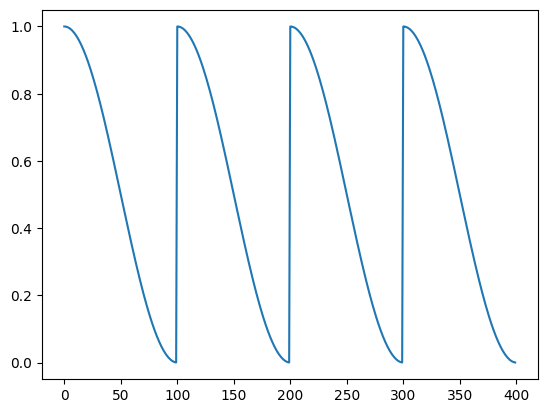

In [10]:
# визуализация изменения learning rate
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [11]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    # инициализирует атрибуты класса и определяет слои LSTM (rnn) и полносвязанный слой (fc).
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim # кол-во скрытого пр-ва (1)
        self.layer_dim = layer_dim # кол-во скрытых слоев (4)
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # инициализируется слой LSTM
        self.fc = nn.Linear(hidden_dim, output_dim) # создает линейный слой (fully connected) для преобразования выходных данных LSTM в прогнозируемые классы или значения
        self.batch_size = None
        self.dropout = nn.Dropout(0.2)
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x) # инициализация скрытых состояний h0 и c0 с помощью метода init_hidden(x).
        out, (hn, cn) = self.rnn(x, (h0, c0)) # прямой проход модели
        out = self.dropout(out)
        out = self.fc(out[:, -1, :]) # выбираются выходы LSTM только для последнего временного шага каждой последовательности в батче
        # Результатом является тензор прогнозов классов с размерностью (batch_size, output_dim)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim) # количество слоев, размер батча, размер скрытого состояния
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim) # количество слоев, размер батча, размер скрытого состояния
        return [t.cuda() for t in (h0, c0)]

In [12]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['rating'])

Preparing datasets


In [13]:
bs = 16
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=cpu_count())

Creating data loaders with batch size: 16


In [14]:
input_dim = 171   # размерность входная  
hidden_dim = 32 # размерность скрытого пространства (ht)
layer_dim = 2    # кол-во скрытых слоев
output_dim = 8   # размерность выходная (количество признаков)
# seq_dim = 128    # длина последовательности

lr = 0.0005 # скорость обучения
n_epochs = 1000 # количество эпох
iterations_per_epoch = len(trn_dl) # итераций в эпоху
best_acc = 0 # лучший accuracy
patience, trials = 100, 0 # сколько эпох держит без повышения accuracy, счетчик

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim) # создаем класс LSTM
model = model.cuda() # кидаем на CUDA
criterion = nn.CrossEntropyLoss() # критерий (или функция потерь) для задач классификации
opt = torch.optim.RMSprop(model.parameters(), lr=lr) # выбор оптимизатора
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100)) # какой-то класс ?

print('Start model training')

Start model training


In [15]:
# Для каждой эпохи делаем
for epoch in range(1, n_epochs + 1):
    # Для счетчика, набора батчей в трейн дата лоадере
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train() # перевод модели в режим обучения
        x_batch = x_batch.to(DEVICE) # кидаем в CUDA
        y_batch = y_batch.to(DEVICE) # кидаем в CUDA
        sched.step() # обновление расписания scheduler для обновления скорости обучения
        opt.zero_grad() # обнуление градиента
        out = model(x_batch) # прямой проход по модели (на вход x_batch)
        loss = criterion(out, y_batch) # смотрим чо по лоссу
        loss.backward() # обратное распространение ошибки (вычисляем градиент по всем параметрам модели)
        opt.step() # оптимизатором меняем веса для уменьшения функции потерь
     
    model.eval() # перевод модели в режим оценки
    correct, total = 0, 0 # переменные правильно прдсказанные / всего
    
    # Для набора батчей в валидационном дата лоадере
    for x_val, y_val in val_dl:
        x_val, y_val = [t.to(DEVICE) for t in (x_val, y_val)] # переносим все элементы в CUDA
        out = model(x_val) # прямой проход по модели (на вход x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1) # логарифм от софтмакса и по нему максимальный 
        total += y_val.size(0) # увеличиваем тотал на батч у_вал
        correct += (preds == y_val).sum().item() # увеличиваем коррект если правильно
                              
    acc = correct / total # метрика
    # Для каждой 5 эпохи
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')
    # Если текущая метрика выше лучшей то обновляем лучшую
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 best model saved with accuracy: 63.08%
Epoch 3 best model saved with accuracy: 75.38%
Epoch:   5. Loss: 1.3687. Acc.: 86.15%
Epoch 5 best model saved with accuracy: 86.15%
Epoch 6 best model saved with accuracy: 87.69%
Epoch 7 best model saved with accuracy: 90.77%
Epoch:  10. Loss: 0.0695. Acc.: 90.77%
Epoch 11 best model saved with accuracy: 92.31%
Epoch:  15. Loss: 0.2498. Acc.: 92.31%
Epoch 19 best model saved with accuracy: 95.38%
Epoch:  20. Loss: 0.0339. Acc.: 93.85%
Epoch:  25. Loss: 0.1869. Acc.: 96.92%
Epoch 25 best model saved with accuracy: 96.92%
Epoch:  30. Loss: 0.0090. Acc.: 95.38%
Epoch 32 best model saved with accuracy: 98.46%
Epoch:  35. Loss: 0.0127. Acc.: 93.85%
Epoch:  40. Loss: 0.0047. Acc.: 98.46%
Epoch:  45. Loss: 0.0020. Acc.: 95.38%
Epoch:  50. Loss: 0.0027. Acc.: 95.38%
Epoch:  55. Loss: 0.0027. Acc.: 96.92%
Epoch:  60. Loss: 0.0065. Acc.: 96.92%
Epoch:  65. Loss: 0.0002. Acc.: 96.92%
Epoch:  70. Loss: 0.0005. Acc.: 96.92%
Epoch:  75. Loss: 0.0037. A

In [50]:
model.load_state_dict(torch.load('best.pth')) # сохраненные параметры модели, полученные в процессе обучения

<All keys matched successfully>

In [16]:
model.eval() # перевод модели в режим оценки

LSTMClassifier(
  (rnn): LSTM(171, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

<b>ТУТ МЫ ТЕСТИМ АКУРАСИ НА ТЕСТОВЫХ ДАННЫХ</b>

In [17]:
test_dl = DataLoader(create_test_dataset_fake(x_tst), batch_size=16, shuffle=False)

In [22]:
test = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    out = model(batch.cuda())
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()

Predicting on test dataset


In [23]:
y_pred = enc.inverse_transform(test)
y_real = y_tst['rating'].values

In [24]:
correct, total = 0, 0 # переменные правильно прeдсказанные / всего
total = len(y_pred)
# Для набора батчей в валидационном дата лоадере
for i in range(len(y_pred)):
    if y_pred[i] == y_real[i]:
        correct += 1
acc = correct / total # метрика
print(f'Acc.: {acc:2.2%}')

Acc.: 81.33%


In [25]:
# Рассчет квадратов разницы между предсказаниями и фактическими значениями
squared_diffs = (y_real - y_pred) ** 2

# Рассчет среднеквадратичного отклонения (RMSE)
rmse = torch.sqrt(torch.mean(torch.tensor(squared_diffs, dtype=torch.float32)))

print('RMSE:', rmse.item())

RMSE: 0.5689037442207336


In [26]:
print(f'Predicted: {y_pred}')
print(f'Real     : {y_real}')

Predicted: [11. 11. 11. 11. 11.  9. 10. 10. 11. 10. 11. 11. 11. 11. 11.  9.  9.  9.
  9.  9.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.  9.  9.  9.  9. 13. 13.
 13. 13. 13. 11. 11.  7.  7.  7.  7.  7. 13. 14. 14. 14. 13.  7.  7.  7.
  7.  7. 10. 10. 10. 10.  9.  9.  8.  8.  8.  8.  8. 10. 10. 10. 10. 11.
 10. 10. 10. 10. 10. 14. 14. 14. 14. 14. 13. 13. 13. 13. 13.  8.  8. 10.
 10. 10.  9.  9.  9.  9. 13. 12. 12. 13. 12.  9.  9.  9.  9.  9.  9. 10.
 10. 10.  9.  8.  8.  8.  8.  8.  8.  8.  8.  8. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 10. 10. 10. 10. 10. 13. 13. 13. 13. 13. 13. 13. 13.  9.  9.
  9.  9.  9. 11. 11. 11. 11. 11.  7.  7.  9.  9.  9.  9.  9. 10. 10. 10.
 10. 14. 14. 14. 14. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 12. 12. 11. 11. 11. 12. 12. 12. 12. 12. 11. 11. 11. 11. 11.  9.  9.
  9.  9.  9. 13. 13. 13. 13. 13. 13. 13. 13. 13. 11. 11. 11. 11. 11.  9.
  9.  9.  9.  9. 11. 11. 13. 13. 13. 13. 14. 14. 14. 14. 14. 11. 11. 11.
 11. 11. 14. 14. 14. 14. 14.]
Real     :

In [27]:
torch.cuda.empty_cache()

## RNN строим графики по каждому банку

Predicting on test dataset
Acc.: 73.68%
RMSE: 0.5129891633987427


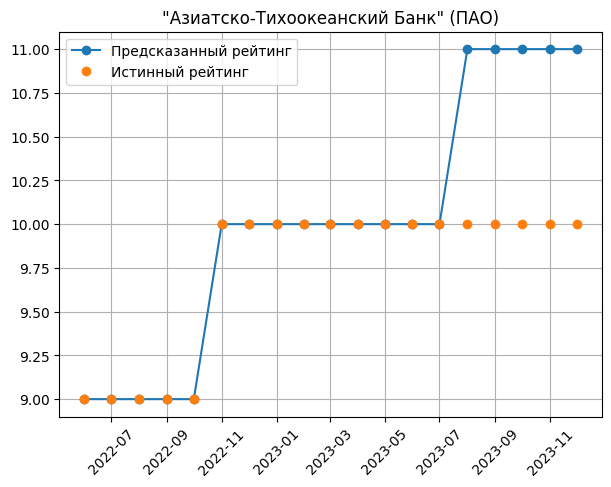

Predicting on test dataset
Acc.: 81.82%
RMSE: 0.42640143632888794


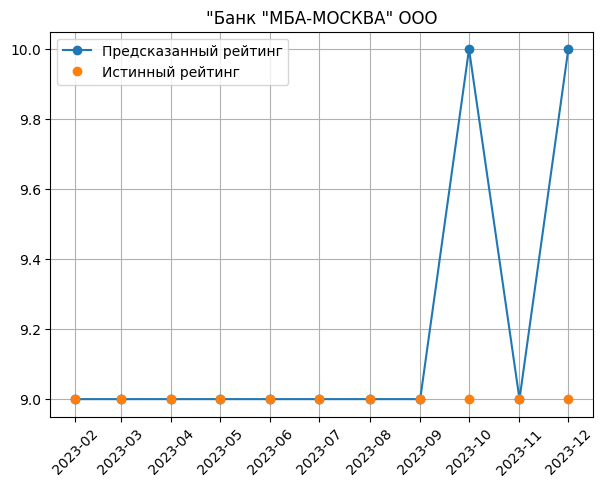

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


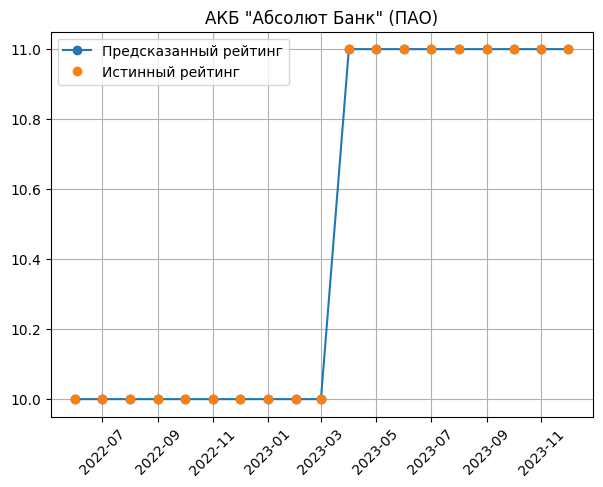

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


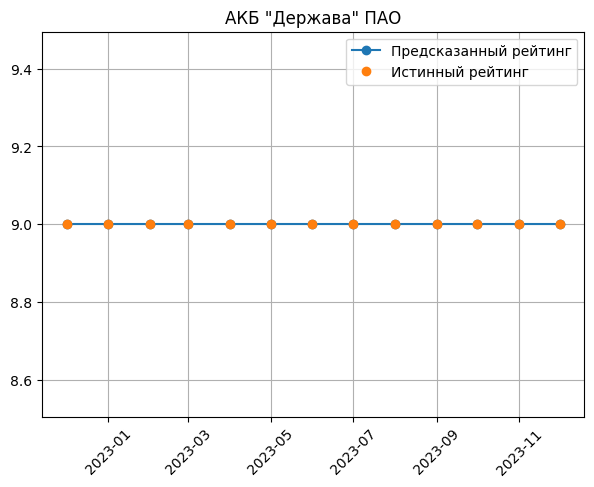

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


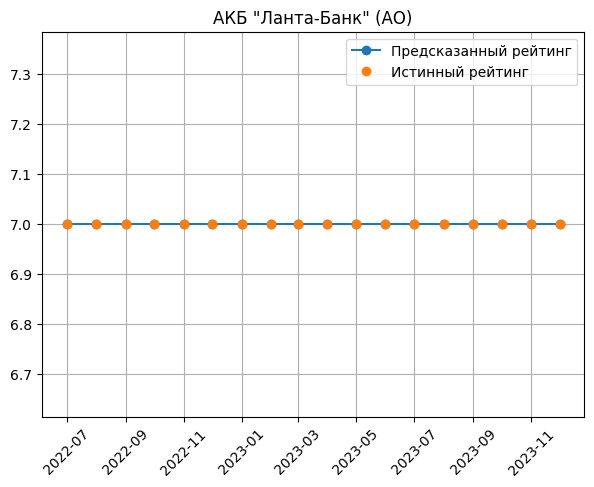

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


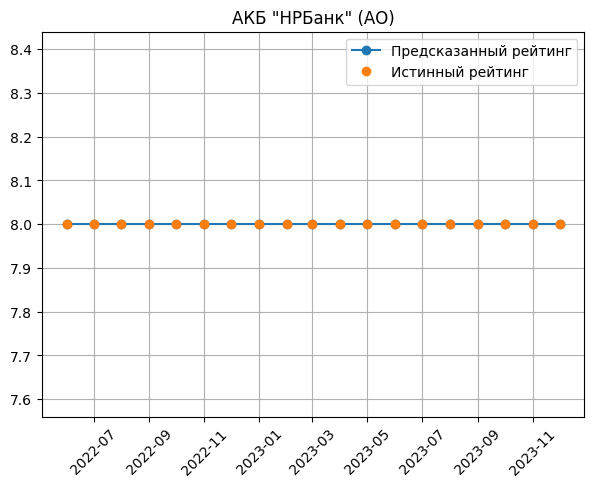

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


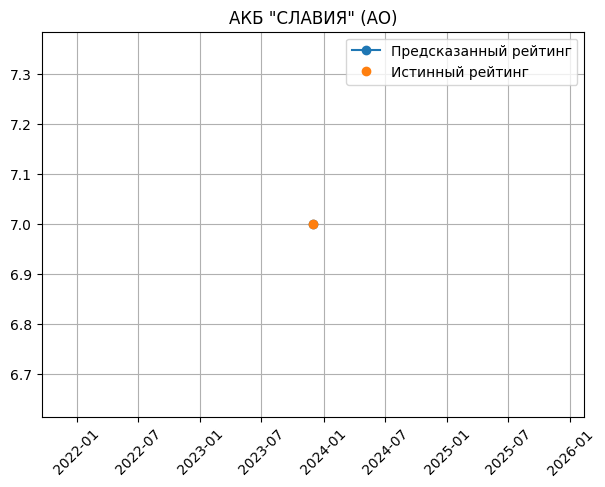

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


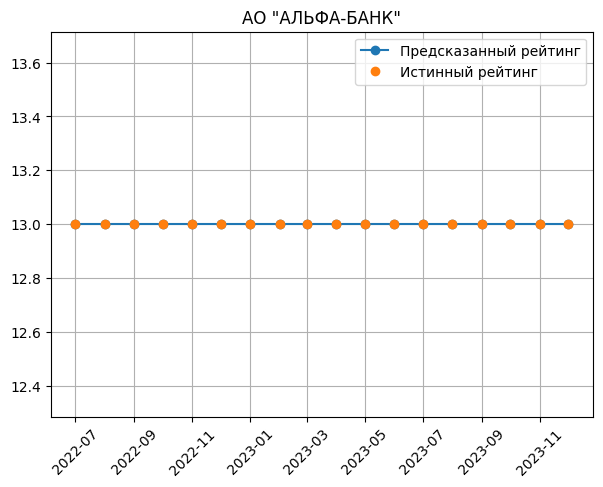

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


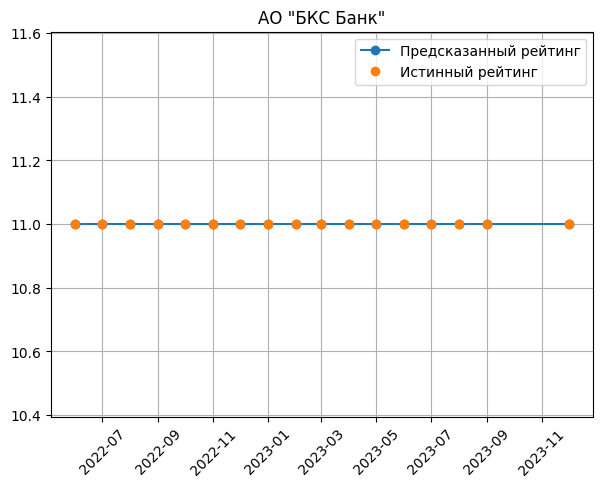

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


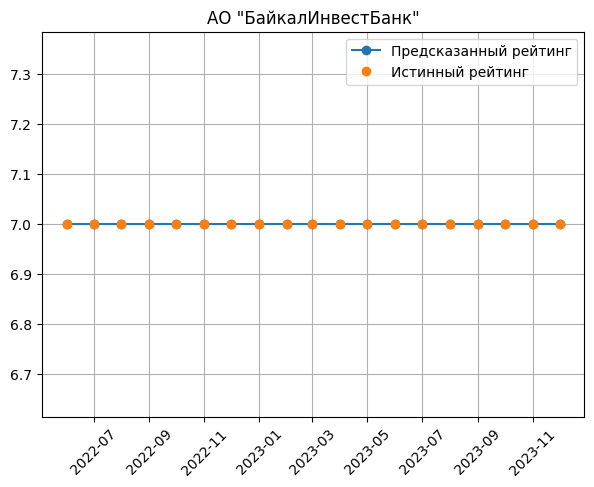

Predicting on test dataset
Acc.: 37.50%
RMSE: 0.7905694246292114


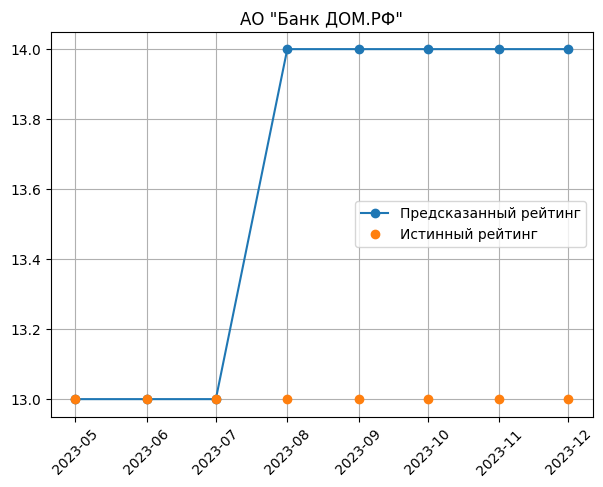

Predicting on test dataset
Acc.: 94.12%
RMSE: 0.24253562092781067


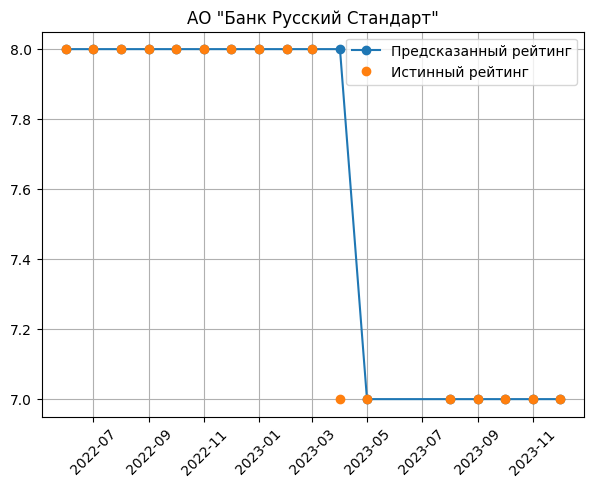

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


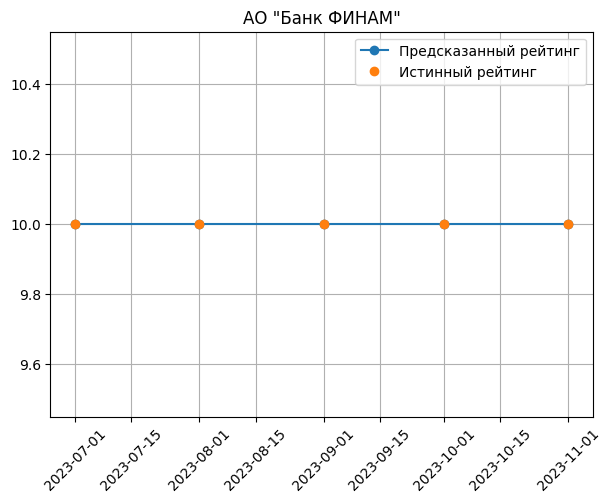

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


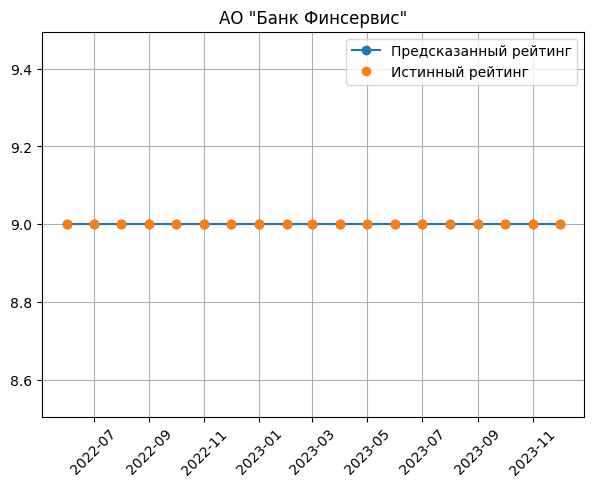

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


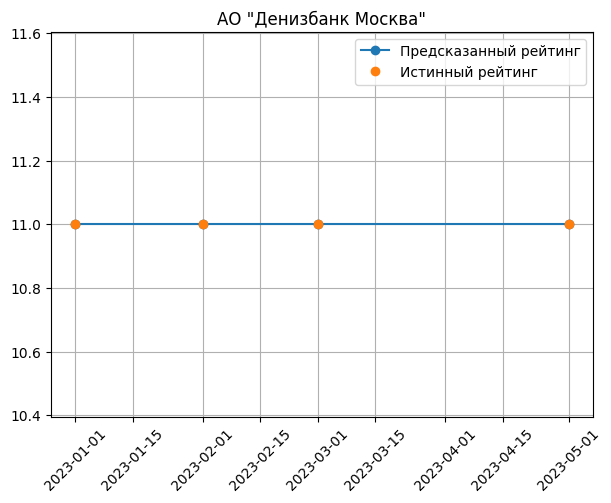

Predicting on test dataset
Acc.: 94.74%
RMSE: 0.22941572964191437


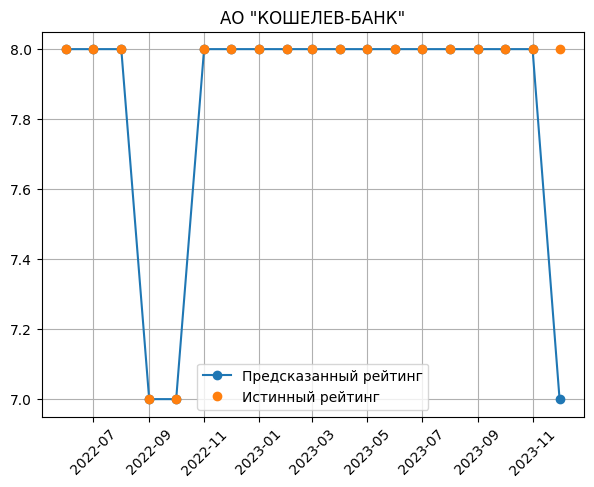

Predicting on test dataset
Acc.: 84.21%
RMSE: 0.397359699010849


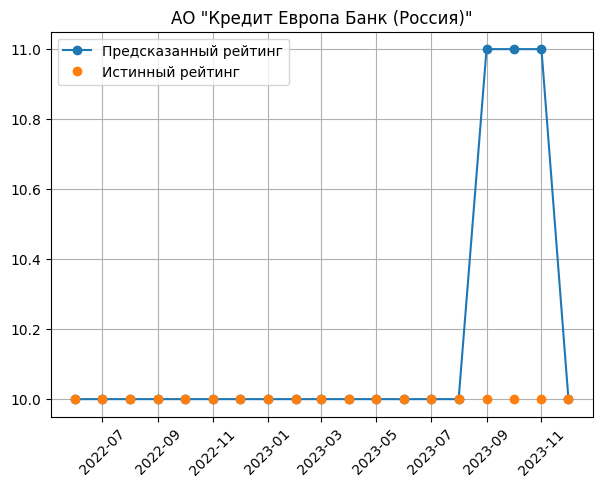

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


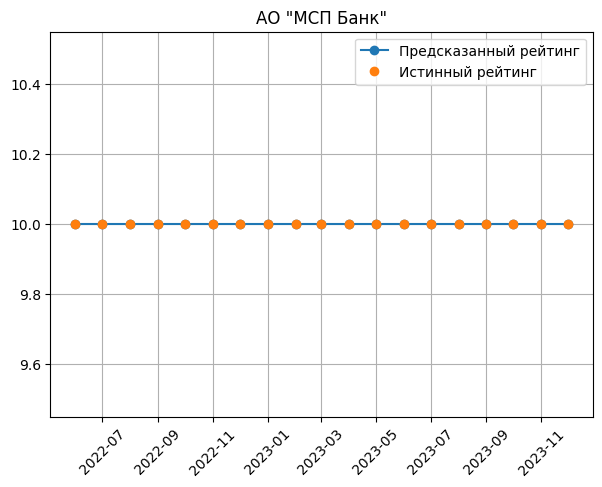

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


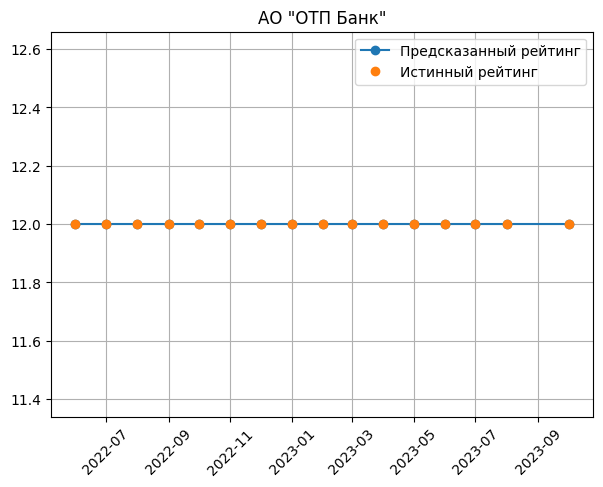

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


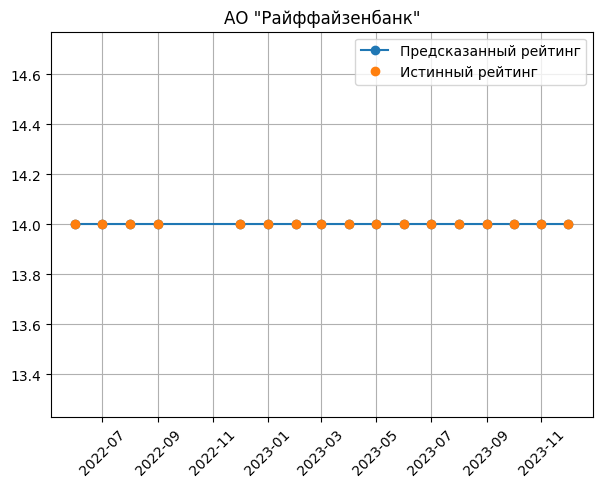

Predicting on test dataset
Acc.: 83.33%
RMSE: 0.40824830532073975


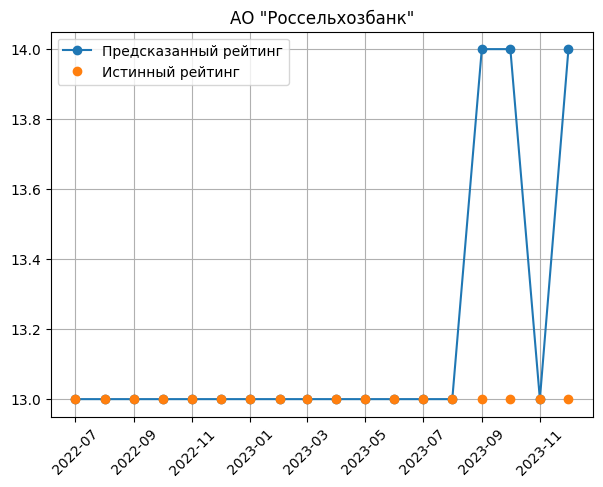

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


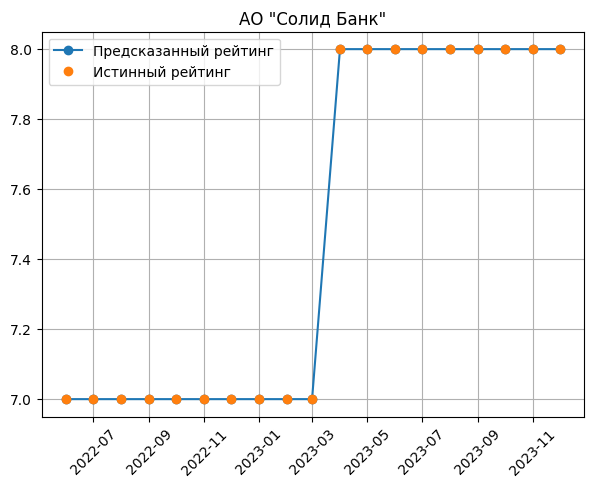

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


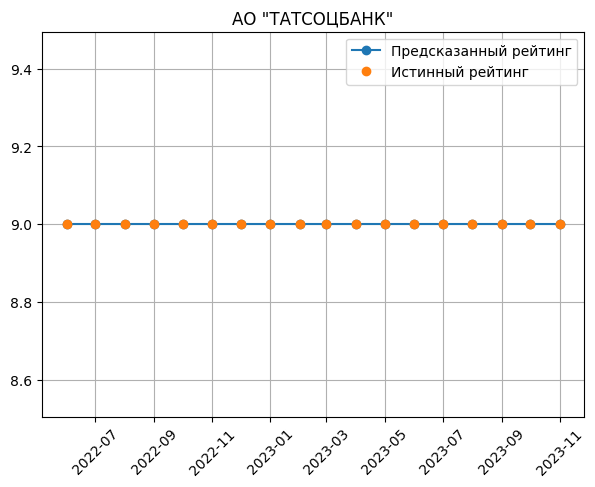

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


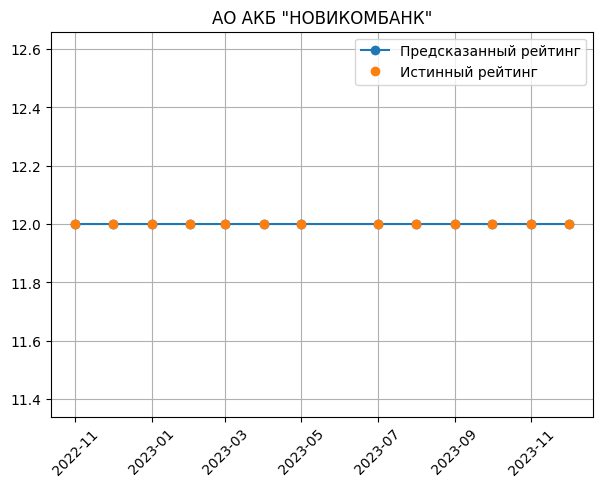

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


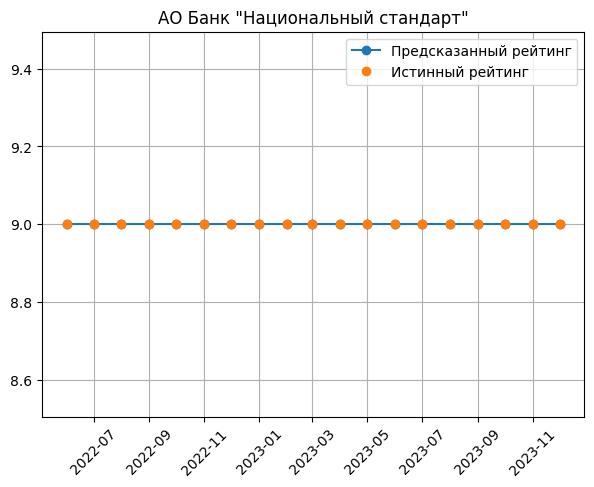

Predicting on test dataset
Acc.: 0.00%
RMSE: 1.0


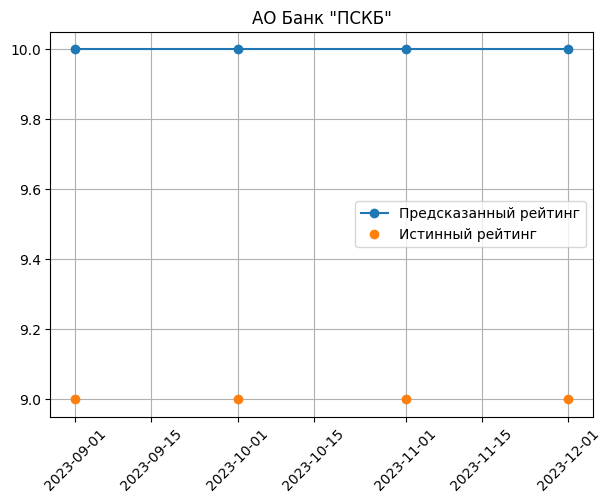

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


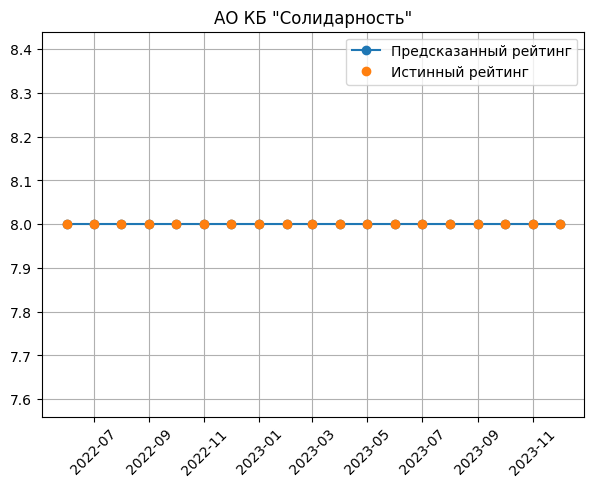

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


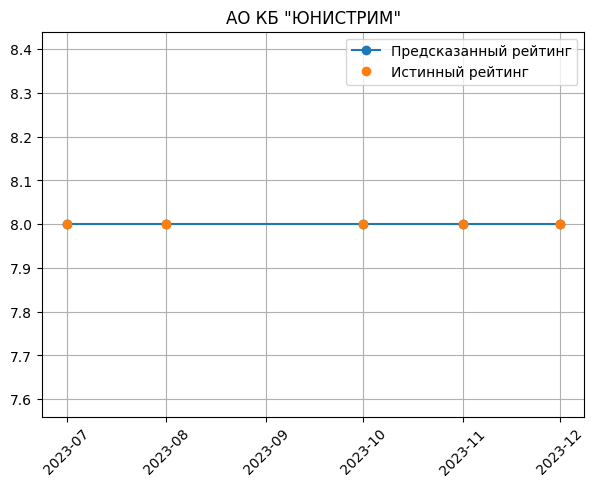

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


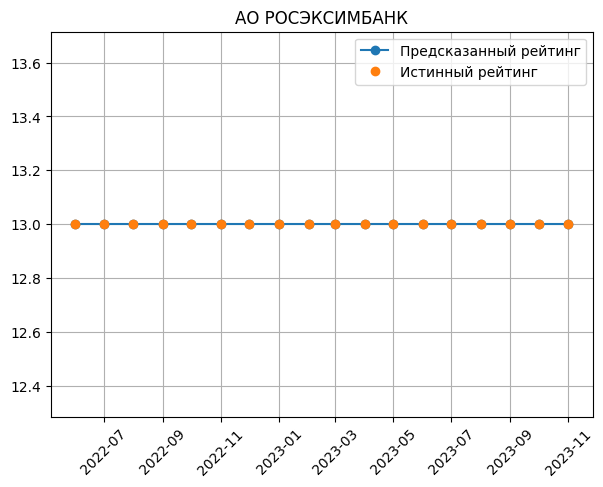

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


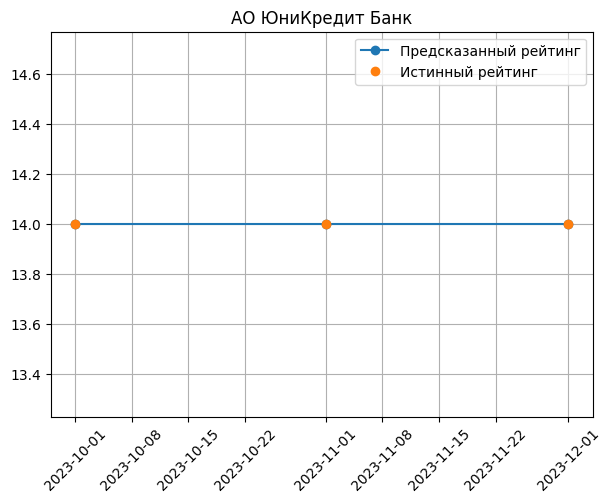

Predicting on test dataset
Acc.: 90.91%
RMSE: 0.30151134729385376


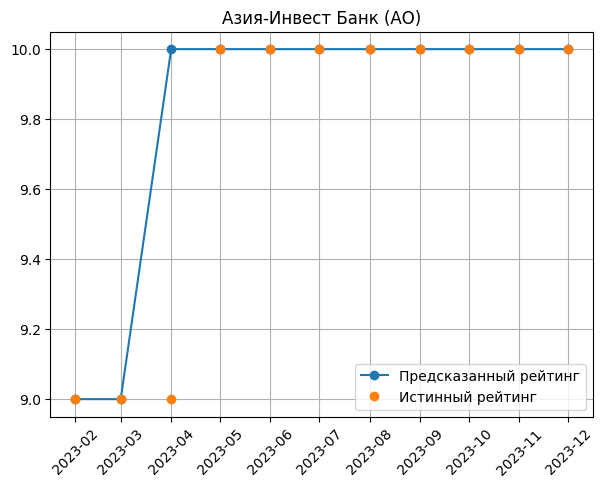

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


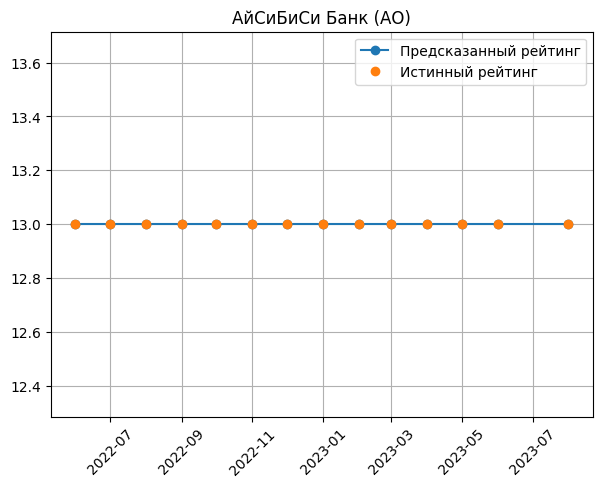

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


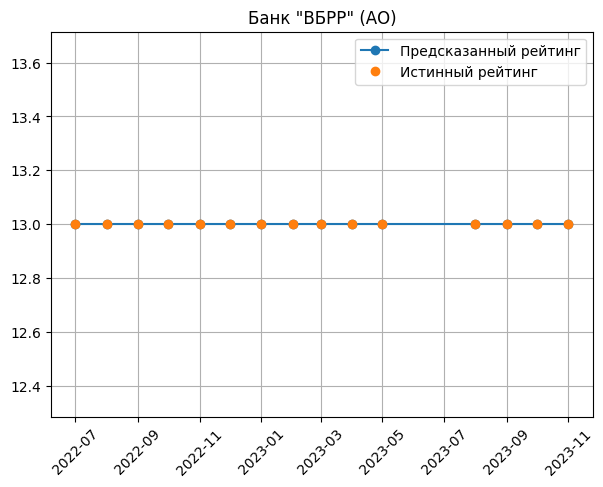

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


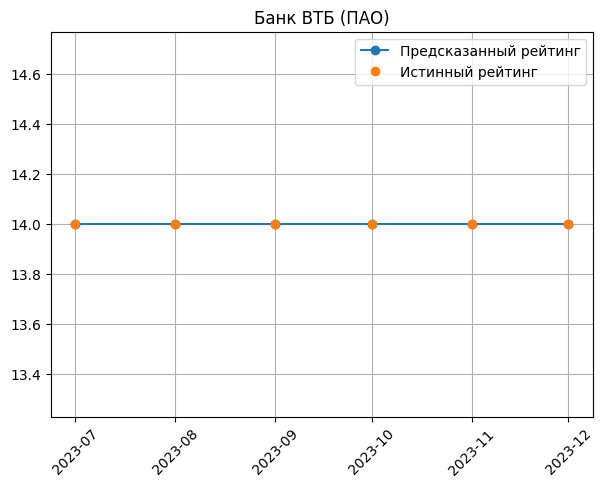

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


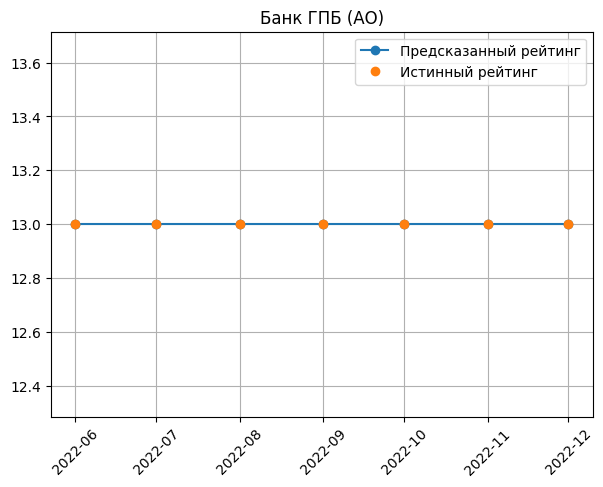

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


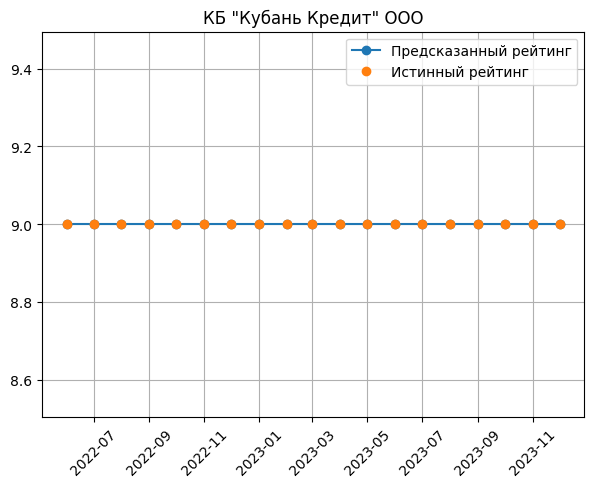

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


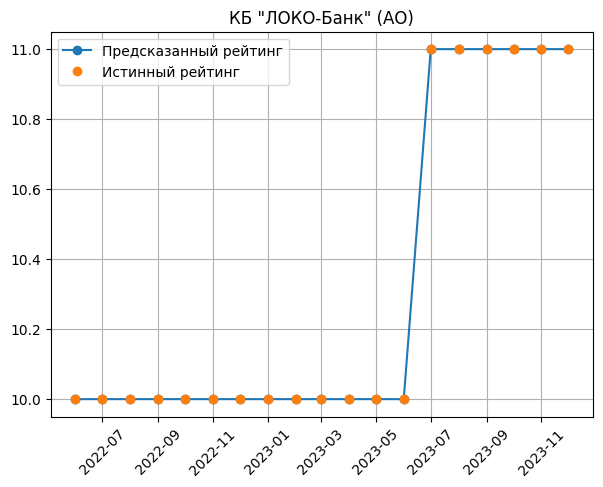

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


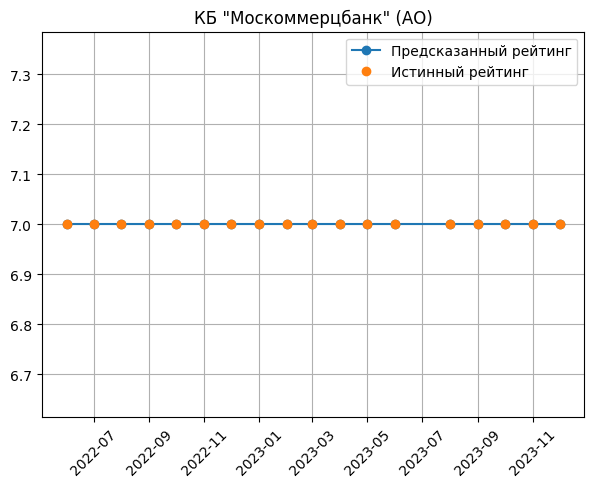

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


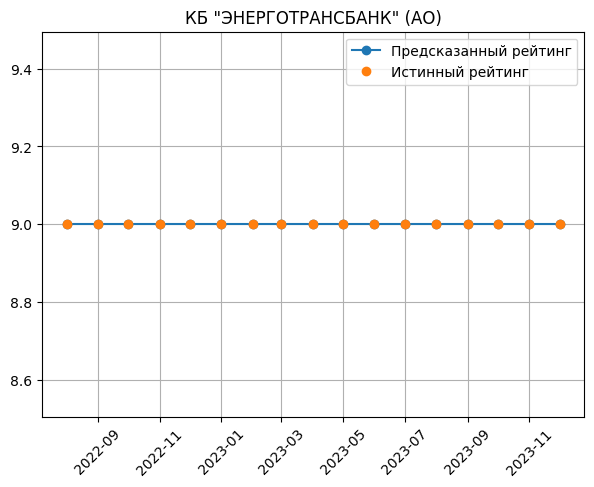

Predicting on test dataset
Acc.: 94.74%
RMSE: 0.22941572964191437


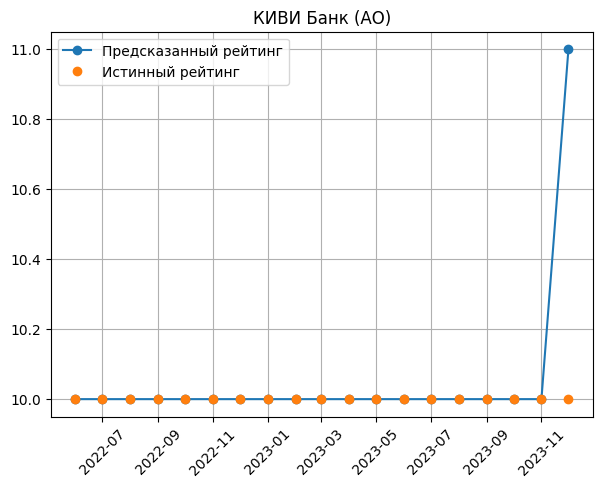

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


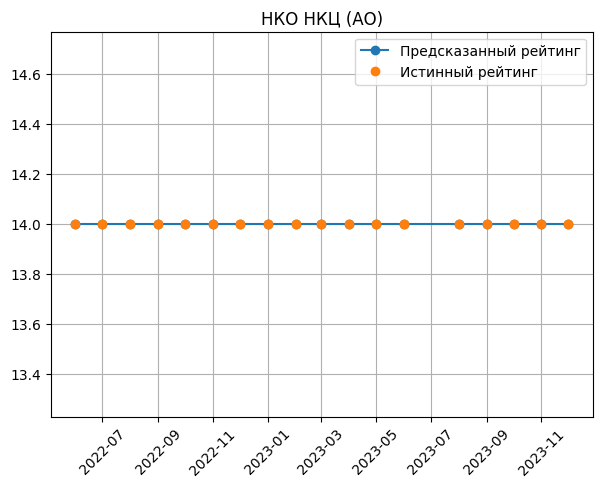

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


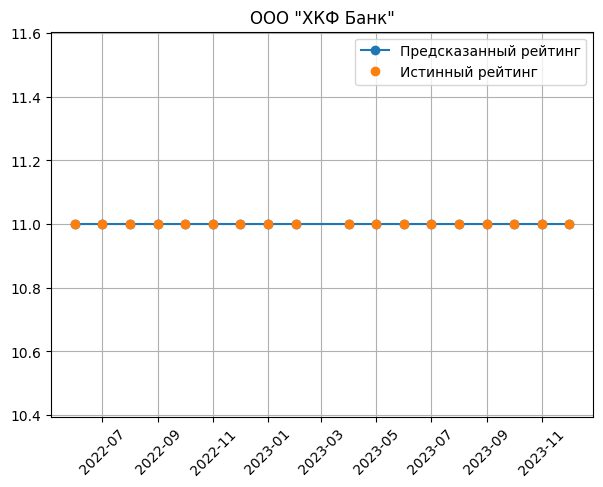

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


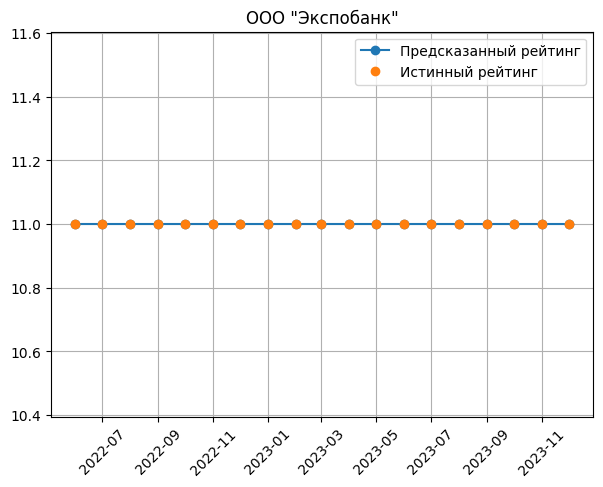

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


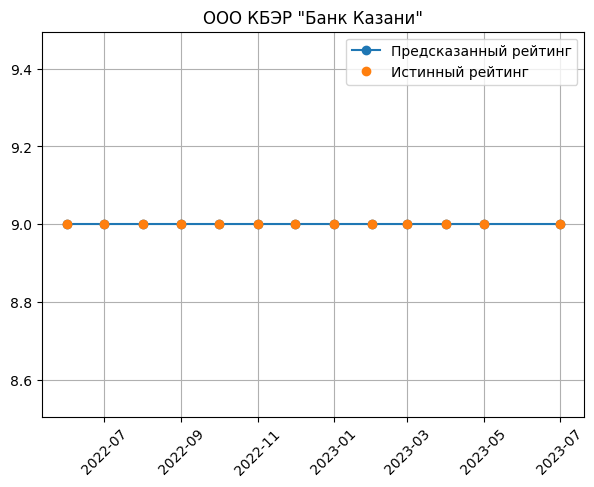

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


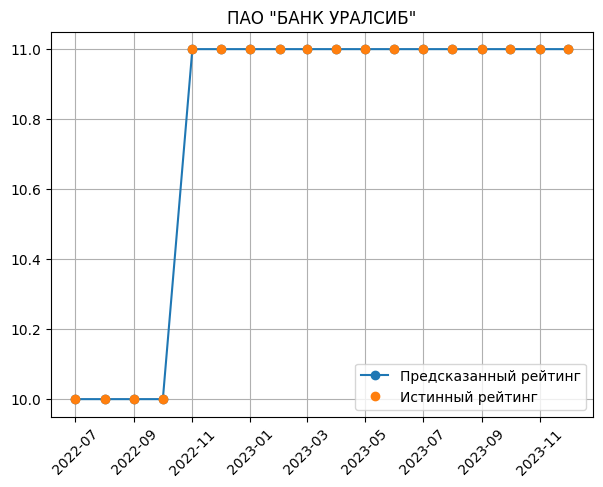

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


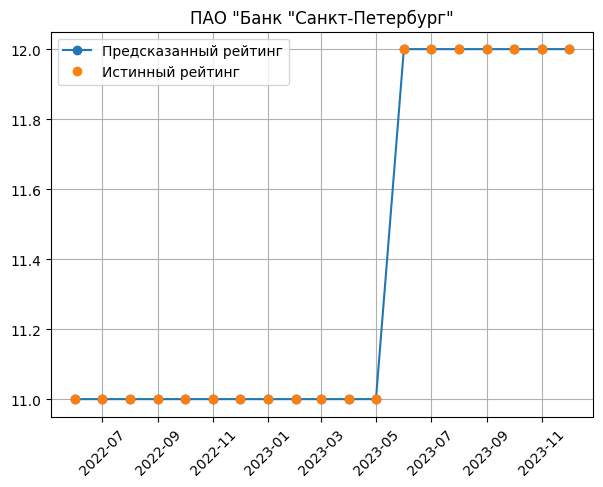

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


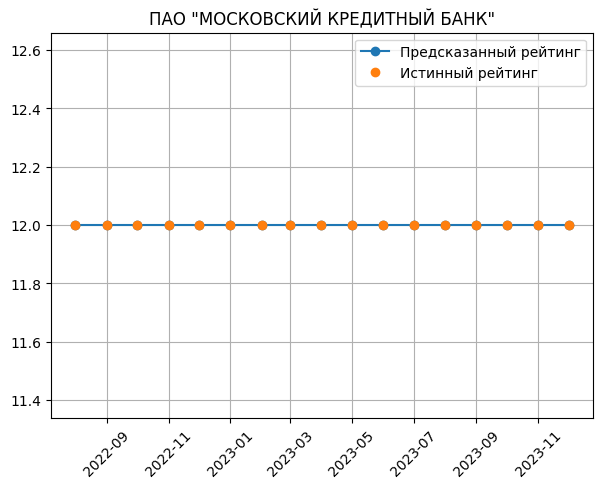

Predicting on test dataset
Acc.: 89.47%
RMSE: 0.3244428336620331


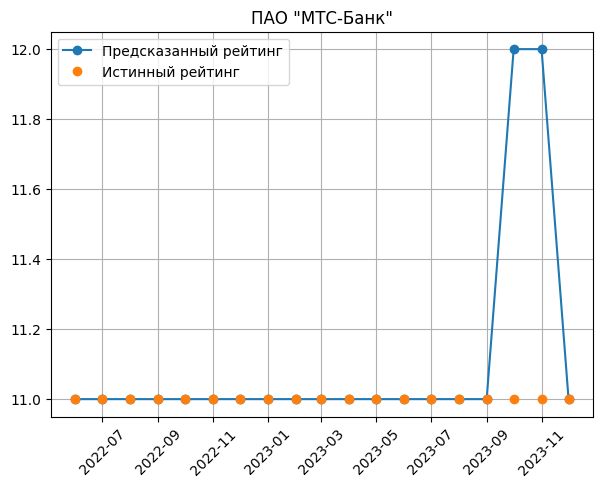

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


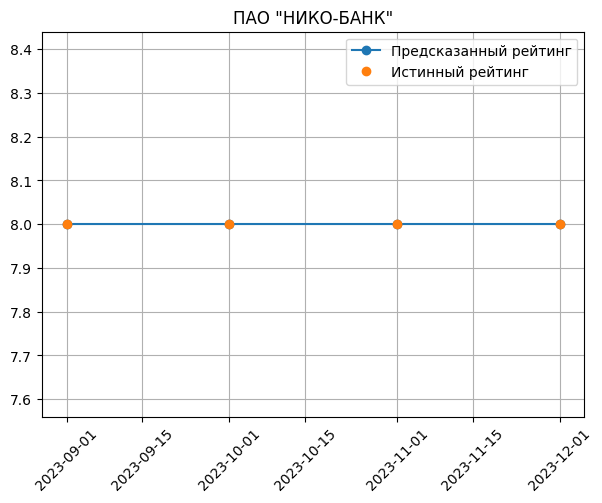

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


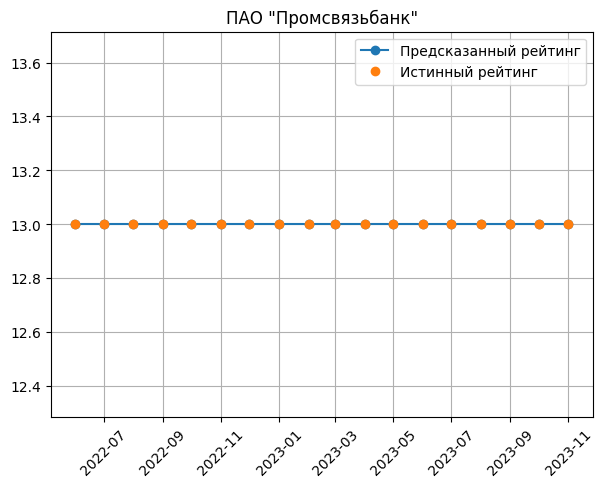

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


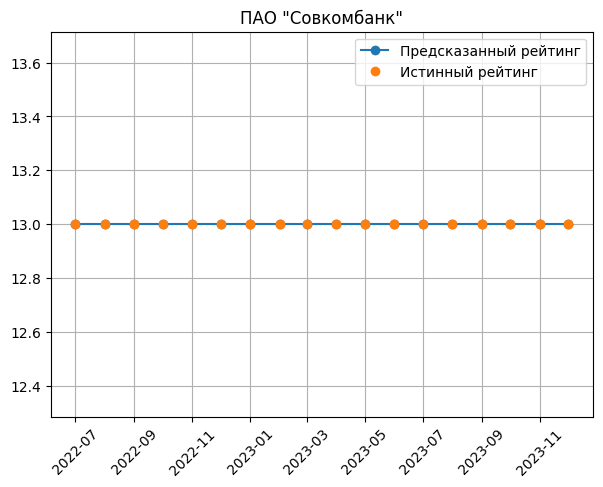

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


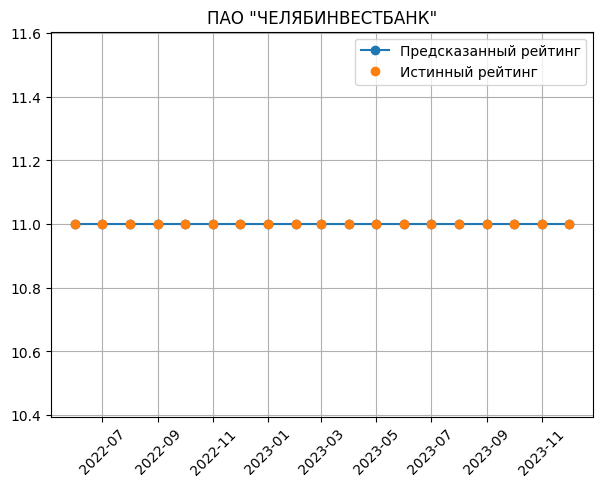

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


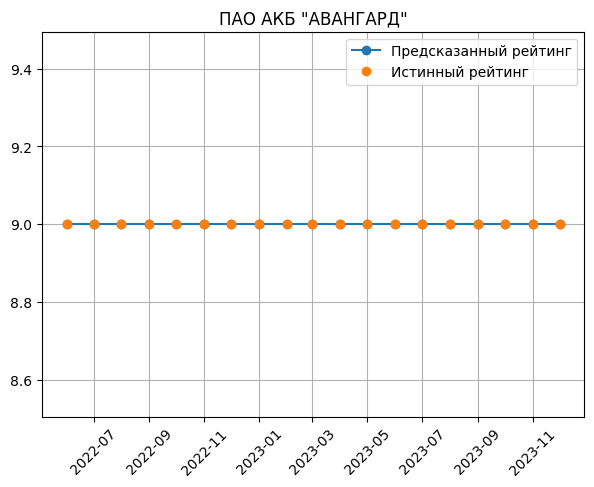

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


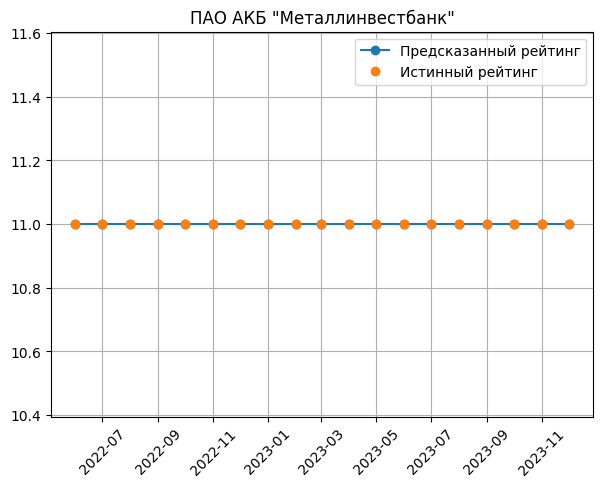

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


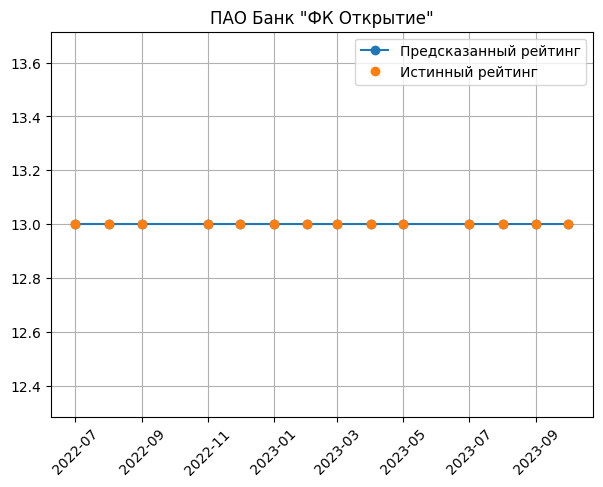

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


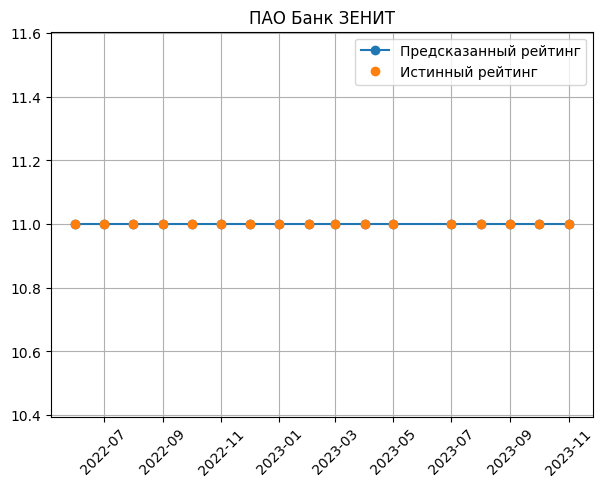

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


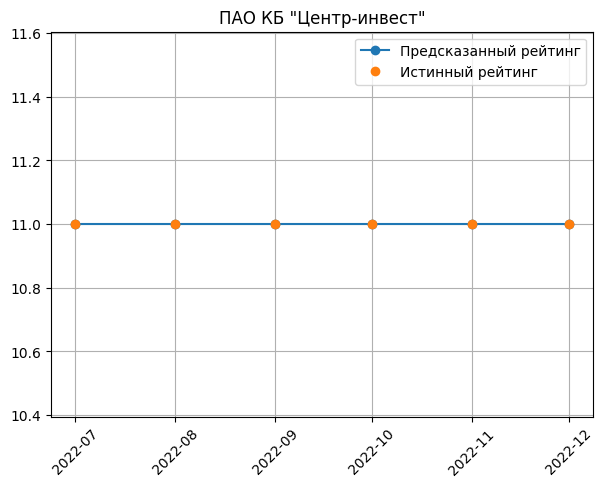

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


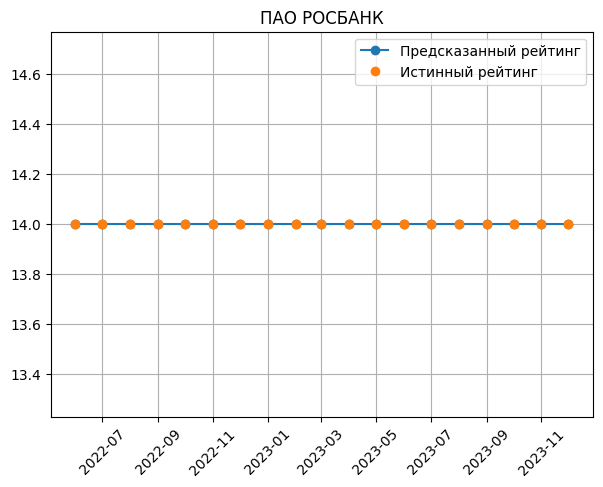

Predicting on test dataset
Acc.: 75.00%
RMSE: 1.0


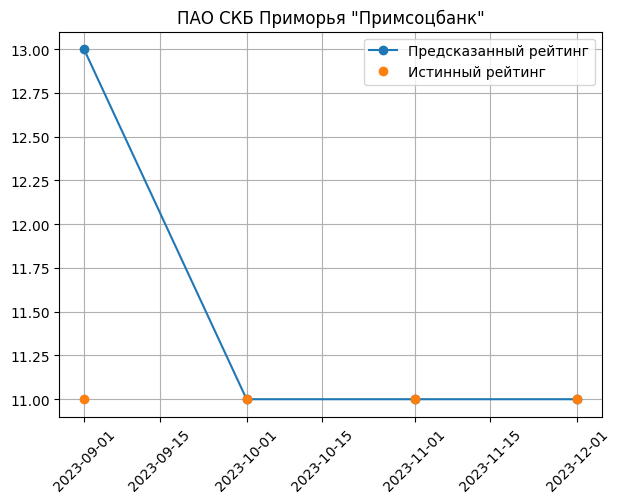

Predicting on test dataset
Acc.: 100.00%
RMSE: 0.0


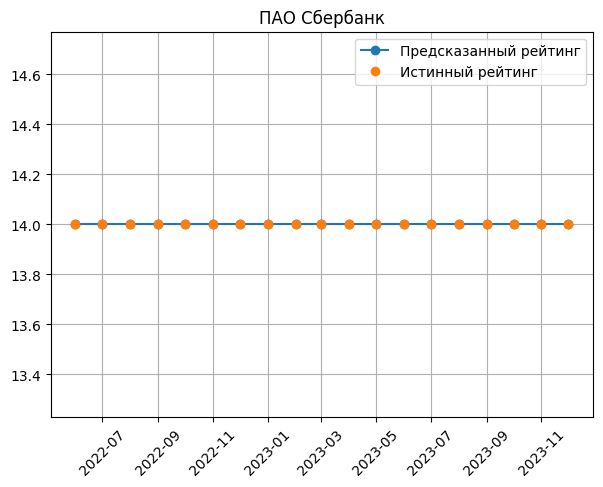

In [144]:
for bank in np.unique(df_category_sorted.index.values):
    # Собрали датасет из 1 банка
    df_bank = df_category_sorted.loc[df_category_sorted.index == bank]
    if len(df_bank) >= 4:
        ## Нужно собрать сосиски для каждого контрагента из разных дат
        df_date = df_bank['report_date']
        date = df_date.values
        df_bank = df_bank.drop("report_date", axis = 1) 
        df_bank = df_bank.drop("flag", axis=1)
        # Группировка данных по индексам
        grouped_data = df_bank.groupby(df_bank.index)
        # Создание списка для хранения тензоров
        tensor_data = []

        # Создание пустого массива для хранения "четверок"
        quad_data = np.empty((0, 4, df_bank.shape[1] - 1))
        quad_rating = np.empty((0, 4, 1))
        indexes = np.empty((0, 4))

        # Проход по каждой группе и создание четверок
        for name, group in grouped_data:
            if len(group) >= 4:
                for i in range(len(group) - 3):  # Проход по индексам для создания "четверок"
                    quad = group.iloc[i:i+4].values[:, 1:]  # Получение "четверки" из признаков
                    quad_data = np.concatenate((quad_data, [quad]), axis=0)
                    ratings = group.iloc[i:i+4].values[:, :1]  # Получение рейтингов для "четверки"
                    quad_rating = np.concatenate((quad_rating, [ratings]), axis=0)
                    # features_array = group.values[:,1:]  # преобразование признаков в массив NumPy
                    ind = group.index[i:i+4].values
                    indexes = np.concatenate((indexes, [ind]), axis=0)

        ## У нас есть quad_data и quad_rating (ЧЕТВЕРКИ)

        # ЧЕТВЕРКИ ПРИЗНАКОВ ДАТАФРЕЙМ
        df_quads = pd.DataFrame(quad_data.reshape(-1, quad_data.shape[-1]), columns=df_bank.columns[1:])
        # Добавление колонки с номером четверки
        df_quads['series_id'] = np.repeat(np.arange(len(quad_data)), 4)
        df_quads['index_bank'] = indexes.flatten()

        # РЕЙТИНГИ ДЛЯ ЧЕТВЕРОК
        # Извлечение последнего элемента каждой четверки в quad_rating
        last_ratings = quad_rating[:, -1, 0]
        df_ratings = pd.DataFrame(last_ratings, columns=['rating'])
        # Добавление колонки series_id
        df_ratings['series_id'] = np.arange(len(last_ratings))
        df_ratings['index_bank'] = indexes[:, -1].flatten()

        ## НАЧИНАЕМ ПРЕДИКТЫ
        ID_COLS = ['series_id', 'index_bank']
        x_tst = df_quads
        y_tst = df_ratings

        # Веса
        model.load_state_dict(torch.load('best.pth')) # сохраненные параметры модели, полученные в процессе обучения
        model.eval() # перевод модели в режим оценки

        # Даталодер
        test_dl = DataLoader(create_test_dataset_fake(x_tst), batch_size=16, shuffle=False)
        test = []
        # Предиктим
        print('Predicting on test dataset')
        for batch, _ in test_dl:
            batch = batch.permute(0, 2, 1)
            out = model(batch.cuda())
            y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
            test += y_hat.tolist()

        y_pred = enc.inverse_transform(test)
        y_real = y_tst['rating'].values

        # Акураси
        correct, total = 0, 0 # переменные правильно прeдсказанные / всего
        total = len(y_pred)
        # Для набора батчей в валидационном дата лоадере
        for i in range(len(y_pred)):
            if y_pred[i] == y_real[i]:
                correct += 1
        acc = correct / total # метрика
        print(f'Acc.: {acc:2.2%}')

        # RMSE
        squared_diffs = (y_real - y_pred) ** 2
        # Рассчет среднеквадратичного отклонения (RMSE)
        rmse = torch.sqrt(torch.mean(torch.tensor(squared_diffs, dtype=torch.float32)))
        print('RMSE:', rmse.item())

        
        plt.figure(figsize=(7, 5))
        plt.plot(date[3:], y_pred, label='Предсказанный рейтинг', marker='o')
        plt.plot(date[3:], y_real, label='Истинный рейтинг', marker='o', linestyle='None')
        plt.title(bank)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

# Делим на бизнес и финансовые

In [66]:
# СКОР БАЛЛ ДЛЯ БИЗНЕСА И ФИНАНСОВ

# Кульбак с ограничениями
w_kul_business = w_kul[:77]
w_kul_finance = w_kul[77:]

# Кульбак без ограничений
w_wkul_business = w_kul_wcons[:77]
w_wkul_finance = w_kul_wcons[77:]

# Базовые веса
w_business = w.reshape(-1, 1)[:77]
w_finance = w.reshape(-1, 1)[77:]

# Триплет одномерный веса
w_triplet_business = w_triplet.reshape(-1, 1)[:77]
w_triplet_finance = w_triplet.reshape(-1, 1)[77:]

# Триплет двумерный веса
w_triplet_business_dvum = w_triplets_dvum.reshape(-1, 1)[:77]
w_triplet_finance_dvum = w_triplets_dvum.reshape(-1, 1)[77:]

## ЭТО МЕНЯЕМ КОГДА ТЕСТИМ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
# df_numpy_business = df_cat_drop_test[df_cat_drop_test.columns[:77]].values # был df_cat_drop
# df_numpy_finance = df_cat_drop_test[df_cat_drop_test.columns[77:]].values
df_numpy_business = df_cat_drop_train[df_cat_drop_train.columns[:77]].values # был df_cat_drop
df_numpy_finance = df_cat_drop_train[df_cat_drop_train.columns[77:]].values

# Кульбак с ограничениями
score_kul_business = np.dot(df_numpy_business, w_kul_business)
score_kul_finance = np.dot(df_numpy_finance, w_kul_finance)

# Кульбак без ограничений
score_wkul_business = np.dot(df_numpy_business, w_wkul_business)
score_wkul_finance = np.dot(df_numpy_finance, w_wkul_finance)

# Обычные
score_business = np.dot(df_numpy_business, w_business)
score_finance = np.dot(df_numpy_finance, w_finance)

# Триплет одномерный
score_triplet_business = np.dot(df_numpy_business, w_triplet_business)
score_triplet_finance = np.dot(df_numpy_finance, w_triplet_finance)

# Триплет двумерный
score_triplet_business_dvum = np.dot(df_numpy_business, w_triplet_business_dvum)
score_triplet_finance_dvum = np.dot(df_numpy_finance, w_triplet_finance_dvum)

NameError: name 'w_kul' is not defined

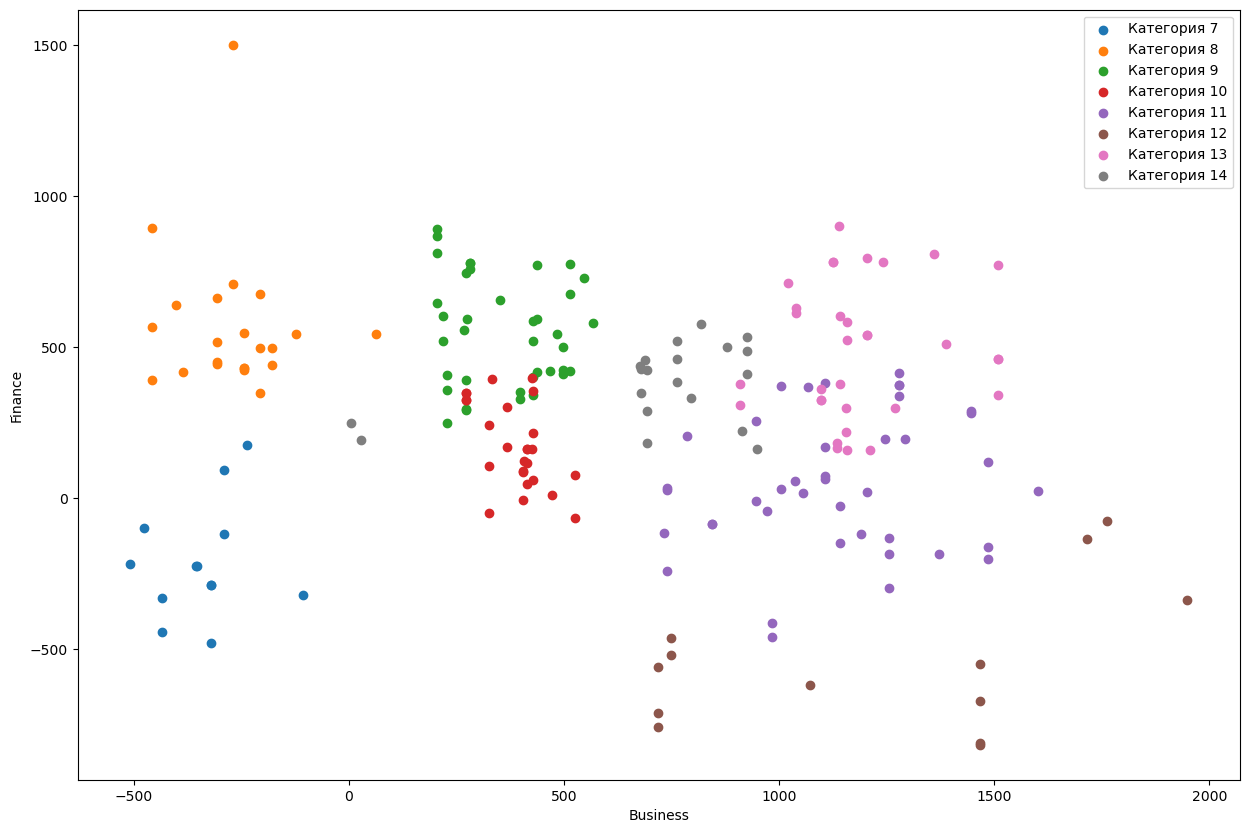

In [244]:
unique_categories = np.unique(external_train)
plt.figure(figsize=(15,10))
for cat in unique_categories:
    x_kul = score_triplet_business_dvum[external_train == cat]
    y_kul = score_triplet_finance_dvum[external_train == cat]
    plt.scatter(x_kul, y_kul, label=f'Категория {cat}')

plt.xlabel('Business')
plt.ylabel('Finance')
plt.legend()
plt.show()

# Дерево обучение в двумерном

In [55]:
# учимся на обучающем

# рейтинг в баллах (дф признаков * веса после триплета)
X_train = np.column_stack((score_triplet_business_dvum, score_triplet_finance_dvum))
# рейтинг истинный 
y_train = external_train

# Обучение
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

### Для валидационной

In [57]:
# рейтинг в баллах (дф признаков * веса после триплета)
X_test = np.column_stack((score_triplet_business_dvum, score_triplet_finance_dvum))
# рейтинг истинный 
y_test = external_test

# предсказание
y_pred = model.predict(X_test)

# Оценка точности 
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7336448598130841


# Оценка точности всех методов

In [19]:
# ЭТО ДЛЯ ВАЛИДАЦИОННОЙ!!!
# рейтинг в баллах (дф признаков * веса после триплета)
X_test = np.dot(df_numpy, w_triplet)
# рейтинг истинный 
y_test = score_cat(external_test)

# предсказание
y_pred = model.predict(X_test)

# Оценка точности 
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Оценка точности по исходным весам
y_r = y_test.flatten()
y_p = score_cat(np.dot(df_numpy, w.reshape(-1, 1))).flatten()
matching_elems = np.sum(y_p == y_r)
total_elems = len(y_r)
matching_percents = (matching_elems / total_elems)
print(matching_percents)

# Оценка точности по весам после кульбака

y_r = y_test.flatten()
y_p = score_cat(np.dot(df_numpy, w_kul)).flatten()
matching_elems = np.sum(y_p == y_r)
total_elems = len(y_r)
matching_percents = (matching_elems / total_elems)
print(matching_percents)

1.0
0.15601965601965603
0.8218673218673219


# Графики предсказанных и истинных рейтингов по банкам (ТРИПЛЕТЫ)

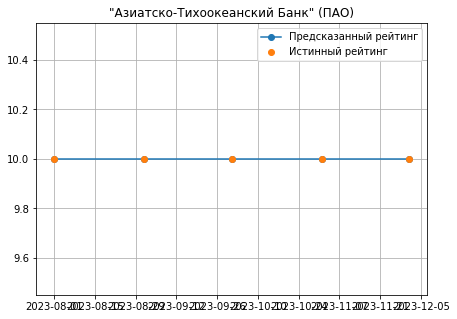

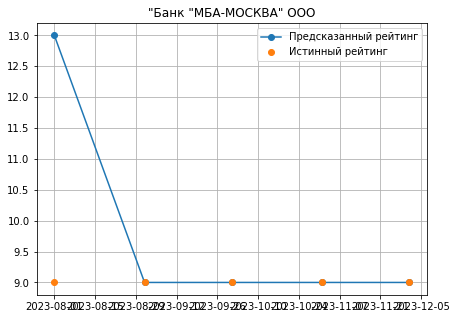

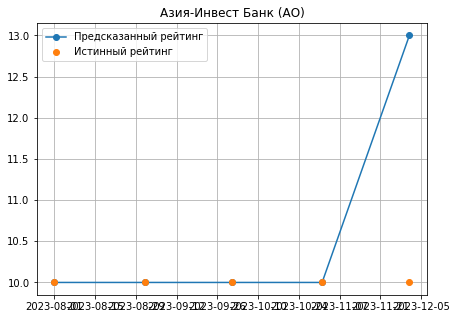

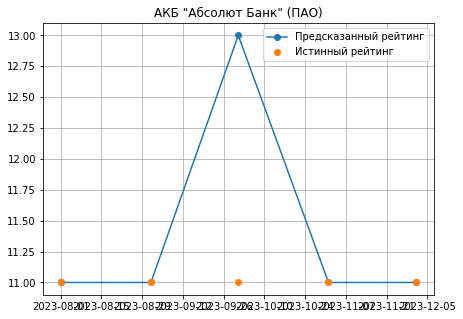

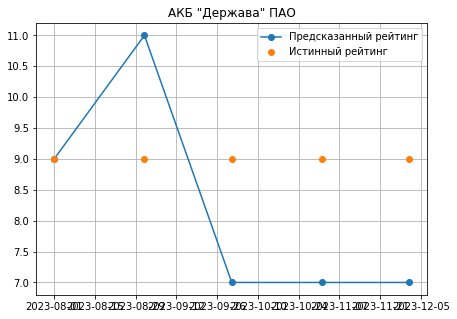

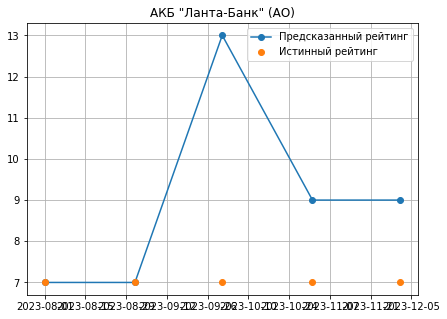

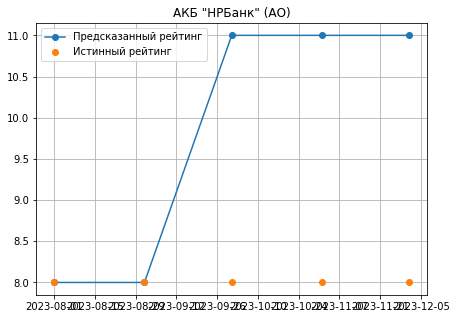

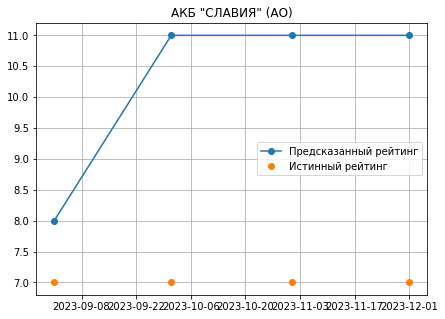

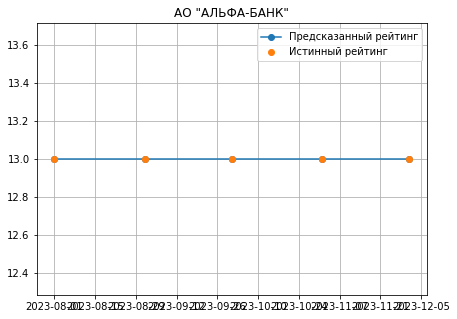

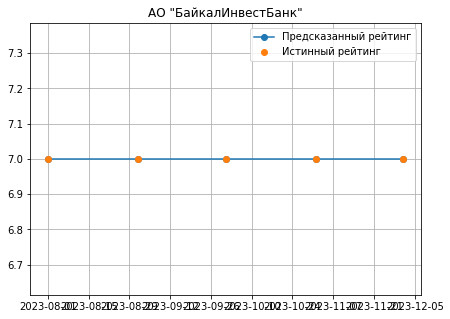

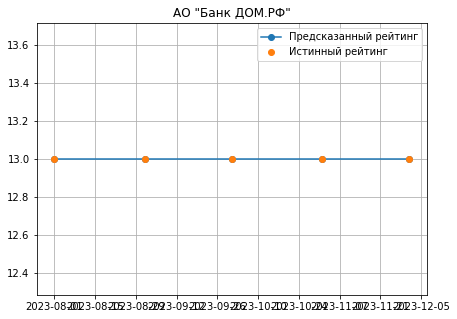

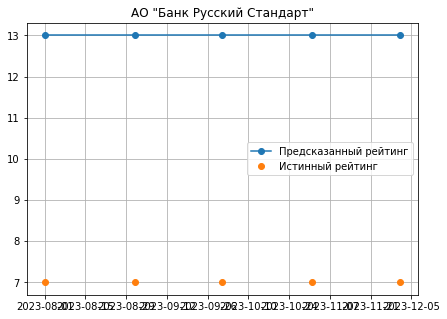

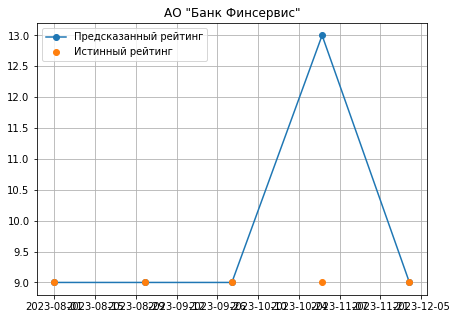

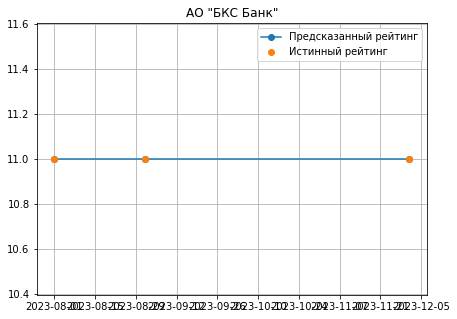

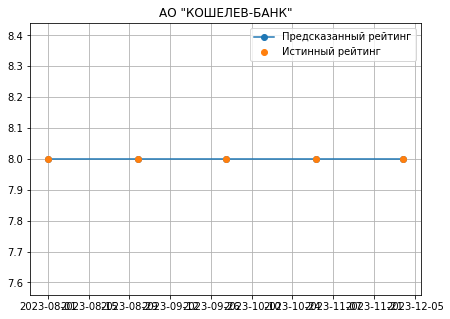

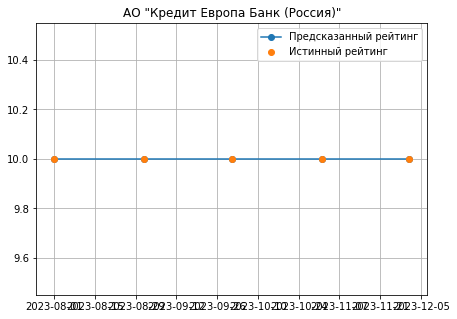

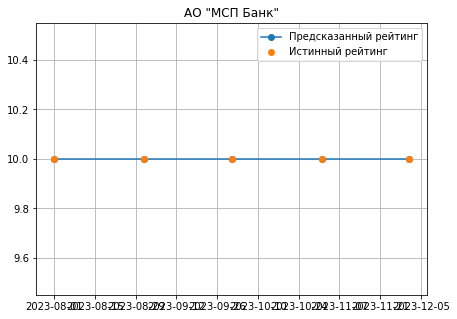

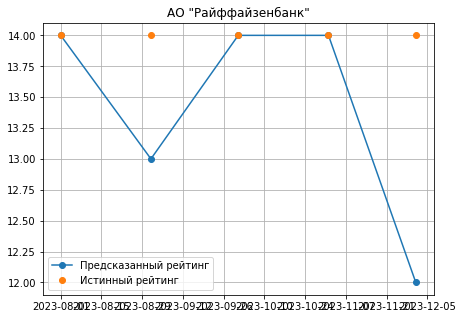

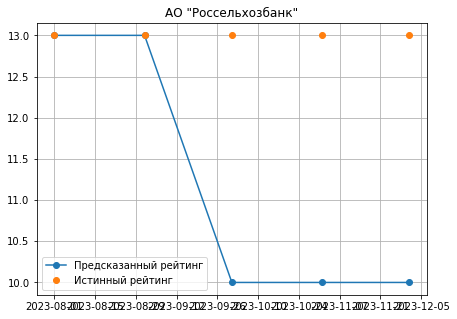

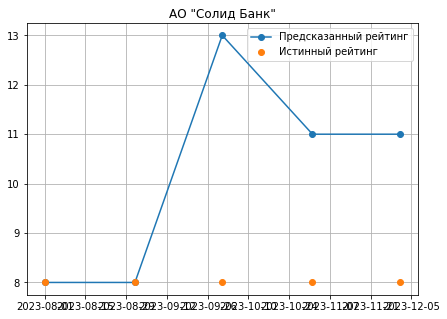

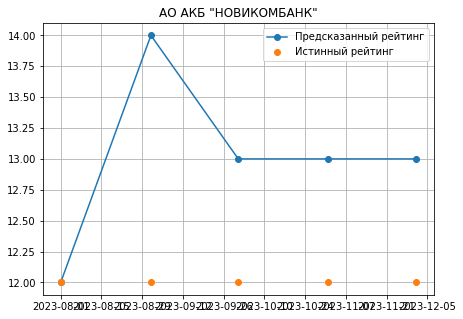

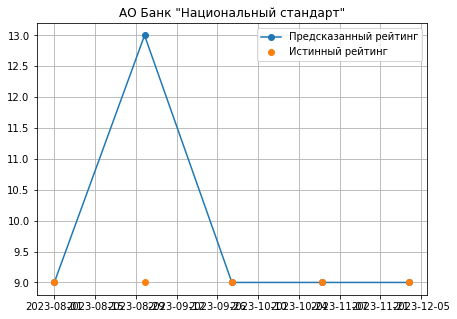

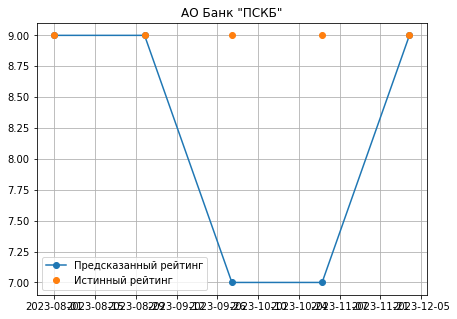

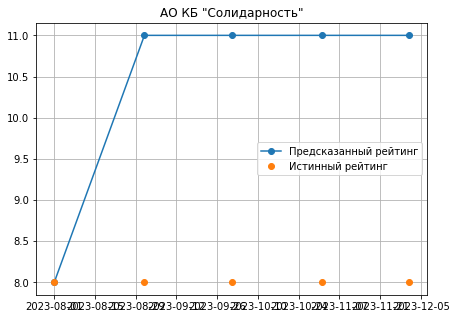

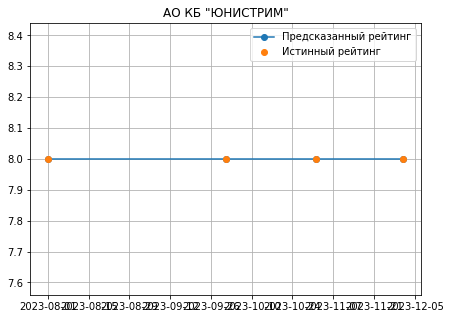

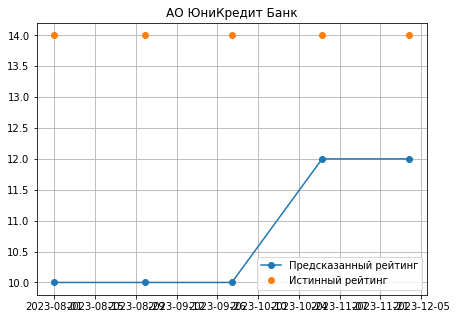

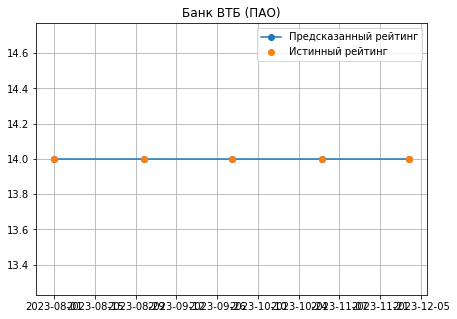

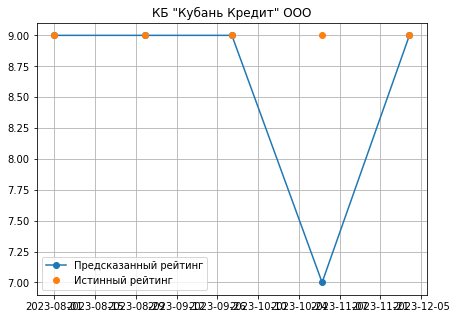

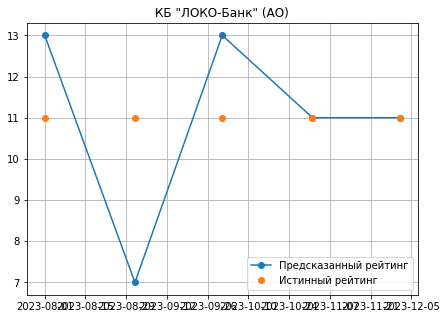

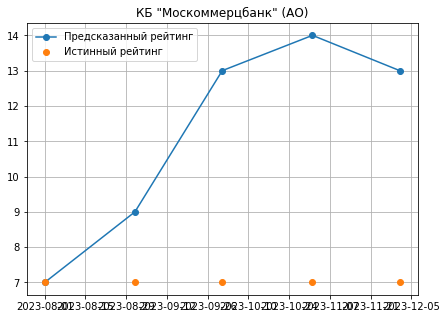

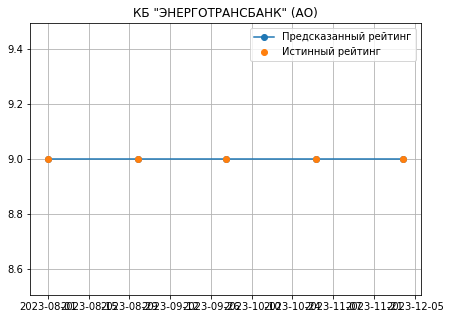

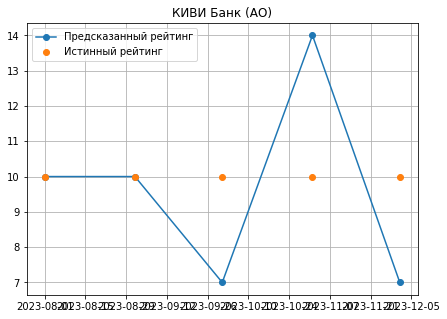

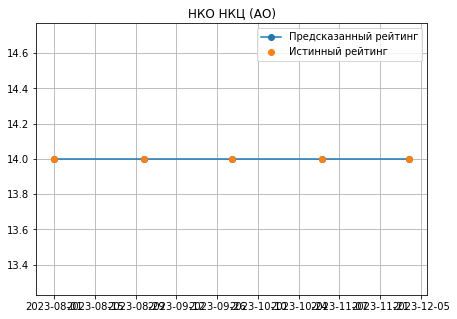

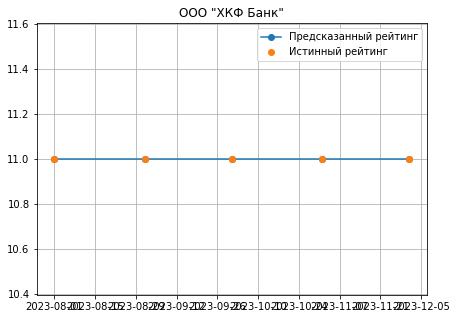

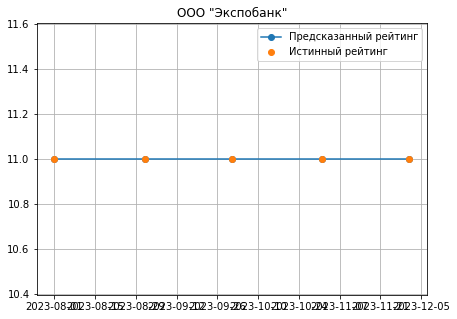

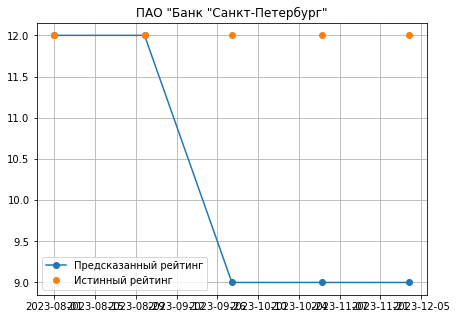

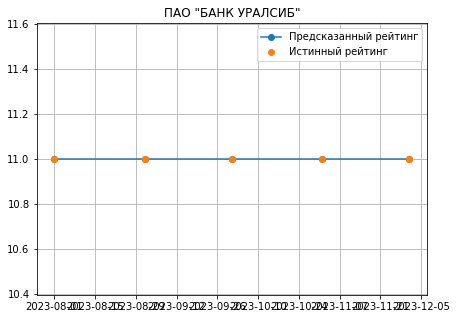

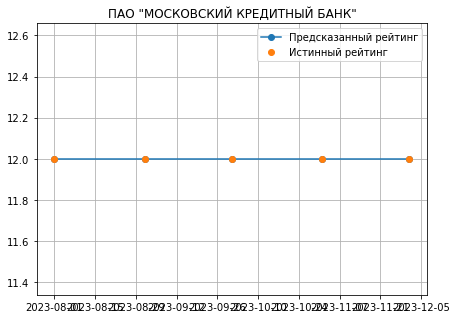

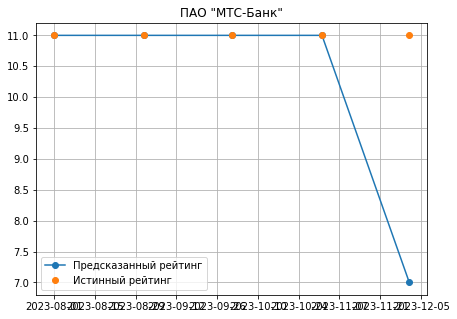

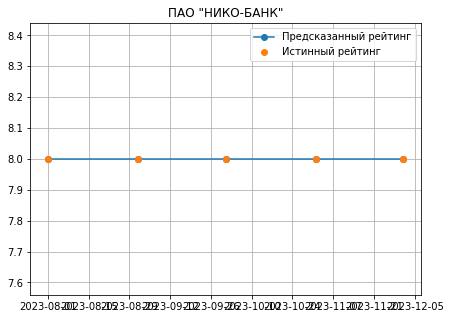

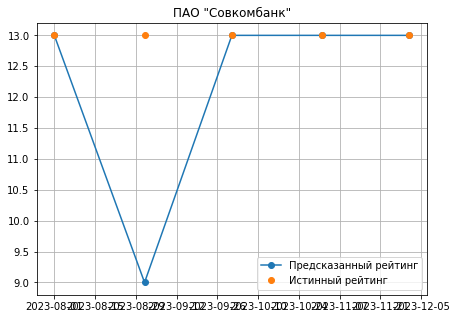

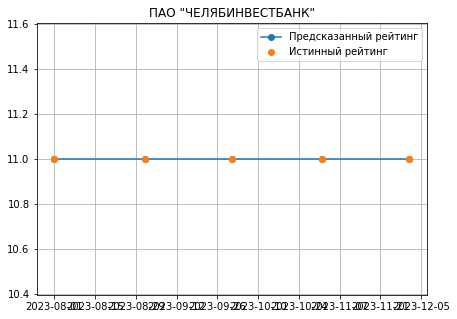

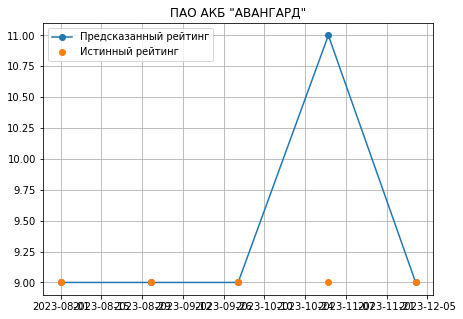

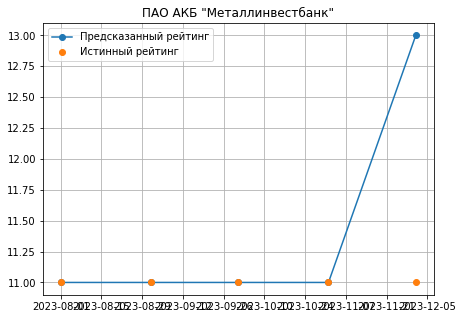

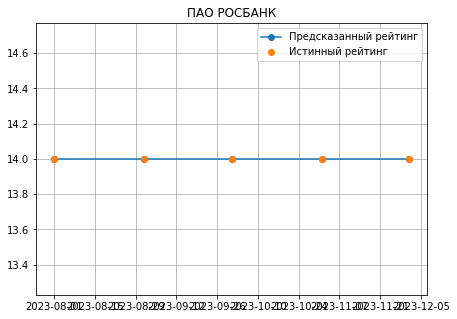

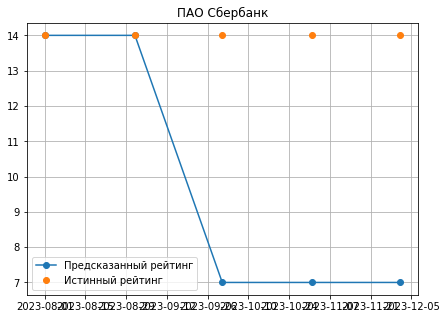

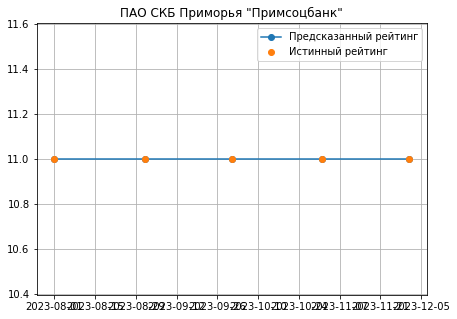

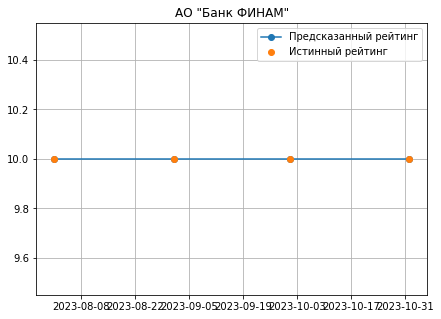

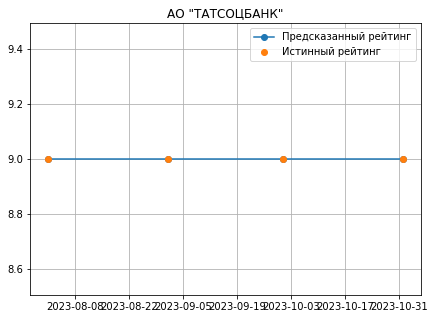

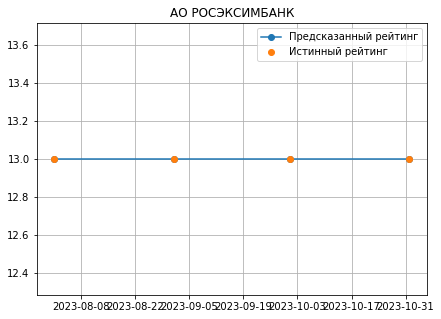

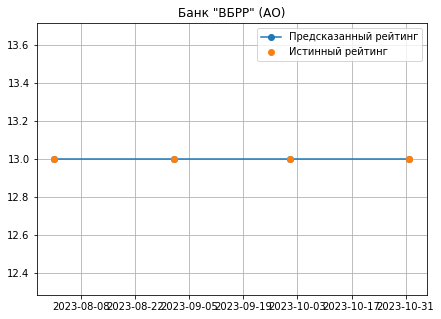

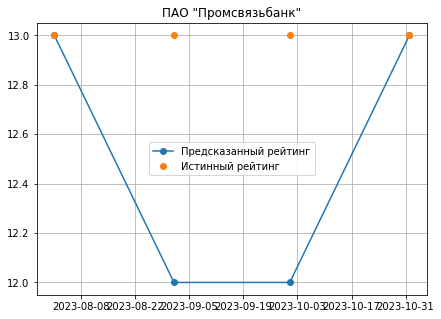

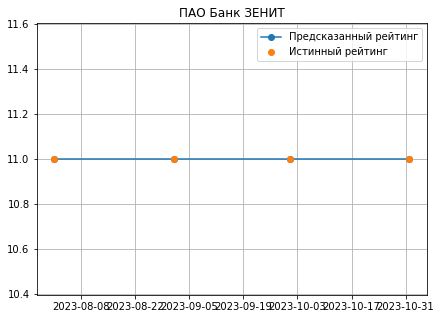

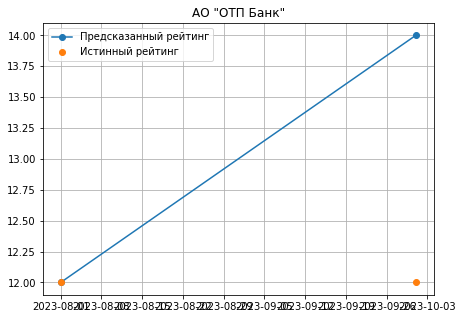

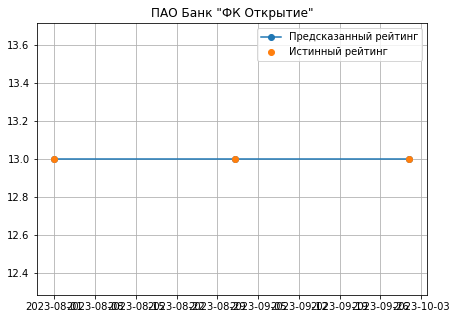

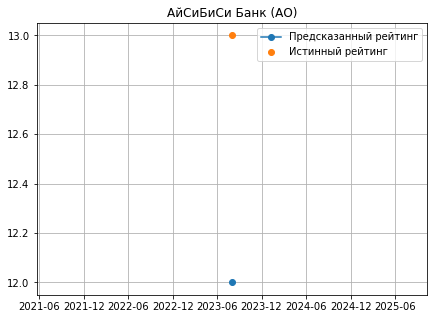

In [100]:
for bank in df_category.index.unique():
    df_onebank = df_category_test.loc[df_category_test.index == bank]
#     df_onebank['External_rating'] = score_cat(df_onebank['External_rating'])
    external_numpy_bank = df_onebank['External_rating'].values.reshape(-1, 1)
    external_numpy_bank = external_numpy_bank
    date_numpy_bank = df_onebank['report_date'].values.reshape(-1, 1)  
    
    df_bank_drop = df_onebank.drop("External_rating", axis = 1) 
    df_bank_drop = df_bank_drop.drop("report_date", axis = 1) 
    # переводим в numpy df_cat_drop, External_rating
    df_numpy_business = df_bank_drop[df_bank_drop.columns[:77]].values
    df_numpy_finance = df_bank_drop[df_bank_drop.columns[77:]].values

    # перемножаем матрицу признаков на веса df_numpy_bank * w
    y_pred_bank_bus = np.dot(df_numpy_business, w_triplets_dvum[:77])
    y_pred_bank_fin = np.dot(df_numpy_finance, w_triplets_dvum[77:])
    # делаем категорию
    # y_pred_bank = score_cat(y_pred_bank)
    # предсказание
#     y_pred_bank = model.predict(y_pred_bank)
    # рейтинг в баллах (дф признаков * веса после триплета)
    X_test = np.column_stack((y_pred_bank_bus, y_pred_bank_fin))
    
    # предсказание
    y_pred_bank = model.predict(X_test)
    
    plt.figure(figsize=(7, 5))
    plt.plot(date_numpy_bank, y_pred_bank, label='Предсказанный рейтинг', marker='o')
    plt.plot(date_numpy_bank, external_numpy_bank, label='Истинный рейтинг', marker='o', linestyle='None')
    plt.title(bank)
    plt.legend()
    plt.grid(True)
    plt.show()

In [106]:
y_pred_bank

array([12.])

## Строим график распределения бального рейтинга 

In [60]:
# получаем бальный рейтинг модели и к какой категории относится этот рейтинг 
plot_rating = np.dot(df_train, w_triplets_dvum)
plot_category = external_train.flatten()

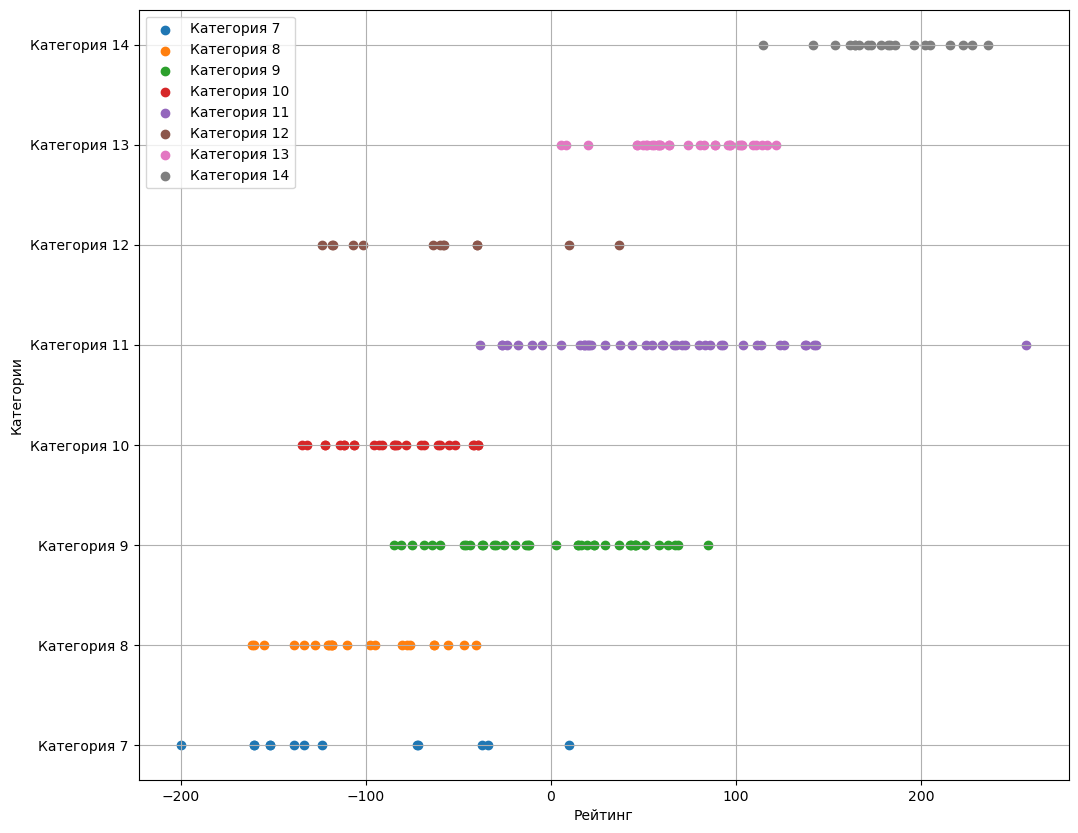

In [61]:
# уникальные категории
plot_unique_cat = np.unique(plot_category)

# создане графика
plt.figure(figsize=(12,10))

# построение скаттера для каждой категории
for category in plot_unique_cat:
    mask = (plot_category == category)
    plt.scatter(plot_rating[mask], [category] * np.sum(mask), label=f'Категория {category}')
    
# настройка графика
plt.xlabel('Рейтинг')
plt.ylabel('Категории')
plt.yticks(plot_unique_cat, [f'Категория {category}' for category in plot_unique_cat])
plt.legend()
plt.grid(True)
plt.show()

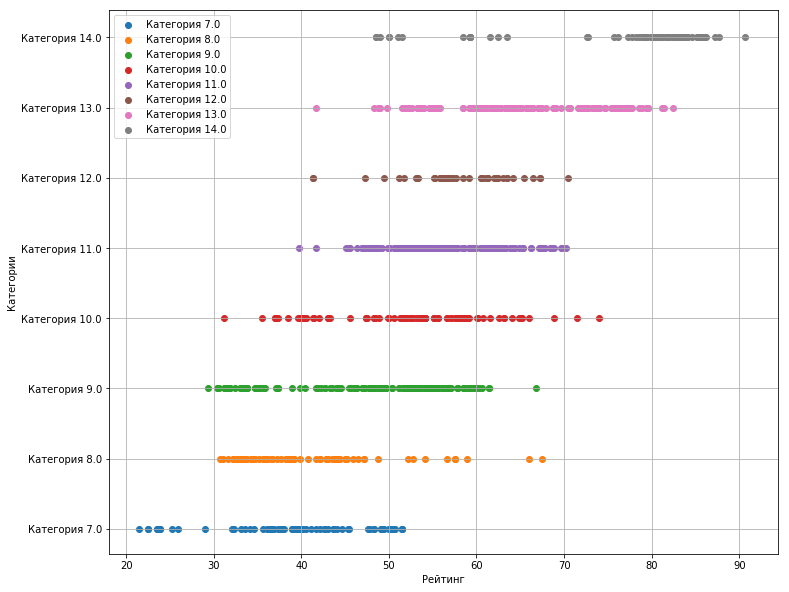

In [20]:
plot_rating_first = np.dot(df_numpy, w)

# создане графика
plt.figure(figsize=(12,10))

# построение скаттера для каждой категории
for category in plot_unique_cat:
    mask = (plot_category == category)
    plt.scatter(plot_rating_first[mask], [category] * np.sum(mask), label=f'Категория {category}')
    
# настройка графика
plt.xlabel('Рейтинг')
plt.ylabel('Категории')
plt.yticks(plot_unique_cat, [f'Категория {category}' for category in plot_unique_cat])
plt.legend()
plt.grid(True)
plt.show()

In [114]:
plot_rating = np.dot(df_numpy, w_triplet)
plot_category = score_cat(external_numpy).flatten()

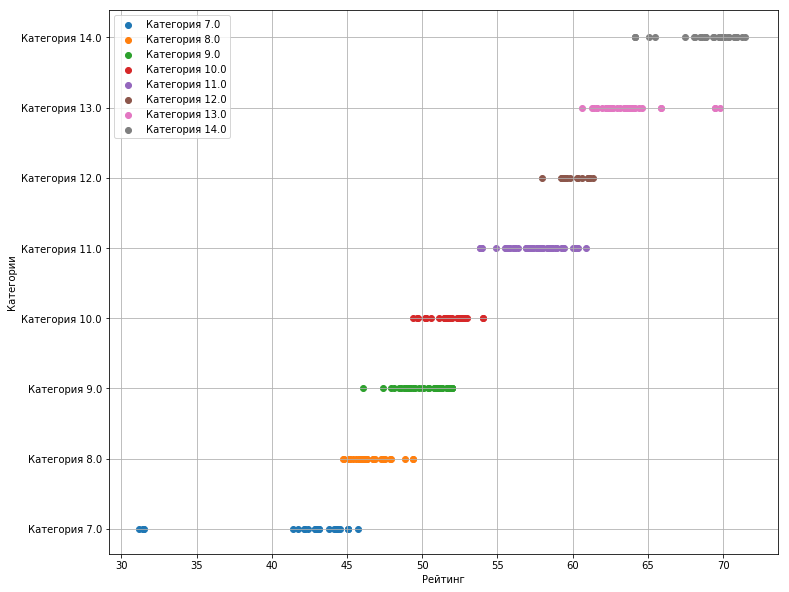

In [115]:
# уникальные категории
plot_unique_cat = np.unique(plot_category)

# создане графика
plt.figure(figsize=(12,10))

# построение скаттера для каждой категории
for category in plot_unique_cat:
    mask = (plot_category == category)
    plt.scatter(plot_rating[mask], [category] * np.sum(mask), label=f'Категория {category}')
    
# настройка графика
plt.xlabel('Рейтинг')
plt.ylabel('Категории')
plt.yticks(plot_unique_cat, [f'Категория {category}' for category in plot_unique_cat])
plt.legend()
plt.grid(True)
plt.show()

In [143]:
# получаем бальный рейтинг модели и к какой категории относится этот рейтинг 
plot_rating = np.dot(df_numpy, w_kul)
plot_category = score_cat(external_numpy).flatten()

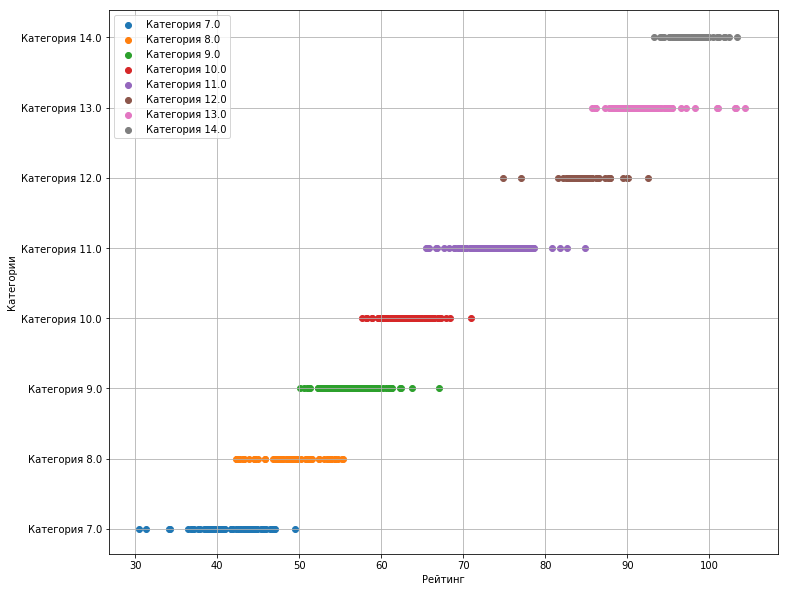

In [144]:
# уникальные категории
plot_unique_cat = np.unique(plot_category)

# создане графика
plt.figure(figsize=(12,10))

# построение скаттера для каждой категории
for category in plot_unique_cat:
    mask = (plot_category == category)
    plt.scatter(plot_rating[mask], [category] * np.sum(mask), label=f'Категория {category}')
    
# настройка графика
plt.xlabel('Рейтинг')
plt.ylabel('Категории')
plt.yticks(plot_unique_cat, [f'Категория {category}' for category in plot_unique_cat])
plt.legend()
plt.grid(True)
plt.show()